In [175]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
import gc
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier, LGBMRegressor
import lightgbm as lgb
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor,CatBoostClassifier
import optuna
import numpy as np
from sklearn.ensemble import VotingRegressor
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from impyute.imputation.cs import mice
import pickle
from scipy.stats import mode,boxcox,skew
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR

import os
import random
%matplotlib inline 
# Fixing Seed
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything()

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test.csv")
submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

# *EDA & Feature Engineering*

In [3]:
%%time
train.head()

Wall time: 997 µs


,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [4]:
%%time 
test.head()

Wall time: 0 ns


,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,0,308523.0,0.019845,NaN,0.908939,0.001438,NaN,0.112832,-8.890172,0,0.082714,126.129304,4,0.399620
1,1,200011.0,0.070119,0.731256,0.444655,0.002020,10.0,0.139040,-6.301214,0,0.061685,86.448149,3,0.499424
2,2,279758.0,0.810637,0.568858,0.125466,0.898841,0.0,0.226614,-11.542478,0,0.041868,99.544351,3,0.564951
3,3,249197.0,NaN,0.871789,0.557342,0.000715,4.0,0.325391,-7.905546,1,0.046815,123.063854,4,0.906485
4,4,NaN,0.765568,0.624687,0.710794,0.000346,8.0,0.308284,NaN,0,0.129284,88.703121,3,0.935571


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                40000 non-null  int64  
 1   song_duration_ms  35899 non-null  float64
 2   acousticness      36008 non-null  float64
 3   danceability      35974 non-null  float64
 4   energy            36025 non-null  float64
 5   instrumentalness  36015 non-null  float64
 6   key               35935 non-null  float64
 7   liveness          35914 non-null  float64
 8   loudness          36043 non-null  float64
 9   audio_mode        40000 non-null  int64  
 10  speechiness       40000 non-null  float64
 11  tempo             40000 non-null  float64
 12  time_signature    40000 non-null  int64  
 13  audio_valence     40000 non-null  float64
 14  song_popularity   40000 non-null  int64  
dtypes: float64(11), int64(4)
memory usage: 4.6 MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   song_duration_ms  9043 non-null   float64
 2   acousticness      9050 non-null   float64
 3   danceability      9024 non-null   float64
 4   energy            8945 non-null   float64
 5   instrumentalness  9000 non-null   float64
 6   key               9008 non-null   float64
 7   liveness          8994 non-null   float64
 8   loudness          8974 non-null   float64
 9   audio_mode        10000 non-null  int64  
 10  speechiness       10000 non-null  float64
 11  tempo             10000 non-null  float64
 12  time_signature    10000 non-null  int64  
 13  audio_valence     10000 non-null  float64
dtypes: float64(11), int64(3)
memory usage: 1.1 MB


We came to know that audio mode, time signature & key are categorical columns

In [7]:
cat_cols = ['audio_mode','time_signature','key']
cont_cols = [col for col in train.columns if col not in ['id','song_popularity','audio_mode','time_signature','key']]

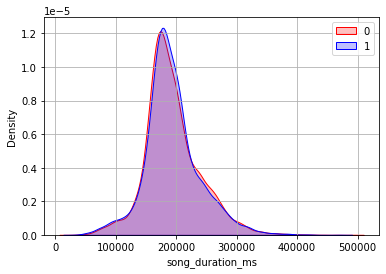

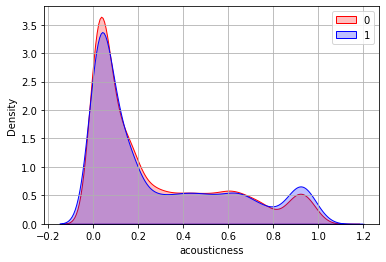

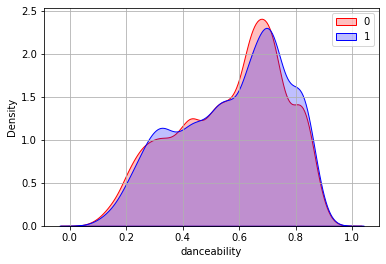

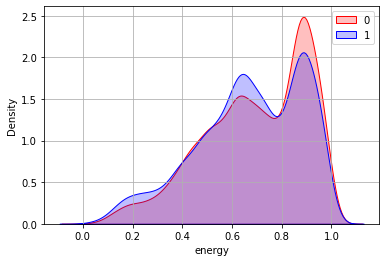

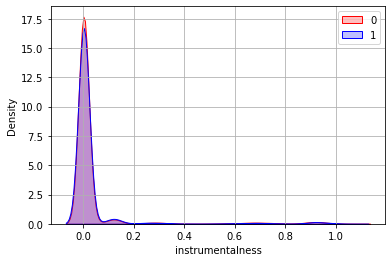

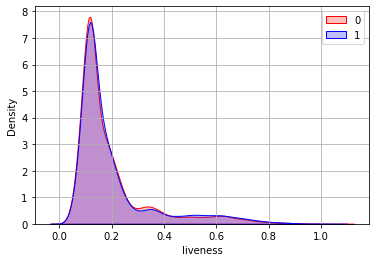

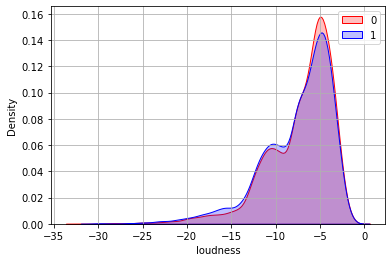

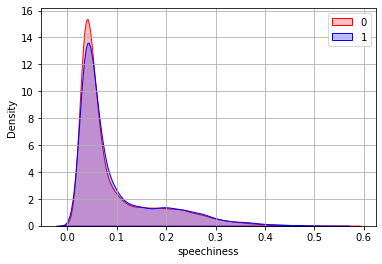

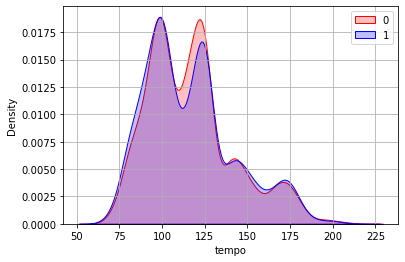

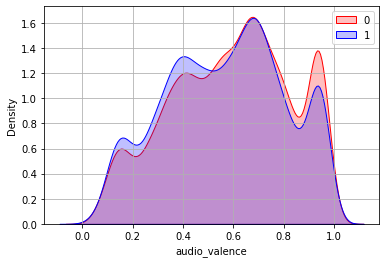

In [8]:
for cols in cont_cols:
    sns.kdeplot(train[cols][train['song_popularity'] == 0], color="red", shade=True)
    sns.kdeplot(train[cols][train['song_popularity'] == 1], color="blue", shade=True)
    plt.grid()
    plt.legend(['0','1'])
    plt.show()

In [9]:
for x in cont_cols:
    print(x," : ",train[x].skew())

song_duration_ms  :  0.6329315750087531
acousticness  :  1.0041944479340874
danceability  :  -0.39838573844116837
energy  :  -0.5828321649140663
instrumentalness  :  4.947630571834681
liveness  :  2.165545687789332
loudness  :  -1.4301003331775142
speechiness  :  1.7201205396556827
tempo  :  0.7641500817330785
audio_valence  :  -0.1810057441435877


Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. <br />
If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. <br />If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. <br />If the skewness is less than -1 or greater than 1, the data are highly skewed. <br />
Data needs Transformation <br />

In [10]:
skewed_features=['acousticness','liveness','instrumentalness','loudness','speechiness']

In [11]:
def log_transform(df):
    for x in skewed_features:
        log_inst=np.log(df[x])
        #print(x,"  ",log_inst.skew())
        if not np.isnan(log_inst.skew()):
            df[x]=log_inst

In [12]:
def transformation(df):
    data= np.array(df["loudness"])
    data=data.reshape(-1, 1)
    power = PowerTransformer(method='yeo-johnson', standardize=True)
    data_trans = power.fit_transform(data)
    data_trans=data_trans.reshape(1, -1)
    i=0
    for num in data_trans[0]:
        df["loudness"][i]=num
        i=i+1

In [13]:
def add_standard_time(df): 
    ms = df['song_duration_ms']
    millis = ms
    seconds=(millis/1000)%60
    minutes=(millis/(1000*60))%60
    hours=(millis/(1000*60*60))%24
    df['song_duration_s'] = seconds
    df['song_duration_m'] = minutes
    df['song_duration_h'] = hours
    return df

Let's check the missing values

In [14]:
print(f'Number of rows: {train.shape[0]};  Number of columns: {train.shape[1]}; No of missing values: {sum(train.isna().sum())}')

Number of rows: 40000;  Number of columns: 15; No of missing values: 32187


In [15]:
print(f'Number of rows: {test.shape[0]};  Number of columns: {test.shape[1]}; No of missing values: {sum(test.isna().sum())}')

Number of rows: 10000;  Number of columns: 14; No of missing values: 7962


In [16]:
train['nan_count'] = train.isnull().sum(axis=1)
test['nan_count'] = test.isnull().sum(axis=1)

In [37]:
def feature_engineering(x_train, x_valid, x_test=None):
    x_train_ids = x_train.id.values.tolist()
    x_valid_ids = x_valid.id.values.tolist()  
    x_test_ids = x_test.id.values.tolist()
    
    #Applying log transformation
    log_transform(x_train)
    log_transform(x_valid)
    log_transform(x_test)
    
    #Applying yeo-johnson to loudness
    transformation(x_train)
    transformation(x_valid)
    transformation(x_test)
    
    # Replace missing values for categorical column
    knn_imputer = KNNImputer(n_neighbors = 15, weights = 'distance')
    x_train_cat = pd.DataFrame(knn_imputer.fit_transform(x_train[cat_cols]))
    x_valid_cat = pd.DataFrame(knn_imputer.transform(x_valid[cat_cols]))
    x_test_cat = pd.DataFrame(knn_imputer.transform(x_test[cat_cols]))
    x_test_cat.columns = cat_cols
    x_train_cat.columns = cat_cols
    x_valid_cat.columns = cat_cols
    
    # Replace missing values for continuous columns
    it_imputer = IterativeImputer(imputation_order = 'random')
    
    x_train_cont = pd.DataFrame(it_imputer.fit_transform(x_train[cont_cols]))
    x_valid_cont = pd.DataFrame(it_imputer.transform(x_valid[cont_cols]))
    x_test_cont = pd.DataFrame(it_imputer.transform(x_test[cont_cols]))
    
    x_test_cont.columns = cont_cols
    x_train_cont.columns = cont_cols
    x_valid_cont.columns = cont_cols
    
    #Adding new features
    x_train_cont = add_standard_time(x_train_cont)
    x_valid_cont = add_standard_time(x_valid_cont)
    x_test_cont = add_standard_time(x_test_cont)
    
    cont_cols_ = [col for col in x_train_cont.columns if col not in ['id','song_popularity','audio_mode','time_signature','key']]
    
    x_test_cont.columns = cont_cols_
    x_train_cont.columns = cont_cols_
    x_valid_cont.columns = cont_cols_
    
    cont_cols_ = [col for col in x_train_cont.columns if col not in ['id','song_popularity','audio_mode','time_signature','key']]
    
    # Normalize
    robust_scaler = RobustScaler()
    
    x_train_cont = pd.DataFrame(robust_scaler.fit_transform(x_train_cont))
    x_valid_cont = pd.DataFrame(robust_scaler.transform(x_valid_cont))
    x_test_cont = pd.DataFrame(robust_scaler.transform(x_test_cont))
    
    x_test_cont.columns = cont_cols_
    x_train_cont.columns = cont_cols_
    x_valid_cont.columns = cont_cols_
    
    xtrain_ = pd.concat([x_train_cont,x_train_cat],axis = 1)
    xvalid_ = pd.concat([x_valid_cont,x_valid_cat],axis = 1)
    
    xtrain_['id'] = x_train_ids
    xvalid_['id'] = x_valid_ids
    
    xtest_ = pd.concat([x_test_cont,x_test_cat],axis = 1)
    xtest_['id'] = x_test_ids
    return xtrain_, xvalid_, xtest_

## *Modeling*

In [26]:
target = ['song_popularity']
not_features = ['id','kfold', 'song_popularity']
cols = list(train.columns)
features = [feat for feat in cols if feat not in not_features]

In [27]:
train["kfold"] = -1
train_targets = train[target]

In [28]:
# initialize stratified k-fold
kf = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=train, y=train_targets)):
    train.loc[valid_indicies, "kfold"] = fold

In [29]:
%%time
train.head()

Wall time: 0 ns


,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,nan_count,kfold
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0,1,9
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1,1,8
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0,1,5
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0,0,2
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0,1,1


In [30]:
%%time
test.head()

Wall time: 1 ms


,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,nan_count
0,0,308523.0,0.019845,NaN,0.908939,0.001438,NaN,0.112832,-8.890172,0,0.082714,126.129304,4,0.399620,2
1,1,200011.0,0.070119,0.731256,0.444655,0.002020,10.0,0.139040,-6.301214,0,0.061685,86.448149,3,0.499424,0
2,2,279758.0,0.810637,0.568858,0.125466,0.898841,0.0,0.226614,-11.542478,0,0.041868,99.544351,3,0.564951,0
3,3,249197.0,NaN,0.871789,0.557342,0.000715,4.0,0.325391,-7.905546,1,0.046815,123.063854,4,0.906485,1
4,4,NaN,0.765568,0.624687,0.710794,0.000346,8.0,0.308284,NaN,0,0.129284,88.703121,3,0.935571,2


Let's save our train & test

In [31]:
train.to_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv", index=False)
test.to_csv('D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv', index=False)

## *L0 Models*

Lets try Logistic Regression first to benchmark

### Logistic Regression - 1

In [109]:
%%time
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}
for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    model = LogisticRegression(random_state=RANDOM_SEED)
    model.fit(xtrain, ytrain)
    
    preds_valid = model.predict_proba(xvalid)[:, 1]
    test_preds = model.predict_proba(xtest)[:,1]
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_1"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred1.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_1"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred1.csv", index=False)

ROC-AUC is:  0.5595801628597593
0 0.5595801628597593
ROC-AUC is:  0.5487849213162972
1 0.5487849213162972
ROC-AUC is:  0.5575232966213792
2 0.5575232966213792
ROC-AUC is:  0.5576423201105705
3 0.5576423201105705
ROC-AUC is:  0.5553537335453004
4 0.5553537335453004
ROC-AUC is:  0.5615246843428212
5 0.5615246843428212
ROC-AUC is:  0.5530951078128862
6 0.5530951078128862
ROC-AUC is:  0.5543036115347215
7 0.5543036115347215
ROC-AUC is:  0.5555231776929478
8 0.5555231776929478
ROC-AUC is:  0.5385579871330374
9 0.5385579871330374
0.554188900296972 0.006195150162341461
Wall time: 4min 2s


### LGBM Classifier - 2

In [46]:
%%time
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}
for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    param = {
        
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        'learning_rate': 0.04017920582555955,
        'lambda_l1': 3.162789255126581e-07,
        'lambda_l2': 1.6215178199584142e-06,
        'num_leaves': 32,
        'feature_fraction': 0.5087220143021918,
        'bagging_fraction': 0.8535521610286452,
        'bagging_freq': 3,
        'min_child_samples': 5
    }
    
    model = LGBMClassifier(**param, early_stopping_rounds=2000, random_state=RANDOM_SEED, n_estimators=10000)
    model.fit(xtrain, ytrain, eval_set=[(xvalid, yvalid)], verbose=False)
    
    preds_valid = model.predict_proba(xvalid)[:, 1]
    test_preds = model.predict_proba(xtest)[:,1]
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_2"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred2.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_2"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred2.csv", index=False)

ROC-AUC is:  0.5866176574180108
0 0.5866176574180108
ROC-AUC is:  0.5681258334680557
1 0.5681258334680557
ROC-AUC is:  0.5696191599208777
2 0.5696191599208777
ROC-AUC is:  0.5736019935489809
3 0.5736019935489809
ROC-AUC is:  0.5768491267150824
4 0.5768491267150824
ROC-AUC is:  0.5858612349564355
5 0.5858612349564355
ROC-AUC is:  0.5704882257902627
6 0.5704882257902627
ROC-AUC is:  0.5761975222301008
7 0.5761975222301008
ROC-AUC is:  0.5741094199074209
8 0.5741094199074209
ROC-AUC is:  0.570130180592925
9 0.570130180592925
0.5751600354548152 0.006168954630038631
Wall time: 3min 56s


### XGB Classifier - 3

In [62]:
%%time
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}
for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    param = {
        
        "metric": "auc",
        "boosting_type": "gbdt",
        'learning_rate': 0.04563936862022462,
        'reg_lambda': 0.002794989221904362,
        'reg_alpha': 1.2265927243970227,
        'subsample': 0.28018087195801633,
        'colsample_bytree': 0.9945399189155419,
        'max_depth': 3,
        'min_child_weight': 114,
        'random_state':RANDOM_SEED, 
        'n_estimators':10000
    }
    
    model = XGBClassifier(**param)
    model.fit(xtrain, ytrain, early_stopping_rounds=2000, eval_set=[(xvalid, yvalid)], verbose=False)
    
    preds_valid = model.predict_proba(xvalid)[:, 1]
    test_preds = model.predict_proba(xtest)[:,1]
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_3"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred3.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_3"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred3.csv", index=False)

[15:52:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:52:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC is:  0.5833584110337203
0 0.5833584110337203
[15:53:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in lan

### CatBoost Classifier - 4

In [70]:
%%time
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}
for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    param = {   
        'iterations': 211,
        'depth': 6,
        'learning_rate': 0.028500007493731976,
        'random_strength': 29,
        'bagging_temperature': 0.027653617855671702,
        'od_type': 'Iter'
    }
    
    model = CatBoostClassifier(loss_function="Logloss", eval_metric="AUC",
                               random_state=RANDOM_SEED, 
                               l2_leaf_reg=50,
                                border_count=64,**param)
    
    model.fit(xtrain, ytrain, verbose=False)
    
    preds_valid = model.predict_proba(xvalid)[:, 1]
    test_preds = model.predict_proba(xtest)[:,1]
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_4"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred4.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_4"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred4.csv", index=False)

ROC-AUC is:  0.5772215491352444
0 0.5772215491352444
ROC-AUC is:  0.5623603464474187
1 0.5623603464474187
ROC-AUC is:  0.563524671464132
2 0.563524671464132
ROC-AUC is:  0.5766461339902207
3 0.5766461339902207
ROC-AUC is:  0.5721651292578238
4 0.5721651292578238
ROC-AUC is:  0.5728075600150666
5 0.5728075600150666
ROC-AUC is:  0.5604340900039825
6 0.5604340900039825
ROC-AUC is:  0.5783835675871692
7 0.5783835675871692
ROC-AUC is:  0.570356286000136
8 0.570356286000136
ROC-AUC is:  0.5583497650986068
9 0.5583497650986068
0.5692249098999801 0.007076894366892037
Wall time: 4min 14s


### LGBM Regressor - 5

In [78]:
%%time
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}
for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    params_lgb = {  
                "task": "train",
                "objective": "regression",
                "metric": "auc",
                "verbosity": -1,
                "boosting_type": "gbdt",
                'learning_rate': 0.013673650507067989,
                'lambda_l1': 0.84708712061607,
                'lambda_l2': 0.028150773602974747,
                'num_leaves': 73,
                'feature_fraction': 0.5548992684625993,
                'bagging_fraction': 0.9351996142146171,
                'bagging_freq': 6,
                'min_child_samples': 28,
                'n_estimators': 5000,
                'random_state':RANDOM_SEED,
             }
    lgb_train = lgb.Dataset(xtrain, ytrain)
    lgb_val = lgb.Dataset(xvalid, yvalid)
    
    model = lgb.train(params=params_lgb,
                      train_set=lgb_train,
                      valid_sets=lgb_val,
                      early_stopping_rounds=1000,
                      verbose_eval=False)
    
    preds_valid = model.predict(xvalid,num_iteration=model.best_iteration)
    test_preds = model.predict(xtest,num_iteration=model.best_iteration)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_5"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred5.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_5"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred5.csv", index=False)

ROC-AUC is:  0.5836615025946311
0 0.5836615025946311
ROC-AUC is:  0.5715367605800681
1 0.5715367605800681
ROC-AUC is:  0.5681630789136529
2 0.5681630789136529
ROC-AUC is:  0.5865319659036837
3 0.5865319659036837
ROC-AUC is:  0.5840737071249644
4 0.5840737071249644
ROC-AUC is:  0.5790575667604546
5 0.5790575667604546
ROC-AUC is:  0.5663738088993793
6 0.5663738088993793
ROC-AUC is:  0.5777187421416229
7 0.5777187421416229
ROC-AUC is:  0.5704086302113519
8 0.5704086302113519
ROC-AUC is:  0.567471418441783
9 0.567471418441783
0.5754997181571592 0.007229157331337897
Wall time: 4min 26s


### XGB Regressor - 6

In [85]:
%%time
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}
for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    param = {
        'random_state': RANDOM_SEED, 
        'n_estimators': 5000,
        'learning_rate': 0.04209840880327001,
        'reg_lambda': 2.2370404206858805e-05,
        'reg_alpha': 2.1075601079308557,
        'subsample': 0.20945842427200848,
        'colsample_bytree': 0.3170434232228391,
        'max_depth': 2,
        'min_child_weight': 60
    }
    
    model = XGBRegressor(**param)
    model.fit(xtrain, ytrain, early_stopping_rounds=300, eval_set=[(xvalid, yvalid)], verbose=False)
    
    preds_valid = model.predict(xvalid)
    test_preds = model.predict(xtest)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_6"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred6.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_6"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred6.csv", index=False)

ROC-AUC is:  0.5827071555248355
0 0.5827071555248355
ROC-AUC is:  0.5621268876761027
1 0.5621268876761027
ROC-AUC is:  0.5680929063349914
2 0.5680929063349914
ROC-AUC is:  0.5756897627114252
3 0.5756897627114252
ROC-AUC is:  0.5738633481516018
4 0.5738633481516018
ROC-AUC is:  0.5818578471527447
5 0.5818578471527447
ROC-AUC is:  0.5714735920756261
6 0.5714735920756261
ROC-AUC is:  0.5805920076325415
7 0.5805920076325415
ROC-AUC is:  0.575065915931959
8 0.575065915931959
ROC-AUC is:  0.5656248010110527
9 0.5656248010110527
0.573709422420288 0.006607358973063371
Wall time: 4min 26s


### CatBoost Regressor - 7

In [91]:
%%time
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}
for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    params = {  
        'learning_rate': 0.04971783242152931,
        'iterations': 1363,
        'l2_leaf_reg': 4.266438189508481,
        'depth': 3
    }
    model = CatBoostRegressor(
        **params
    )
    model.fit(xtrain, ytrain, early_stopping_rounds=300, eval_set=[(xvalid, yvalid)], verbose=False)
    preds_valid = model.predict(xvalid)
    test_preds = model.predict(xtest)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_7"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred7.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_7"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred7.csv", index=False)

ROC-AUC is:  0.581946592729959
0 0.581946592729959
ROC-AUC is:  0.5688707423800001
1 0.5688707423800001
ROC-AUC is:  0.5733256215468681
2 0.5733256215468681
ROC-AUC is:  0.5793000069362895
3 0.5793000069362895
ROC-AUC is:  0.5791992199093636
4 0.5791992199093636
ROC-AUC is:  0.5882874161278451
5 0.5882874161278451
ROC-AUC is:  0.5741774134188973
6 0.5741774134188973
ROC-AUC is:  0.581527997677428
7 0.581527997677428
ROC-AUC is:  0.5751015315808277
8 0.5751015315808277
ROC-AUC is:  0.5705761856503472
9 0.5705761856503472
0.5772312727957826 0.005607062413746003
Wall time: 4min 17s


### Naive-Bias - 8

In [92]:
%%time
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}
for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    model =  GaussianNB()
    model.fit(xtrain, ytrain)
    
    preds_valid = model.predict_proba(xvalid)[:, 1]
    test_preds = model.predict_proba(xtest)[:,1]
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_8"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred8.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_8"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred8.csv", index=False)

ROC-AUC is:  0.5518905977111324
0 0.5518905977111324
ROC-AUC is:  0.5443035924851646
1 0.5443035924851646
ROC-AUC is:  0.546179899280758
2 0.546179899280758
ROC-AUC is:  0.5493862463365191
3 0.5493862463365191
ROC-AUC is:  0.5526205023101605
4 0.5526205023101605
ROC-AUC is:  0.5491957338928228
5 0.5491957338928228
ROC-AUC is:  0.5374919460066763
6 0.5374919460066763
ROC-AUC is:  0.5447834406659479
7 0.5447834406659479
ROC-AUC is:  0.5471351527533594
8 0.5471351527533594
ROC-AUC is:  0.5340566547839911
9 0.5340566547839911
0.5457043766226533 0.00565725081716053
Wall time: 3min 59s


### XGB Classifier - 9

In [93]:
%%time
#nb - https://www.kaggle.com/varunnagpalspyz/iterative-imputer-xgb-hyp-tuning-optuna
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}
for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    
    learning_rate = 0.02859668002863679
    reg_lambda = 0.00012042589601632438
    reg_alpha = 16.683659682374774
    subsample = 0.4464941229852304
    colsample_bytree =0.5235019404878758
    max_depth = 4
    
    model = XGBClassifier(
            random_state=RANDOM_SEED,
            n_estimators=7000,
            learning_rate=learning_rate,
            reg_lambda=reg_lambda,
            reg_alpha=reg_alpha,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            max_depth=max_depth
                         )
    model.fit(xtrain, ytrain, early_stopping_rounds=300, eval_set=[(xvalid, yvalid)], verbose=False)
    
    preds_valid = model.predict_proba(xvalid)[:, 1]
    test_preds = model.predict_proba(xtest)[:,1]
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_9"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred9.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_9"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred9.csv", index=False)

[18:06:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC is:  0.5809301699175013
0 0.5809301699175013
[18:06:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC is:  0.5677514897503502
1 0.5677514897503502
[18:07:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'

### XGB Classifier - 10

In [94]:
%%time
#nb - https://www.kaggle.com/dienhoa/xgboost-song-popularity/notebook
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}
for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    param = {
        'max_depth': 12,
        'n_estimators': 5600,
        'learning_rate': 0.07074059946646541,
        'subsample': 0.8,
        'colsample_bytree': 0.6000000000000001,
        'colsample_bylevel': 0.5,
        'min_child_weight': 0.00390933891195369,
        'reg_lambda': 2176.9882633091584,
        'reg_alpha': 0.00027465681042320085,
        'gamma': 0.4559027070257692
    }
    model = XGBClassifier(
            **param,
            booster= 'gbtree',
            eval_metric = 'auc',
            random_state=RANDOM_SEED, 
            use_label_encoder=False
                         )
    model.fit(xtrain, ytrain, early_stopping_rounds=100, eval_set=[(xvalid, yvalid)], verbose=False)
    
    preds_valid = model.predict_proba(xvalid)[:, 1]
    test_preds = model.predict_proba(xtest)[:,1]
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_10"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred10.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_10"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred10.csv", index=False)

ROC-AUC is:  0.5810458197250261
0 0.5810458197250261
ROC-AUC is:  0.5654908531393188
1 0.5654908531393188
ROC-AUC is:  0.5714814322007389
2 0.5714814322007389
ROC-AUC is:  0.5791662741950327
3 0.5791662741950327
ROC-AUC is:  0.5800498133416221
4 0.5800498133416221
ROC-AUC is:  0.5813052649642386
5 0.5813052649642386
ROC-AUC is:  0.5697988471322387
6 0.5697988471322387
ROC-AUC is:  0.5784477836813414
7 0.5784477836813414
ROC-AUC is:  0.5728696175850648
8 0.5728696175850648
ROC-AUC is:  0.5664809256615068
9 0.5664809256615068
0.5746136631626129 0.005801127045779574
Wall time: 6min 41s


### LGBM Regressor - 11

In [96]:
%%time
#nb - https://www.kaggle.com/devkhant24/lightgbm-iterative-imputer
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}
for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    params_lgb = {
            "task": "train",
            "boosting_type": "gbdt",
            "objective": "binary",
            'subsample': 0.95312,
            'learning_rate': 0.001635,
            "max_depth": 3,
            "feature_fraction": 0.2256038826485174,
            "bagging_fraction": 0.7705303688019942,
            "min_child_samples": 290,
            "reg_alpha": 14.68267919457715,
            "reg_lambda": 66.156,
            "max_bin": 772,
            "min_data_per_group": 177,
            "bagging_freq": 1,
            "cat_smooth": 96,
            "cat_l2": 17,
            "verbosity": -1,
            'random_state':RANDOM_SEED,
            'n_estimators':5000,
            'colsample_bytree':0.1107
    }
    lgb_train = lgb.Dataset(xtrain, ytrain)
    lgb_val = lgb.Dataset(xvalid, yvalid)
    
    model = lgb.train(params=params_lgb,
                      train_set=lgb_train,
                      valid_sets=lgb_val,
                      early_stopping_rounds=300,
                      verbose_eval=False)
    
    preds_valid = model.predict(xvalid,num_iteration=model.best_iteration)
    test_preds = model.predict(xtest,num_iteration=model.best_iteration)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_11"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred11.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_11"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred11.csv", index=False)

ROC-AUC is:  0.580885907214038
0 0.580885907214038
ROC-AUC is:  0.5680756330848594
1 0.5680756330848594
ROC-AUC is:  0.5659186359746202
2 0.5659186359746202
ROC-AUC is:  0.5798152356003845
3 0.5798152356003845
ROC-AUC is:  0.5757145524462015
4 0.5757145524462015
ROC-AUC is:  0.5814616230590821
5 0.5814616230590821
ROC-AUC is:  0.5702480899759217
6 0.5702480899759217
ROC-AUC is:  0.5734027730560061
7 0.5734027730560061
ROC-AUC is:  0.5708427633858179
8 0.5708427633858179
ROC-AUC is:  0.5602487267405529
9 0.5602487267405529
0.5726613940537484 0.006601782101999153
Wall time: 4min 46s


### XGB Regressor - 12

In [99]:
%%time
#nb - https://www.kaggle.com/nitishraj/spp-boosting-fe-optuna
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}
for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    param = {
            "n_estimators": 30000,
            "objective": "binary:logistic",
            "random_state": RANDOM_SEED,
            "n_jobs": -1,
            "eval_metric" : ['aucpr','auc'],
            "use_label_encoder" : False,
            'max_depth' : 2,
            'learning_rate' : 0.012270081571839349,
            'colsample_bytree' : 0.7115226384569703,
            'subsample' : 0.2967650823173518,
            'alpha' : 22.827869876982327,
            'lambda' : 0.00040429403827017444,
            'min_child_weight' : 41.2508865113094,
            'best_objective_value' : 0.576547738284059,
    }
    
    model = XGBRegressor(**param)
    model.fit(xtrain, ytrain, early_stopping_rounds=3000, eval_set=[(xvalid, yvalid)], verbose=False)
    
    preds_valid = model.predict(xvalid)
    test_preds = model.predict(xtest)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_12"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred12.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_12"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred12.csv", index=False)

[18:31:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "best_objective_value" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


ROC-AUC is:  0.5784773683987507
0 0.5784773683987507
[18:32:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "best_objective_value" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


ROC-AUC is:  0.5669300657382115
1 0.5669300657382115
[18:33:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.c

### CatBoost Regressor - 13

In [100]:
%%time
#nb - https://www.kaggle.com/sardorabdirayimov/catboost-feature-engineering-yandex-sklearn/comments
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}
for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    params ={'iterations': 50, 'learning_rate': 0.1, 'bootstrap_type': 'Bernoulli'}
    
    model = CatBoostRegressor(
        **params
    )
    model.fit(xtrain, ytrain, verbose=False)
    preds_valid = model.predict(xvalid)
    test_preds = model.predict(xtest)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_13"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred13.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_13"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred13.csv", index=False)

ROC-AUC is:  0.5788668262103218
0 0.5788668262103218
ROC-AUC is:  0.5628631599629813
1 0.5628631599629813
ROC-AUC is:  0.5679390664510029
2 0.5679390664510029
ROC-AUC is:  0.5828863654949556
3 0.5828863654949556
ROC-AUC is:  0.5797685306602169
4 0.5797685306602169
ROC-AUC is:  0.578555709890034
5 0.578555709890034
ROC-AUC is:  0.5642765328489605
6 0.5642765328489605
ROC-AUC is:  0.574656875601014
7 0.574656875601014
ROC-AUC is:  0.5678275749304685
8 0.5678275749304685
ROC-AUC is:  0.5602123016451191
9 0.5602123016451191
0.5717852943695075 0.007691395159568223
Wall time: 4min 2s


### LGBM Regressor - 14

In [102]:
%%time
#nb - https://www.kaggle.com/venkatkumar001/spp2-lgbm
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}
for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    params_lgb = {
        "task": "train",
        "boosting_type": "gbdt",
        "objective": "regression",
        'subsample': 0.95312,
        'learning_rate': 0.001635,
        "max_depth": 6,
        "feature_fraction": 0.2256038826485174,
        "bagging_fraction": 0.7705303688019942,
        "min_child_samples": 290,
        "reg_alpha": 14.68267919457715,
        "reg_lambda": 66.156,
        "max_bin": 772,
        "min_data_per_group": 177,
        "bagging_freq": 1,
        "cat_smooth": 96,
        "cat_l2": 17,
        "verbosity": -1,
        'random_state':RANDOM_SEED,
        'n_estimators':15000,
        'colsample_bytree':0.1107
    }
    
    lgb_train = lgb.Dataset(xtrain, ytrain)
    lgb_val = lgb.Dataset(xvalid, yvalid)
    
    model = lgb.train(params=params_lgb,
                      train_set=lgb_train,
                      valid_sets=lgb_val,
                      early_stopping_rounds=300,
                      verbose_eval=False)
    
    preds_valid = model.predict(xvalid,num_iteration=model.best_iteration)
    test_preds = model.predict(xtest,num_iteration=model.best_iteration)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_14"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred14.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_14"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred14.csv", index=False)

ROC-AUC is:  0.5796452020443971
0 0.5796452020443971
ROC-AUC is:  0.5689506311618608
1 0.5689506311618608
ROC-AUC is:  0.5657507615748993
2 0.5657507615748993
ROC-AUC is:  0.5823649292565944
3 0.5823649292565944
ROC-AUC is:  0.5773809331084151
4 0.5773809331084151
ROC-AUC is:  0.5837868932253639
5 0.5837868932253639
ROC-AUC is:  0.5712342657078502
6 0.5712342657078502
ROC-AUC is:  0.5759711470073681
7 0.5759711470073681
ROC-AUC is:  0.5690824869220417
8 0.5690824869220417
ROC-AUC is:  0.5588208629995499
9 0.5588208629995499
0.5732988113008342 0.0075087054894119225
Wall time: 5min 11s


### LGBM Classifier - 15

In [104]:
%%time
#nb - https://www.kaggle.com/mohammadkashifunique/spp-eda-model-prediction-lightgbm
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}
for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    params = {  
            'objective': 'binary', 
            'n_estimators': 20000,
            'max_depth': 7,
            'learning_rate':  0.01, 
            'min_child_weight': 256,
            'min_child_samples': 15, 
            'reg_alpha': 10, 
            'reg_lambda': 0.1, 
            'subsample': 0.6, 
            'subsample_freq': 1, 
            'colsample_bytree': 0.4,
             }
    
    model = LGBMClassifier(**params, early_stopping_rounds=300, random_state=RANDOM_SEED)
    model.fit(xtrain, ytrain, eval_set=[(xvalid, yvalid)], verbose=False)
    
    preds_valid = model.predict_proba(xvalid)[:, 1]
    test_preds = model.predict_proba(xtest)[:,1]
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_15"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred15.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_15"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred15.csv", index=False)

ROC-AUC is:  0.5833241344279896
0 0.5833241344279896
ROC-AUC is:  0.5689004307786647
1 0.5689004307786647
ROC-AUC is:  0.5675031867797021
2 0.5675031867797021
ROC-AUC is:  0.5836358626139664
3 0.5836358626139664
ROC-AUC is:  0.5769319600802538
4 0.5769319600802538
ROC-AUC is:  0.5853224133595378
5 0.5853224133595378
ROC-AUC is:  0.5710483628133772
6 0.5710483628133772
ROC-AUC is:  0.5795791201639615
7 0.5795791201639615
ROC-AUC is:  0.5720617899130007
8 0.5720617899130007
ROC-AUC is:  0.5641667179316159
9 0.5641667179316159
0.5752473978862069 0.0071381074326709055
Wall time: 4min 5s


Getting the preds from our L0 models

In [147]:
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_10folds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_10folds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

df1 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred1.csv")
df2 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred2.csv")
df3 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred3.csv")
df4 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred4.csv")
df5 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred5.csv")
df6 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred6.csv")
df7 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred7.csv")
df8 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred8.csv")
df9 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred9.csv")
df10 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred10.csv")
df11 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred11.csv")
df12 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred12.csv")
df13 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred13.csv")
df14 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred14.csv")
df15 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred15.csv")

df_test1 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred1.csv")
df_test2 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred2.csv")
df_test3 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred3.csv")
df_test4 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred4.csv")
df_test5 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred5.csv")
df_test6 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred6.csv")
df_test7 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred7.csv")
df_test8 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred8.csv")
df_test9 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred9.csv")
df_test10 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred10.csv")
df_test11 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred11.csv")
df_test12 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred12.csv")
df_test13 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred13.csv")
df_test14 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred14.csv")
df_test15 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred15.csv")

train = train.merge(df1, on="id", how="left")
train = train.merge(df2, on="id", how="left")
train = train.merge(df3, on="id", how="left")
train = train.merge(df4, on="id", how="left")
train = train.merge(df5, on="id", how="left")
train = train.merge(df6, on="id", how="left")
train = train.merge(df7, on="id", how="left")
train = train.merge(df8, on="id", how="left")
train = train.merge(df9, on="id", how="left")
train = train.merge(df10, on="id", how="left")
train = train.merge(df11, on="id", how="left")
train = train.merge(df12, on="id", how="left")
train = train.merge(df13, on="id", how="left")
train = train.merge(df14, on="id", how="left")
train = train.merge(df15, on="id", how="left")

test = test.merge(df_test1, on="id", how="left")
test = test.merge(df_test2, on="id", how="left")
test = test.merge(df_test3, on="id", how="left")
test = test.merge(df_test4, on="id", how="left")
test = test.merge(df_test5, on="id", how="left")
test = test.merge(df_test6, on="id", how="left")
test = test.merge(df_test7, on="id", how="left")
test = test.merge(df_test8, on="id", how="left")
test = test.merge(df_test9, on="id", how="left")
test = test.merge(df_test10, on="id", how="left")
test = test.merge(df_test11, on="id", how="left")
test = test.merge(df_test12, on="id", how="left")
test = test.merge(df_test13, on="id", how="left")
test = test.merge(df_test14, on="id", how="left")
test = test.merge(df_test15, on="id", how="left")

train.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,...,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,...,0.488437,0.468360,0.356976,0.447932,0.484716,0.456032,0.495358,0.440749,0.456728,0.468639
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,...,0.456943,0.482287,0.368633,0.495254,0.491639,0.445577,0.500168,0.433719,0.433983,0.476863
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,...,0.356390,0.338429,0.347155,0.340296,0.350566,0.338680,0.359066,0.341647,0.327931,0.365503
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,...,0.307225,0.356622,0.375954,0.341189,0.338553,0.331347,0.352924,0.358826,0.317092,0.319320
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,...,0.328251,0.326905,0.312755,0.338063,0.323903,0.320313,0.307888,0.330862,0.329625,0.316161


In [148]:
%%time
test.head()

Wall time: 0 ns


,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,...,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15
0,0,308523.0,0.019845,NaN,0.908939,0.001438,NaN,0.112832,-8.890172,0,...,0.403701,0.394036,0.300294,0.415808,0.406657,0.390098,0.415162,0.375451,0.430631,0.420472
1,1,200011.0,0.070119,0.731256,0.444655,0.002020,10.0,0.139040,-6.301214,0,...,0.462971,0.468569,0.433860,0.480466,0.487506,0.488685,0.474147,0.460903,0.487397,0.481974
2,2,279758.0,0.810637,0.568858,0.125466,0.898841,0.0,0.226614,-11.542478,0,...,0.307080,0.230980,0.444977,0.290343,0.331892,0.344410,0.305218,0.303720,0.347743,0.319673
3,3,249197.0,NaN,0.871789,0.557342,0.000715,4.0,0.325391,-7.905546,1,...,0.295794,0.305814,0.339987,0.289636,0.308035,0.320121,0.281517,0.331150,0.300128,0.302550
4,4,NaN,0.765568,0.624687,0.710794,0.000346,8.0,0.308284,NaN,0,...,0.391933,0.374530,0.388604,0.372689,0.380061,0.386332,0.387746,0.382696,0.405435,0.386631


In [149]:
train.to_csv("D:\\COMPI-TOP\\Song-popularity\\train_L0_preds.csv", index=False)
test.to_csv("D:\\COMPI-TOP\\Song-popularity\\test_L0_preds.csv", index=False)

## *L1 Models*

In [150]:
useful_features = ["pred_1", "pred_2", "pred_3", "pred_4", "pred_5", "pred_7",'pred_6',
                  "pred_7", "pred_8", "pred_9", "pred_10", "pred_11", "pred_12",'pred_13', 'pred_14', 'pred_15']

### Logistic Regression(solver="saga") - 1

In [181]:
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_L0_preds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_L0_preds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}

for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()

    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]
    
    model = LogisticRegression(solver="saga", random_state = RANDOM_SEED)
    model.fit(xtrain, ytrain)
    
    preds_valid = model.predict_proba(xvalid)[:, 1]
    test_preds = model.predict_proba(xtest)[:,1]
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_1_L0"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred1_L0.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_1_L0"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred1_L0.csv", index=False)

ROC-AUC is:  0.585027168933196
0 0.585027168933196
ROC-AUC is:  0.5693344211882323
1 0.5693344211882323
ROC-AUC is:  0.5718263574143132
2 0.5718263574143132
ROC-AUC is:  0.5829130850537536
3 0.5829130850537536
ROC-AUC is:  0.581676666029902
4 0.581676666029902
ROC-AUC is:  0.5895641831766785
5 0.5895641831766785
ROC-AUC is:  0.5758284145963722
6 0.5758284145963722
ROC-AUC is:  0.5837744817113644
7 0.5837744817113644
ROC-AUC is:  0.576607372007611
8 0.576607372007611
ROC-AUC is:  0.5704701481503067
9 0.5704701481503067
0.578702229826173 0.006524883669729589


### Linear Regression - 2

In [155]:
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_L0_preds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_L0_preds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}

for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()

    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]
    
    model = LinearRegression()
    model.fit(xtrain, ytrain)
    
    preds_valid = model.predict(xvalid)
    test_preds = model.predict(xtest)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_2_L0"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred2_L0.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_2_L0"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred2_L0.csv", index=False)

ROC-AUC is:  0.5846749565672222
0 0.5846749565672222
ROC-AUC is:  0.5691746436245109
1 0.5691746436245109
ROC-AUC is:  0.5712668660467548
2 0.5712668660467548
ROC-AUC is:  0.5824394201477889
3 0.5824394201477889
ROC-AUC is:  0.5816596676520329
4 0.5816596676520329
ROC-AUC is:  0.5893753123114664
5 0.5893753123114664
ROC-AUC is:  0.5755081435720768
6 0.5755081435720768
ROC-AUC is:  0.5844223087790417
7 0.5844223087790417
ROC-AUC is:  0.5764336108116158
8 0.5764336108116158
ROC-AUC is:  0.5701234352048816
9 0.5701234352048816
0.5785078364717393 0.0066305857182303385


### Ridge Regression - 3

In [169]:
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_L0_preds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_L0_preds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}

for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()

    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]
    
    model = Ridge(random_state=RANDOM_SEED, alpha=1.0)
    model.fit(xtrain, ytrain)
    
    preds_valid = model.predict(xvalid)
    test_preds = model.predict(xtest)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_3_L0"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred3_L0.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_3_L0"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred3_L0.csv", index=False)

ROC-AUC is:  0.5849086852330715
0 0.5849086852330715
ROC-AUC is:  0.5693230856178331
1 0.5693230856178331
ROC-AUC is:  0.5715292035331354
2 0.5715292035331354
ROC-AUC is:  0.5826418410477737
3 0.5826418410477737
ROC-AUC is:  0.5817012192423796
4 0.5817012192423796
ROC-AUC is:  0.5894724458992898
5 0.5894724458992898
ROC-AUC is:  0.5757239959894621
6 0.5757239959894621
ROC-AUC is:  0.5841336061707889
7 0.5841336061707889
ROC-AUC is:  0.5766553991704793
8 0.5766553991704793
ROC-AUC is:  0.5702931491680509
9 0.5702931491680509
0.5786382631072264 0.0065702643095717


### Lasso Regression - 4

In [167]:
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_L0_preds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_L0_preds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}

for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()

    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]
    
    model = Lasso(random_state=RANDOM_SEED, normalize=True, alpha=0.000001)
    model.fit(xtrain, ytrain)
    
    preds_valid = model.predict(xvalid)
    test_preds = model.predict(xtest)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_4_L0"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred4_L0.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_4_L0"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred4_L0.csv", index=False)

ROC-AUC is:  0.584878996834407
0 0.584878996834407
ROC-AUC is:  0.5692032524450421
1 0.5692032524450421
ROC-AUC is:  0.5719100247196403
2 0.5719100247196403
ROC-AUC is:  0.5826391421024406
3 0.5826391421024406
ROC-AUC is:  0.5817605786571605
4 0.5817605786571605
ROC-AUC is:  0.5896410806003719
5 0.5896410806003719
ROC-AUC is:  0.5757463906777659
6 0.5757463906777659
ROC-AUC is:  0.58394365604349
7 0.58394365604349
ROC-AUC is:  0.5765755337760466
8 0.5765755337760466
ROC-AUC is:  0.5706668436656489
9 0.5706668436656489
0.5786965499522013 0.0065140446910133395


### LGBM Classifier - 5

In [174]:
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_L0_preds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_L0_preds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}

for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()

    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]
    
    param = {
        
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        'learning_rate': 0.012843977093747884,
        'lambda_l1': 3.1786116398769786,
        'lambda_l2': 9.700581481381931,
        'num_leaves': 215,
        'feature_fraction': 0.43617693817531583,
        'bagging_fraction': 0.8116555780099066,
        'bagging_freq': 7,
        'min_child_samples': 96
    }
    
    model = LGBMClassifier(**param, early_stopping_rounds=300, random_state=RANDOM_SEED, n_estimators=10000)
    model.fit(xtrain, ytrain, eval_set=[(xvalid, yvalid)], verbose=False)
    
    preds_valid = model.predict_proba(xvalid)[:, 1]
    test_preds = model.predict_proba(xtest)[:,1]
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_5_L0"]
final_valid_predictions.to_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred5_L0.csv", index=False)

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "pred_5_L0"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\testpred5_L0.csv", index=False)

ROC-AUC is:  0.5883138096126177
0 0.5883138096126177
ROC-AUC is:  0.5650949178589482
1 0.5650949178589482
ROC-AUC is:  0.5783815558394246
2 0.5783815558394246
ROC-AUC is:  0.5797191531465249
3 0.5797191531465249
ROC-AUC is:  0.5809427678107923
4 0.5809427678107923
ROC-AUC is:  0.5856726339067453
5 0.5856726339067453
ROC-AUC is:  0.5720853987711523
6 0.5720853987711523
ROC-AUC is:  0.5804236427469811
7 0.5804236427469811
ROC-AUC is:  0.5767602225006718
8 0.5767602225006718
ROC-AUC is:  0.5614649202047577
9 0.5614649202047577
0.5768859022398616 0.008043235700887403


Getting the preds from our L1 models

In [215]:
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_L0_preds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_L0_preds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

df1 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred1_L0.csv")
df2 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred2_L0.csv")
df3 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred3_L0.csv")
df4 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred4_L0.csv")
df5 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\trainpred5_L0.csv")

df_test1 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred1_L0.csv")
df_test2 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred2_L0.csv")
df_test3 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred3_L0.csv")
df_test4 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred4_L0.csv")
df_test5 = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\testpred5_L0.csv")

train = train.merge(df1, on="id", how="left")
train = train.merge(df2, on="id", how="left")
train = train.merge(df3, on="id", how="left")
train = train.merge(df4, on="id", how="left")
train = train.merge(df5, on="id", how="left")

test = test.merge(df_test1, on="id", how="left")
test = test.merge(df_test2, on="id", how="left")
test = test.merge(df_test3, on="id", how="left")
test = test.merge(df_test4, on="id", how="left")
test = test.merge(df_test5, on="id", how="left")

train.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,...,pred_11,pred_12,pred_13,pred_14,pred_15,pred_1_L0,pred_2_L0,pred_3_L0,pred_4_L0,pred_5_L0
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,...,0.456032,0.495358,0.440749,0.456728,0.468639,0.469423,0.447919,0.454210,0.457568,0.421428
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,...,0.445577,0.500168,0.433719,0.433983,0.476863,0.496906,0.484954,0.487881,0.487470,0.406822
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,...,0.338680,0.359066,0.341647,0.327931,0.365503,0.344237,0.348188,0.347697,0.347628,0.364583
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,...,0.331347,0.352924,0.358826,0.317092,0.319320,0.332733,0.335480,0.335379,0.338937,0.363345
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,...,0.320313,0.307888,0.330862,0.329625,0.316161,0.329625,0.337322,0.335426,0.334313,0.363375


In [216]:
%%time
test.head()

Wall time: 0 ns


,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,...,pred_11,pred_12,pred_13,pred_14,pred_15,pred_1_L0,pred_2_L0,pred_3_L0,pred_4_L0,pred_5_L0
0,0,308523.0,0.019845,NaN,0.908939,0.001438,NaN,0.112832,-8.890172,0,...,0.390098,0.415162,0.375451,0.430631,0.420472,0.428786,0.437613,0.433876,0.432432,0.387334
1,1,200011.0,0.070119,0.731256,0.444655,0.002020,10.0,0.139040,-6.301214,0,...,0.488685,0.474147,0.460903,0.487397,0.481974,0.478083,0.462623,0.466996,0.466649,0.397760
2,2,279758.0,0.810637,0.568858,0.125466,0.898841,0.0,0.226614,-11.542478,0,...,0.344410,0.305218,0.303720,0.347743,0.319673,0.253199,0.238050,0.241565,0.244899,0.340215
3,3,249197.0,NaN,0.871789,0.557342,0.000715,4.0,0.325391,-7.905546,1,...,0.320121,0.281517,0.331150,0.300128,0.302550,0.296658,0.296640,0.296840,0.296111,0.343007
4,4,NaN,0.765568,0.624687,0.710794,0.000346,8.0,0.308284,NaN,0,...,0.386332,0.387746,0.382696,0.405435,0.386631,0.373828,0.376984,0.375981,0.377136,0.379405


In [217]:
train.to_csv("D:\\COMPI-TOP\\Song-popularity\\train_L1_preds.csv", index=False)
test.to_csv("D:\\COMPI-TOP\\Song-popularity\\test_L1_preds.csv", index=False)

## *L2 Model*

In [218]:
useful_features = ['pred_1_L0', 'pred_2_L0', 'pred_3_L0', 'pred_4_L0', 'pred_5_L0']

## *Logistic-Regression* - Sub-1 - Cv 0.5788673147983033, - Public Lb - 0.60712 *

In [219]:
diff = 0.60712 - 0.5788673147983033
print(diff)

0.02825268520169666


In [187]:
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_L1_preds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_L1_preds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}

for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()

    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]
    
    model = LogisticRegression(solver="saga", random_state = RANDOM_SEED)
    model.fit(xtrain, ytrain)
    
    preds_valid = model.predict_proba(xvalid)[:, 1]
    test_preds = model.predict_proba(xtest)[:,1]
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "song_popularity"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\Stack-Meta-Logistic.csv", index=False)

ROC-AUC is:  0.5851664345123856
0 0.5851664345123856
ROC-AUC is:  0.5693082414185009
1 0.5693082414185009
ROC-AUC is:  0.5722560295113479
2 0.5722560295113479
ROC-AUC is:  0.5827746291581638
3 0.5827746291581638
ROC-AUC is:  0.5825009524487917
4 0.5825009524487917
ROC-AUC is:  0.5895968308548079
5 0.5895968308548079
ROC-AUC is:  0.5758122256650682
6 0.5758122256650682
ROC-AUC is:  0.5841417006364408
7 0.5841417006364408
ROC-AUC is:  0.576914961702385
8 0.576914961702385
ROC-AUC is:  0.5702011420751405
9 0.5702011420751405
0.5788673147983033 0.006591083195858611


## *Linear-Regression* - Sub-2 - Cv - 0.5788938406033203 , - Public Lb - 0.60719*

In [205]:
diff = 0.60719 - 0.5788938406033203
print(diff)

0.028296159396679732


In [190]:
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_L1_preds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_L1_preds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}

for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()

    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]
    
    model = LinearRegression()
    model.fit(xtrain, ytrain)
    
    preds_valid = model.predict(xvalid)
    test_preds = model.predict(xtest)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "song_popularity"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\Stack-Meta-LinearReg.csv", index=False)

ROC-AUC is:  0.585223652153448
0 0.585223652153448
ROC-AUC is:  0.569256691562638
1 0.569256691562638
ROC-AUC is:  0.5722921953788118
2 0.5722921953788118
ROC-AUC is:  0.5828331962718929
3 0.5828331962718929
ROC-AUC is:  0.5827065518763511
4 0.5827065518763511
ROC-AUC is:  0.5897900187683677
5 0.5897900187683677
ROC-AUC is:  0.5758413657414152
6 0.5758413657414152
ROC-AUC is:  0.5836862520357581
7 0.5836862520357581
ROC-AUC is:  0.5768793460535162
8 0.5768793460535162
ROC-AUC is:  0.5704291361910035
9 0.5704291361910035
0.5788938406033203 0.0065825457362756155


## *Ridge-Regression* - Sub-3 - Cv - 0.5789093566392607 , - Public Lb - 0.60707*

In [206]:
diff = 0.60707 - 0.5789093566392607
print(diff)

0.028160643360739313


In [220]:
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_L1_preds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_L1_preds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}

for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()

    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]
    
    model = Ridge(random_state=RANDOM_SEED, alpha = 1.0)
    model.fit(xtrain, ytrain)
    
    preds_valid = model.predict(xvalid)
    test_preds = model.predict(xtest)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "song_popularity"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\Stack-Meta-RidgeReg.csv", index=False)

ROC-AUC is:  0.5852212231026481
0 0.5852212231026481
ROC-AUC is:  0.5693274039303662
1 0.5693274039303662
ROC-AUC is:  0.5722965136913448
2 0.5722965136913448
ROC-AUC is:  0.5828167327053608
3 0.5828167327053608
ROC-AUC is:  0.5826636512083958
4 0.5826636512083958
ROC-AUC is:  0.5896499845125891
5 0.5896499845125891
ROC-AUC is:  0.5758049406459815
6 0.5758049406459815
ROC-AUC is:  0.5840866582700076
7 0.5840866582700076
ROC-AUC is:  0.5769503075357316
8 0.5769503075357316
ROC-AUC is:  0.5702761507901818
9 0.5702761507901818
0.5789093566392607 0.006594835387071352


## *Lasso-Regression* - Sub-4 - Cv - 0.5788847463980294 , - Public Lb - 0.60711*

In [207]:
diff = 0.60711 - 0.5788847463980294
print(diff)

0.02822525360197059


In [197]:
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_L1_preds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_L1_preds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}

for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()

    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]
    
    model = Lasso(random_state=RANDOM_SEED, alpha = 0.00001)
    model.fit(xtrain, ytrain)
    
    preds_valid = model.predict(xvalid)
    test_preds = model.predict(xtest)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "song_popularity"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\Stack-Meta-LassoReg.csv", index=False)

ROC-AUC is:  0.5852133961611821
0 0.5852133961611821
ROC-AUC is:  0.5693114801529007
1 0.5693114801529007
ROC-AUC is:  0.5721634556864214
2 0.5721634556864214
ROC-AUC is:  0.5828688223502902
3 0.5828688223502902
ROC-AUC is:  0.5825603118635726
4 0.5825603118635726
ROC-AUC is:  0.5897031381703702
5 0.5897031381703702
ROC-AUC is:  0.5758324618291981
6 0.5758324618291981
ROC-AUC is:  0.5839830491096627
7 0.5839830491096627
ROC-AUC is:  0.5769055181591243
8 0.5769055181591243
ROC-AUC is:  0.5703058304975721
9 0.5703058304975721
0.5788847463980294 0.006603934437566914


## *Lgbm-Classifier* - Sub-5 - Cv - 0.5789430867874602 , - Public Lb - 0.60741*

In [208]:
diff = 0.60741 - 0.5789430867874602
print(diff)

0.0284669132125398


In [203]:
train = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\train_L1_preds.csv")
test = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\test_L1_preds.csv")
sample_submission = pd.read_csv("D:\\COMPI-TOP\\Song-popularity\\sample_submission.csv")

scores = []
final_test_predictions = []
final_valid_predictions = {}

for fold in range(10):
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()

    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]
    
    param = {
        
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
       'learning_rate': 0.08483236504882598,
        'lambda_l1': 2.3343243426543785e-06,
        'lambda_l2': 5.072634840702722,
        'num_leaves': 12,
        'feature_fraction': 0.4034692441505869,
        'bagging_fraction': 0.9548771050795479,
        'bagging_freq': 6,
        'min_child_samples': 82
    }
    
    model = LGBMClassifier(**param, early_stopping_rounds=150, random_state=RANDOM_SEED, n_estimators=10000)
    model.fit(xtrain, ytrain, eval_set=[(xvalid, yvalid)], verbose=False)
    
    preds_valid = model.predict_proba(xvalid)[:, 1]
    test_preds = model.predict_proba(xtest)[:,1]
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    scores.append(roc)

print(np.mean(scores), np.std(scores))

sample_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
sample_submission.columns = ["id", "song_popularity"]
sample_submission.to_csv("D:\\COMPI-TOP\\Song-popularity\\Stack-Meta-LGBMClassifier.csv", index=False)

ROC-AUC is:  0.5881428314257637
0 0.5881428314257637
ROC-AUC is:  0.5677923787721472
1 0.5677923787721472
ROC-AUC is:  0.5760269959308002
2 0.5760269959308002
ROC-AUC is:  0.5819567137749582
3 0.5819567137749582
ROC-AUC is:  0.5821623339690187
4 0.5821623339690187
ROC-AUC is:  0.5893927154126181
5 0.5893927154126181
ROC-AUC is:  0.5738561980402759
6 0.5738561980402759
ROC-AUC is:  0.5862262953573383
7 0.5862262953573383
ROC-AUC is:  0.5762717214985771
8 0.5762717214985771
ROC-AUC is:  0.5676026836931052
9 0.5676026836931052
0.5789430867874602 0.0074885239802260535


## Optunas 

## L0 Models Tune

### 1. LGBMClassifier

In [42]:
%%time
scores = []
final_test_predictions = []
def run(trial):
    
    fold = 0
    
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate" : trial.suggest_float("learning_rate", 1e-2, 0.25, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    model = LGBMClassifier(**param, early_stopping_rounds=2000, random_state=RANDOM_SEED, n_estimators=10000)
    model.fit(xtrain, ytrain, eval_set=[(xvalid, yvalid)], verbose=False)
    preds_valid = model.predict_proba(xvalid)[:, 1]
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    return roc

Wall time: 0 ns


In [43]:
study = optuna.create_study(direction="maximize")
study.optimize(run, n_trials=50)

[I 2022-01-31 14:44:38,032] A new study created in memory with name: no-name-dad51619-f0b5-45b9-a236-a7284952fd95
[I 2022-01-31 14:45:02,039] Trial 0 finished with value: 0.5602810789627738 and parameters: {'learning_rate': 0.12957427191676044, 'lambda_l1': 1.8401296612907087e-08, 'lambda_l2': 0.1982628968069292, 'num_leaves': 133, 'feature_fraction': 0.4722003756036639, 'bagging_fraction': 0.5136330044151494, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 0 with value: 0.5602810789627738.


ROC-AUC is:  0.5602810789627738
0 0.5602810789627738


[I 2022-01-31 14:45:26,476] Trial 1 finished with value: 0.5753908545157809 and parameters: {'learning_rate': 0.024656457896421305, 'lambda_l1': 0.6608351551677382, 'lambda_l2': 7.017703244469696e-06, 'num_leaves': 215, 'feature_fraction': 0.5160464971743033, 'bagging_fraction': 0.8225019987296216, 'bagging_freq': 1, 'min_child_samples': 35}. Best is trial 1 with value: 0.5753908545157809.


ROC-AUC is:  0.5753908545157809
0 0.5753908545157809


[I 2022-01-31 14:45:50,761] Trial 2 finished with value: 0.5820453741291516 and parameters: {'learning_rate': 0.012854527486598152, 'lambda_l1': 0.08053999938886067, 'lambda_l2': 0.016318507415887668, 'num_leaves': 47, 'feature_fraction': 0.5598289201432607, 'bagging_fraction': 0.5280080472741532, 'bagging_freq': 5, 'min_child_samples': 49}. Best is trial 2 with value: 0.5820453741291516.


ROC-AUC is:  0.5820453741291516
0 0.5820453741291516


[I 2022-01-31 14:46:14,225] Trial 3 finished with value: 0.5802320877070867 and parameters: {'learning_rate': 0.01672369392412487, 'lambda_l1': 0.018602809258564904, 'lambda_l2': 8.445129618191569e-05, 'num_leaves': 52, 'feature_fraction': 0.891095858249608, 'bagging_fraction': 0.836332005664985, 'bagging_freq': 4, 'min_child_samples': 97}. Best is trial 2 with value: 0.5820453741291516.


ROC-AUC is:  0.5802320877070867
0 0.5802320877070867


[I 2022-01-31 14:46:38,043] Trial 4 finished with value: 0.5774096656249638 and parameters: {'learning_rate': 0.03746485739545112, 'lambda_l1': 0.7766131716039, 'lambda_l2': 4.4601092690197954e-08, 'num_leaves': 162, 'feature_fraction': 0.9962357513659177, 'bagging_fraction': 0.7649140055023949, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 2 with value: 0.5820453741291516.


ROC-AUC is:  0.5774096656249638
0 0.5774096656249638


[I 2022-01-31 14:47:01,448] Trial 5 finished with value: 0.5846695586765559 and parameters: {'learning_rate': 0.05740762036842221, 'lambda_l1': 1.2853954522242245e-06, 'lambda_l2': 3.6828715686626534e-07, 'num_leaves': 86, 'feature_fraction': 0.5830586996598941, 'bagging_fraction': 0.9014051003424545, 'bagging_freq': 2, 'min_child_samples': 50}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.5846695586765559
0 0.5846695586765559


[I 2022-01-31 14:47:24,973] Trial 6 finished with value: 0.5663287407179897 and parameters: {'learning_rate': 0.13797598152400353, 'lambda_l1': 0.033643663553248125, 'lambda_l2': 0.00040970510153390065, 'num_leaves': 117, 'feature_fraction': 0.8980286578048947, 'bagging_fraction': 0.5435590056622476, 'bagging_freq': 5, 'min_child_samples': 62}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.5663287407179897
0 0.5663287407179897


[I 2022-01-31 14:47:48,448] Trial 7 finished with value: 0.5614045149576901 and parameters: {'learning_rate': 0.23611259017466227, 'lambda_l1': 0.03699301230270508, 'lambda_l2': 7.377547085443876e-07, 'num_leaves': 108, 'feature_fraction': 0.48105000351597127, 'bagging_fraction': 0.7620374404646446, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.5614045149576901
0 0.5614045149576901


[I 2022-01-31 14:48:12,692] Trial 8 finished with value: 0.5661966273439328 and parameters: {'learning_rate': 0.18932839746099703, 'lambda_l1': 6.095596218897854e-08, 'lambda_l2': 2.1678726847353447e-07, 'num_leaves': 219, 'feature_fraction': 0.8246227052207131, 'bagging_fraction': 0.6828446428575023, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.5661966273439328
0 0.5661966273439328


[I 2022-01-31 14:48:36,000] Trial 9 finished with value: 0.5708709307663844 and parameters: {'learning_rate': 0.05857449302101543, 'lambda_l1': 1.4364491671368344e-07, 'lambda_l2': 6.48350851162708e-08, 'num_leaves': 74, 'feature_fraction': 0.7119571203564399, 'bagging_fraction': 0.5096178470385587, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.5708709307663844
0 0.5708709307663844


[I 2022-01-31 14:48:59,319] Trial 10 finished with value: 0.5801833717438237 and parameters: {'learning_rate': 0.07045050883363824, 'lambda_l1': 2.325790471406094e-05, 'lambda_l2': 0.001177626329546679, 'num_leaves': 18, 'feature_fraction': 0.6369420730171076, 'bagging_fraction': 0.9767571668541172, 'bagging_freq': 1, 'min_child_samples': 76}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.5801833717438237
0 0.5801833717438237


[I 2022-01-31 14:49:22,572] Trial 11 finished with value: 0.5718700803287099 and parameters: {'learning_rate': 0.012051609166469813, 'lambda_l1': 2.8491805500576198e-05, 'lambda_l2': 0.053953794618243546, 'num_leaves': 5, 'feature_fraction': 0.6109938578292061, 'bagging_fraction': 0.4045078027573549, 'bagging_freq': 2, 'min_child_samples': 40}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.5718700803287099
0 0.5718700803287099


[I 2022-01-31 14:49:45,884] Trial 12 finished with value: 0.5819129908605614 and parameters: {'learning_rate': 0.03283077208023441, 'lambda_l1': 0.00033900971478931566, 'lambda_l2': 8.90486451184999, 'num_leaves': 63, 'feature_fraction': 0.571638758017128, 'bagging_fraction': 0.9919828285759233, 'bagging_freq': 7, 'min_child_samples': 70}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.5819129908605614
0 0.5819129908605614


[I 2022-01-31 14:50:09,877] Trial 13 finished with value: 0.5710128952909072 and parameters: {'learning_rate': 0.09094012989363207, 'lambda_l1': 2.5395083874459836e-06, 'lambda_l2': 0.016580210068513016, 'num_leaves': 86, 'feature_fraction': 0.4110080676513443, 'bagging_fraction': 0.6515674213260059, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.5710128952909072
0 0.5710128952909072


[I 2022-01-31 14:50:33,746] Trial 14 finished with value: 0.5818502403815661 and parameters: {'learning_rate': 0.02073951162682508, 'lambda_l1': 0.0011922939879685014, 'lambda_l2': 5.100490449866476e-06, 'num_leaves': 30, 'feature_fraction': 0.7256588673414869, 'bagging_fraction': 0.9070732087892139, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.5818502403815661
0 0.5818502403815661


[I 2022-01-31 14:50:57,673] Trial 15 finished with value: 0.5800333103833015 and parameters: {'learning_rate': 0.010360743264035827, 'lambda_l1': 7.320108684367934, 'lambda_l2': 1.5205633701912755, 'num_leaves': 165, 'feature_fraction': 0.648622567765423, 'bagging_fraction': 0.5906432895374113, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.5800333103833015
0 0.5800333103833015


[I 2022-01-31 14:51:21,079] Trial 16 finished with value: 0.575004095649543 and parameters: {'learning_rate': 0.04436452881832875, 'lambda_l1': 1.5415239918004403e-06, 'lambda_l2': 0.003408588698107324, 'num_leaves': 47, 'feature_fraction': 0.5596248417435474, 'bagging_fraction': 0.44210577152279945, 'bagging_freq': 5, 'min_child_samples': 23}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.575004095649543
0 0.575004095649543


[I 2022-01-31 14:51:44,862] Trial 17 finished with value: 0.5791761253454988 and parameters: {'learning_rate': 0.028059568250597744, 'lambda_l1': 0.001462471211616993, 'lambda_l2': 6.619971608038263e-05, 'num_leaves': 91, 'feature_fraction': 0.4033495504096627, 'bagging_fraction': 0.916330849406196, 'bagging_freq': 2, 'min_child_samples': 78}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.5791761253454988
0 0.5791761253454988


[I 2022-01-31 14:52:08,734] Trial 18 finished with value: 0.5680008722991317 and parameters: {'learning_rate': 0.08359581734366116, 'lambda_l1': 4.079122399321587e-05, 'lambda_l2': 1.2933125037831172e-08, 'num_leaves': 138, 'feature_fraction': 0.7671324525624008, 'bagging_fraction': 0.6050916883073324, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.5680008722991317
0 0.5680008722991317


[I 2022-01-31 14:52:32,235] Trial 19 finished with value: 0.5844069512956422 and parameters: {'learning_rate': 0.05015440167194305, 'lambda_l1': 1.1215649671058783e-06, 'lambda_l2': 9.859400491803906e-06, 'num_leaves': 40, 'feature_fraction': 0.5464311128009949, 'bagging_fraction': 0.7373900773919285, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.5844069512956422
0 0.5844069512956422


[I 2022-01-31 14:52:56,205] Trial 20 finished with value: 0.5758286234488149 and parameters: {'learning_rate': 0.05313672359978268, 'lambda_l1': 1.061375496015819e-06, 'lambda_l2': 6.633537298802707e-06, 'num_leaves': 184, 'feature_fraction': 0.6689187227999307, 'bagging_fraction': 0.7493498326469331, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.5758286234488149
0 0.5758286234488149


[I 2022-01-31 14:53:19,765] Trial 21 finished with value: 0.5829226663096863 and parameters: {'learning_rate': 0.041242104556058645, 'lambda_l1': 6.17372752741105e-07, 'lambda_l2': 1.006288871876913e-06, 'num_leaves': 36, 'feature_fraction': 0.5438727307448319, 'bagging_fraction': 0.8459622586070709, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 5 with value: 0.5846695586765559.


ROC-AUC is:  0.5829226663096863
0 0.5829226663096863


[I 2022-01-31 14:53:43,197] Trial 22 finished with value: 0.587293473329427 and parameters: {'learning_rate': 0.04017920582555955, 'lambda_l1': 3.162789255126581e-07, 'lambda_l2': 1.6215178199584142e-06, 'num_leaves': 32, 'feature_fraction': 0.5087220143021918, 'bagging_fraction': 0.8535521610286452, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.587293473329427
0 0.587293473329427


[I 2022-01-31 14:54:06,721] Trial 23 finished with value: 0.5779034376736603 and parameters: {'learning_rate': 0.06444717253523516, 'lambda_l1': 7.551167279464868e-06, 'lambda_l2': 4.3080754887232355e-05, 'num_leaves': 72, 'feature_fraction': 0.4758661568405633, 'bagging_fraction': 0.9141294884889176, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5779034376736603
0 0.5779034376736603


[I 2022-01-31 14:54:30,358] Trial 24 finished with value: 0.5785024685903489 and parameters: {'learning_rate': 0.08578505578503005, 'lambda_l1': 2.5226492089591486e-07, 'lambda_l2': 1.3403028415785918e-06, 'num_leaves': 5, 'feature_fraction': 0.5999809675545319, 'bagging_fraction': 0.8728203254051039, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5785024685903489
0 0.5785024685903489


[I 2022-01-31 14:54:53,905] Trial 25 finished with value: 0.5844595807296382 and parameters: {'learning_rate': 0.047933183661993166, 'lambda_l1': 1.001668989716979e-08, 'lambda_l2': 1.764801552949512e-05, 'num_leaves': 89, 'feature_fraction': 0.4483953879127215, 'bagging_fraction': 0.7901978391250377, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5844595807296382
0 0.5844595807296382


[I 2022-01-31 14:55:17,914] Trial 26 finished with value: 0.5721540093777554 and parameters: {'learning_rate': 0.031684758437954964, 'lambda_l1': 1.2015166296393716e-08, 'lambda_l2': 1.735253325185248e-07, 'num_leaves': 254, 'feature_fraction': 0.43103530929272416, 'bagging_fraction': 0.8019232596909561, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5721540093777554
0 0.5721540093777554


[I 2022-01-31 14:55:41,634] Trial 27 finished with value: 0.572297593269478 and parameters: {'learning_rate': 0.1029562109726941, 'lambda_l1': 5.348866670618355e-08, 'lambda_l2': 1.4324998339291738e-08, 'num_leaves': 115, 'feature_fraction': 0.5008848118843606, 'bagging_fraction': 0.8821035683294545, 'bagging_freq': 4, 'min_child_samples': 40}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.572297593269478
0 0.572297593269478


[I 2022-01-31 14:56:05,358] Trial 28 finished with value: 0.5835546243594391 and parameters: {'learning_rate': 0.019203517335645865, 'lambda_l1': 2.109804293658273e-07, 'lambda_l2': 2.673208076765993e-05, 'num_leaves': 96, 'feature_fraction': 0.44594897323112587, 'bagging_fraction': 0.9554660358709548, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5835546243594391
0 0.5835546243594391


[I 2022-01-31 14:56:29,119] Trial 29 finished with value: 0.5761732787678558 and parameters: {'learning_rate': 0.1143476567074068, 'lambda_l1': 1.1484566678368773e-08, 'lambda_l2': 4.0456027478896207e-07, 'num_leaves': 136, 'feature_fraction': 0.4539775663762987, 'bagging_fraction': 0.796545561216173, 'bagging_freq': 2, 'min_child_samples': 56}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5761732787678558
0 0.5761732787678558


[I 2022-01-31 14:56:52,885] Trial 30 finished with value: 0.5840782197540667 and parameters: {'learning_rate': 0.07475250714230708, 'lambda_l1': 4.987780397677923e-08, 'lambda_l2': 0.0002638069768516635, 'num_leaves': 62, 'feature_fraction': 0.5130317550287351, 'bagging_fraction': 0.7089150749584748, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5840782197540667
0 0.5840782197540667


[I 2022-01-31 14:57:16,457] Trial 31 finished with value: 0.5821932763334072 and parameters: {'learning_rate': 0.05240705823869631, 'lambda_l1': 6.318588425673288e-06, 'lambda_l2': 2.877982771080185e-06, 'num_leaves': 32, 'feature_fraction': 0.5304281202927514, 'bagging_fraction': 0.7228201477641998, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5821932763334072
0 0.5821932763334072


[I 2022-01-31 14:57:40,131] Trial 32 finished with value: 0.5776601277518784 and parameters: {'learning_rate': 0.046651463857588324, 'lambda_l1': 4.765829766935981e-07, 'lambda_l2': 1.761282873816412e-05, 'num_leaves': 83, 'feature_fraction': 0.6012593306993345, 'bagging_fraction': 0.7931565841032922, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5776601277518784
0 0.5776601277518784


[I 2022-01-31 14:58:03,469] Trial 33 finished with value: 0.583187972635933 and parameters: {'learning_rate': 0.03637640614480767, 'lambda_l1': 3.583705531349947e-08, 'lambda_l2': 1.234532285354945e-05, 'num_leaves': 23, 'feature_fraction': 0.4966004871912485, 'bagging_fraction': 0.6667404866805222, 'bagging_freq': 1, 'min_child_samples': 40}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.583187972635933
0 0.583187972635933


[I 2022-01-31 14:58:26,874] Trial 34 finished with value: 0.5801831018492903 and parameters: {'learning_rate': 0.025615876999004406, 'lambda_l1': 3.791871214200343e-06, 'lambda_l2': 2.257791244142991e-06, 'num_leaves': 46, 'feature_fraction': 0.5691515589569116, 'bagging_fraction': 0.8524666305731025, 'bagging_freq': 4, 'min_child_samples': 49}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5801831018492903
0 0.5801831018492903


[I 2022-01-31 14:58:50,347] Trial 35 finished with value: 0.5723024513710777 and parameters: {'learning_rate': 0.06166152695951104, 'lambda_l1': 1.6845322443690507e-07, 'lambda_l2': 6.988220612973205e-08, 'num_leaves': 103, 'feature_fraction': 0.46327231832613364, 'bagging_fraction': 0.7327434335965706, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5723024513710777
0 0.5723024513710777


[I 2022-01-31 14:59:13,971] Trial 36 finished with value: 0.5779410879610575 and parameters: {'learning_rate': 0.04311510330305571, 'lambda_l1': 9.597480618055198e-05, 'lambda_l2': 0.0001645102204521938, 'num_leaves': 59, 'feature_fraction': 0.5338620778042751, 'bagging_fraction': 0.9421480924631046, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5779410879610575
0 0.5779410879610575


[I 2022-01-31 14:59:37,596] Trial 37 finished with value: 0.584396425408843 and parameters: {'learning_rate': 0.030718404943328555, 'lambda_l1': 2.4727247301250222e-08, 'lambda_l2': 0.0007117778134207389, 'num_leaves': 121, 'feature_fraction': 0.6837250228698781, 'bagging_fraction': 0.8171253867501009, 'bagging_freq': 4, 'min_child_samples': 30}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.584396425408843
0 0.584396425408843


[I 2022-01-31 15:00:01,258] Trial 38 finished with value: 0.5834625903235793 and parameters: {'learning_rate': 0.023087028153388495, 'lambda_l1': 1.1164903494649427e-07, 'lambda_l2': 3.646327013759731e-07, 'num_leaves': 70, 'feature_fraction': 0.62691519180481, 'bagging_fraction': 0.7749447683050775, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5834625903235793
0 0.5834625903235793


[I 2022-01-31 15:00:24,712] Trial 39 finished with value: 0.5704241203664844 and parameters: {'learning_rate': 0.16089608552738352, 'lambda_l1': 9.649868446682604e-06, 'lambda_l2': 7.665142033465198e-06, 'num_leaves': 45, 'feature_fraction': 0.5933035648719058, 'bagging_fraction': 0.8272052487672863, 'bagging_freq': 4, 'min_child_samples': 55}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5704241203664844
0 0.5704241203664844


[I 2022-01-31 15:00:48,211] Trial 40 finished with value: 0.5812397389472116 and parameters: {'learning_rate': 0.015943776069458068, 'lambda_l1': 4.7499006110240316e-07, 'lambda_l2': 9.476594388628436e-05, 'num_leaves': 147, 'feature_fraction': 0.4919809445616584, 'bagging_fraction': 0.8744140704914521, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5812397389472116
0 0.5812397389472116


[I 2022-01-31 15:01:11,784] Trial 41 finished with value: 0.5812262442205459 and parameters: {'learning_rate': 0.03722047161528635, 'lambda_l1': 2.400476131776947e-08, 'lambda_l2': 0.0008073994328079027, 'num_leaves': 116, 'feature_fraction': 0.7481194860639704, 'bagging_fraction': 0.835544492778623, 'bagging_freq': 4, 'min_child_samples': 29}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5812262442205459
0 0.5812262442205459


[I 2022-01-31 15:01:35,622] Trial 42 finished with value: 0.5783194800967626 and parameters: {'learning_rate': 0.029327079349496927, 'lambda_l1': 2.5073704857218573e-08, 'lambda_l2': 0.0025931545060879756, 'num_leaves': 120, 'feature_fraction': 0.8035747809137601, 'bagging_fraction': 0.808203729066149, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5783194800967626
0 0.5783194800967626


[I 2022-01-31 15:01:59,027] Trial 43 finished with value: 0.5770693286184558 and parameters: {'learning_rate': 0.052827862397179536, 'lambda_l1': 1.0198257473834362e-08, 'lambda_l2': 2.6675947559085917e-06, 'num_leaves': 81, 'feature_fraction': 0.6809806059955, 'bagging_fraction': 0.7634897489477934, 'bagging_freq': 4, 'min_child_samples': 45}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5770693286184558
0 0.5770693286184558


[I 2022-01-31 15:02:22,138] Trial 44 finished with value: 0.5815889824733189 and parameters: {'learning_rate': 0.034766141239723165, 'lambda_l1': 8.903642198913631e-08, 'lambda_l2': 1.2080235920374033e-07, 'num_leaves': 18, 'feature_fraction': 0.9570532626086621, 'bagging_fraction': 0.8837342154763764, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5815889824733189
0 0.5815889824733189


[I 2022-01-31 15:02:45,740] Trial 45 finished with value: 0.5859804364248583 and parameters: {'learning_rate': 0.06654383140865766, 'lambda_l1': 1.2469034790529418e-06, 'lambda_l2': 7.33636841012892e-07, 'num_leaves': 101, 'feature_fraction': 0.6825030557709332, 'bagging_fraction': 0.9469796524980871, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5859804364248583
0 0.5859804364248583


[I 2022-01-31 15:03:09,484] Trial 46 finished with value: 0.5857043343172788 and parameters: {'learning_rate': 0.07068161838164416, 'lambda_l1': 1.0247513702648855e-06, 'lambda_l2': 6.226679398740143e-07, 'num_leaves': 102, 'feature_fraction': 0.5782716391302696, 'bagging_fraction': 0.9363996768075761, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5857043343172788
0 0.5857043343172788


[I 2022-01-31 15:03:33,024] Trial 47 finished with value: 0.5761615383556568 and parameters: {'learning_rate': 0.07123265096484709, 'lambda_l1': 2.1264258587879165e-06, 'lambda_l2': 5.286579462262249e-07, 'num_leaves': 103, 'feature_fraction': 0.6375176479271658, 'bagging_fraction': 0.9989559518111814, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5761615383556568
0 0.5761615383556568


[I 2022-01-31 15:03:56,517] Trial 48 finished with value: 0.5809501421129665 and parameters: {'learning_rate': 0.06038288331002091, 'lambda_l1': 0.00010070385671378458, 'lambda_l2': 2.2566051528616925e-08, 'num_leaves': 160, 'feature_fraction': 0.6574354669951822, 'bagging_fraction': 0.9451820304193604, 'bagging_freq': 1, 'min_child_samples': 18}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5809501421129665
0 0.5809501421129665


[I 2022-01-31 15:04:19,996] Trial 49 finished with value: 0.5757651982334864 and parameters: {'learning_rate': 0.09640470753061416, 'lambda_l1': 1.067731070236604e-05, 'lambda_l2': 4.4527928759195284e-08, 'num_leaves': 98, 'feature_fraction': 0.5775595420360855, 'bagging_fraction': 0.9693348041086707, 'bagging_freq': 2, 'min_child_samples': 87}. Best is trial 22 with value: 0.587293473329427.


ROC-AUC is:  0.5757651982334864
0 0.5757651982334864


In [44]:
study.best_params 

{'learning_rate': 0.04017920582555955,
 'lambda_l1': 3.162789255126581e-07,
 'lambda_l2': 1.6215178199584142e-06,
 'num_leaves': 32,
 'feature_fraction': 0.5087220143021918,
 'bagging_fraction': 0.8535521610286452,
 'bagging_freq': 3,
 'min_child_samples': 5}

In [45]:
study.best_value

0.587293473329427

### 2. XGBClassifier

In [58]:
%%time
scores = []
final_test_predictions = []
def run(trial):
    
    fold = 0
    
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    param = {
        "metric": "auc",
        "boosting_type": "gbdt",
        "learning_rate" : trial.suggest_float("learning_rate", 1e-2, 0.25, log=True),
        "reg_lambda" : trial.suggest_loguniform("reg_lambda", 1e-8, 100.0),
        "reg_alpha" : trial.suggest_loguniform("reg_alpha", 1e-8, 100.0),
        "subsample" : trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "max_depth" : trial.suggest_int("max_depth", 1, 7),
        "min_child_weight" : trial.suggest_int('min_child_weight', 1, 300),
        "n_estimators":10000
    }
    
    model = XGBClassifier(**param, random_state=RANDOM_SEED)
    model.fit(xtrain, ytrain,early_stopping_rounds=2000,
              eval_set=[(xvalid, yvalid)], verbose=False)
    preds_valid = model.predict_proba(xvalid)[:, 1]
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    return roc

Wall time: 0 ns


In [59]:
study = optuna.create_study(direction="maximize")
study.optimize(run, n_trials=50)

[I 2022-01-31 15:27:19,670] A new study created in memory with name: no-name-7ef1f234-741f-4737-8fdc-16217b59f377


[15:27:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:27:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:28:03,765] Trial 0 finished with value: 0.5777527015768048 and parameters: {'learning_rate': 0.021314722820377094, 'reg_lambda': 2.583818184395761e-06, 'reg_alpha': 4.377492090810557e-05, 'subsample': 0.6231799764182103, 'colsample_bytree': 0.8033152137730195, 'max_depth': 1, 'min_child_weight': 243}. Best is trial 0 with value: 0.5777527015768048.


ROC-AUC is:  0.5777527015768048
0 0.5777527015768048
[15:28:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:28:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:28:42,545] Trial 1 finished with value: 0.5727531752417108 and parameters: {'learning_rate': 0.14212728374158426, 'reg_lambda': 23.635544384632844, 'reg_alpha': 0.005123643497924847, 'subsample': 0.21504109190131412, 'colsample_bytree': 0.8821852289070643, 'max_depth': 5, 'min_child_weight': 212}. Best is trial 0 with value: 0.5777527015768048.


ROC-AUC is:  0.5727531752417108
0 0.5727531752417108
[15:29:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:29:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:29:19,078] Trial 2 finished with value: 0.5737664942670353 and parameters: {'learning_rate': 0.02732673442780787, 'reg_lambda': 0.04535182954729304, 'reg_alpha': 9.432913157882977e-06, 'subsample': 0.13569752621534936, 'colsample_bytree': 0.3079164406482561, 'max_depth': 5, 'min_child_weight': 161}. Best is trial 0 with value: 0.5777527015768048.


ROC-AUC is:  0.5737664942670353
0 0.5737664942670353
[15:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:29:56,861] Trial 3 finished with value: 0.5662928447450589 and parameters: {'learning_rate': 0.08768655058615675, 'reg_lambda': 2.9949747103742773e-06, 'reg_alpha': 1.6603633852865603e-08, 'subsample': 0.6014971870843324, 'colsample_bytree': 0.11681391576454964, 'max_depth': 3, 'min_child_weight': 70}. Best is trial 0 with value: 0.5777527015768048.


ROC-AUC is:  0.5662928447450589
0 0.5662928447450589
[15:30:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:30:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:30:39,495] Trial 4 finished with value: 0.5790595309071075 and parameters: {'learning_rate': 0.10033152680680242, 'reg_lambda': 0.05870228708960507, 'reg_alpha': 3.4528712763106904, 'subsample': 0.39739528271913716, 'colsample_bytree': 0.5098460162468285, 'max_depth': 6, 'min_child_weight': 149}. Best is trial 4 with value: 0.5790595309071075.


ROC-AUC is:  0.5790595309071075
0 0.5790595309071075
[15:31:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:31:25,232] Trial 5 finished with value: 0.5774320668712287 and parameters: {'learning_rate': 0.020439262420670613, 'reg_lambda': 0.010667286384572195, 'reg_alpha': 1.4324386726261202e-05, 'subsample': 0.45406653431559685, 'colsample_bytree': 0.7588514884926947, 'max_depth': 5, 'min_child_weight': 66}. Best is trial 4 with value: 0.5790595309071075.


ROC-AUC is:  0.5774320668712287
0 0.5774320668712287
[15:31:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:31:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:32:10,738] Trial 6 finished with value: 0.5762827210011143 and parameters: {'learning_rate': 0.028854348338753985, 'reg_lambda': 4.38844934317793e-07, 'reg_alpha': 1.148162965857393e-06, 'subsample': 0.5858915867845592, 'colsample_bytree': 0.8694595705395, 'max_depth': 5, 'min_child_weight': 151}. Best is trial 4 with value: 0.5790595309071075.


ROC-AUC is:  0.5762827210011143
0 0.5762827210011143
[15:32:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:32:47,503] Trial 7 finished with value: 0.5776765913184105 and parameters: {'learning_rate': 0.10922802648009178, 'reg_lambda': 2.7781209816029823e-06, 'reg_alpha': 2.2230097662708044, 'subsample': 0.9561155841278696, 'colsample_bytree': 0.4748110021136157, 'max_depth': 1, 'min_child_weight': 218}. Best is trial 4 with value: 0.5790595309071075.


ROC-AUC is:  0.5776765913184105
0 0.5776765913184105
[15:33:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:33:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:33:28,973] Trial 8 finished with value: 0.5788886876675201 and parameters: {'learning_rate': 0.013196225684901216, 'reg_lambda': 0.05752938972684368, 'reg_alpha': 4.299479957196911e-08, 'subsample': 0.170120081124698, 'colsample_bytree': 0.2863430697154135, 'max_depth': 6, 'min_child_weight': 177}. Best is trial 4 with value: 0.5790595309071075.


ROC-AUC is:  0.5788886876675201
0 0.5788886876675201
[15:33:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:33:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:34:15,006] Trial 9 finished with value: 0.5786768204588693 and parameters: {'learning_rate': 0.07057699590672441, 'reg_lambda': 0.1571734359917829, 'reg_alpha': 0.16722306031998113, 'subsample': 0.9327988453260048, 'colsample_bytree': 0.8039515945762058, 'max_depth': 4, 'min_child_weight': 94}. Best is trial 4 with value: 0.5790595309071075.


ROC-AUC is:  0.5786768204588693
0 0.5786768204588693
[15:34:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:34:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:35:02,977] Trial 10 finished with value: 0.5790434721823753 and parameters: {'learning_rate': 0.24753380523683963, 'reg_lambda': 10.079132725605428, 'reg_alpha': 16.218512387485887, 'subsample': 0.38504696610645006, 'colsample_bytree': 0.6181967024483271, 'max_depth': 7, 'min_child_weight': 1}. Best is trial 4 with value: 0.5790595309071075.


ROC-AUC is:  0.5790434721823753
0 0.5790434721823753
[15:35:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:35:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:35:48,368] Trial 11 finished with value: 0.5777481133697386 and parameters: {'learning_rate': 0.2358405369566419, 'reg_lambda': 65.38129389324209, 'reg_alpha': 49.72885659967633, 'subsample': 0.41214571365256164, 'colsample_bytree': 0.5720433507154924, 'max_depth': 7, 'min_child_weight': 2}. Best is trial 4 with value: 0.5790595309071075.


ROC-AUC is:  0.5777481133697386
0 0.5777481133697386
[15:36:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:36:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:36:22,837] Trial 12 finished with value: 0.5758923185586768 and parameters: {'learning_rate': 0.24441177581890774, 'reg_lambda': 2.9284904084445054, 'reg_alpha': 62.24527983143661, 'subsample': 0.31775765576121145, 'colsample_bytree': 0.5793806483859434, 'max_depth': 7, 'min_child_weight': 290}. Best is trial 4 with value: 0.5790595309071075.


ROC-AUC is:  0.5758923185586768
0 0.5758923185586768
[15:36:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:36:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:37:20,080] Trial 13 finished with value: 0.5770779652435218 and parameters: {'learning_rate': 0.052984357040054886, 'reg_lambda': 0.00027849936768703786, 'reg_alpha': 0.1364556264444186, 'subsample': 0.7572355324955306, 'colsample_bytree': 0.6458241320426985, 'max_depth': 7, 'min_child_weight': 9}. Best is trial 4 with value: 0.5790595309071075.


ROC-AUC is:  0.5770779652435218
0 0.5770779652435218
[15:37:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:37:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:38:00,493] Trial 14 finished with value: 0.5737895702496335 and parameters: {'learning_rate': 0.15169841728639274, 'reg_lambda': 0.0003171879026917253, 'reg_alpha': 1.5112572576667684, 'subsample': 0.34151560231446565, 'colsample_bytree': 0.4190788577946911, 'max_depth': 6, 'min_child_weight': 105}. Best is trial 4 with value: 0.5790595309071075.


ROC-AUC is:  0.5737895702496335
0 0.5737895702496335
[15:38:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:38:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:38:46,793] Trial 15 finished with value: 0.5684227174547002 and parameters: {'learning_rate': 0.1697701377808751, 'reg_lambda': 1.4482455781870125, 'reg_alpha': 0.002235448157334191, 'subsample': 0.4859808132332193, 'colsample_bytree': 0.6769047290518703, 'max_depth': 6, 'min_child_weight': 45}. Best is trial 4 with value: 0.5790595309071075.


ROC-AUC is:  0.5684227174547002
0 0.5684227174547002
[15:39:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:39:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:39:24,372] Trial 16 finished with value: 0.583553004992239 and parameters: {'learning_rate': 0.04563936862022462, 'reg_lambda': 0.002794989221904362, 'reg_alpha': 1.2265927243970227, 'subsample': 0.28018087195801633, 'colsample_bytree': 0.9945399189155419, 'max_depth': 3, 'min_child_weight': 114}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.583553004992239
0 0.583553004992239
[15:39:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:39:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:40:00,465] Trial 17 finished with value: 0.5809682250466985 and parameters: {'learning_rate': 0.0449513678390155, 'reg_lambda': 0.0025143525471966886, 'reg_alpha': 0.03174376274619392, 'subsample': 0.25706169097425513, 'colsample_bytree': 0.9292618982679646, 'max_depth': 3, 'min_child_weight': 123}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.5809682250466985
0 0.5809682250466985
[15:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:40:35,051] Trial 18 finished with value: 0.5834785141010448 and parameters: {'learning_rate': 0.04181888250917493, 'reg_lambda': 0.0029485542569567804, 'reg_alpha': 0.04898796201006462, 'subsample': 0.2518216847203972, 'colsample_bytree': 0.9430909769955103, 'max_depth': 2, 'min_child_weight': 115}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.5834785141010448
0 0.5834785141010448
[15:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:41:09,119] Trial 19 finished with value: 0.5720800582756276 and parameters: {'learning_rate': 0.04581461301590788, 'reg_lambda': 1.4443641283833637e-08, 'reg_alpha': 0.0001878993844025225, 'subsample': 0.10243345381500107, 'colsample_bytree': 0.9989860139834112, 'max_depth': 2, 'min_child_weight': 120}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.5720800582756276
0 0.5720800582756276
[15:41:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:41:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:41:57,619] Trial 20 finished with value: 0.5791778796599653 and parameters: {'learning_rate': 0.010892884472659457, 'reg_lambda': 2.3773079821721018e-05, 'reg_alpha': 0.07081973137966995, 'subsample': 0.7458168524449575, 'colsample_bytree': 0.9701998865055323, 'max_depth': 2, 'min_child_weight': 189}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.5791778796599653
0 0.5791778796599653
[15:42:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:42:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:42:33,725] Trial 21 finished with value: 0.5787621071313963 and parameters: {'learning_rate': 0.042465248503666155, 'reg_lambda': 0.0025621527552159447, 'reg_alpha': 0.015363104909937858, 'subsample': 0.25702786180086074, 'colsample_bytree': 0.9277641073319759, 'max_depth': 3, 'min_child_weight': 126}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.5787621071313963
0 0.5787621071313963
[15:42:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:42:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:43:09,849] Trial 22 finished with value: 0.5783889779390908 and parameters: {'learning_rate': 0.06215405867798909, 'reg_lambda': 0.002241995809394513, 'reg_alpha': 0.02790244510901759, 'subsample': 0.28036798438523214, 'colsample_bytree': 0.9064393287935216, 'max_depth': 3, 'min_child_weight': 83}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.5783889779390908
0 0.5783889779390908
[15:43:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:43:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:43:44,951] Trial 23 finished with value: 0.5823244450765974 and parameters: {'learning_rate': 0.035499035033887176, 'reg_lambda': 0.00012422666454393075, 'reg_alpha': 0.28422858507791987, 'subsample': 0.2050429019492449, 'colsample_bytree': 0.7265351445750907, 'max_depth': 2, 'min_child_weight': 130}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.5823244450765974
0 0.5823244450765974
[15:44:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:44:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:44:20,436] Trial 24 finished with value: 0.57817549136324 and parameters: {'learning_rate': 0.031323334632254556, 'reg_lambda': 5.1334227571881383e-05, 'reg_alpha': 1.1508197829048794, 'subsample': 0.18372511840208983, 'colsample_bytree': 0.730099540404985, 'max_depth': 2, 'min_child_weight': 140}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.57817549136324
0 0.57817549136324
[15:44:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:44:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:45:01,813] Trial 25 finished with value: 0.580823831471376 and parameters: {'learning_rate': 0.036338107950075936, 'reg_lambda': 6.819002516191401e-05, 'reg_alpha': 0.3082766475073823, 'subsample': 0.49846886511309985, 'colsample_bytree': 0.818903051105206, 'max_depth': 2, 'min_child_weight': 42}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.580823831471376
0 0.580823831471376
[15:45:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:45:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:45:42,001] Trial 26 finished with value: 0.5809790208280311 and parameters: {'learning_rate': 0.019943041615983197, 'reg_lambda': 0.0004146554966755828, 'reg_alpha': 0.0009254731364784967, 'subsample': 0.22005612054479273, 'colsample_bytree': 0.9931288123011062, 'max_depth': 4, 'min_child_weight': 106}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.5809790208280311
0 0.5809790208280311
[15:46:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:46:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:46:15,325] Trial 27 finished with value: 0.5782629371920335 and parameters: {'learning_rate': 0.06669525600638927, 'reg_lambda': 0.011116401902775925, 'reg_alpha': 9.94777762307351, 'subsample': 0.33374221180722663, 'colsample_bytree': 0.7021188493160057, 'max_depth': 1, 'min_child_weight': 173}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.5782629371920335
0 0.5782629371920335
[15:46:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:46:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:46:50,609] Trial 28 finished with value: 0.5788347087608575 and parameters: {'learning_rate': 0.01574364383486752, 'reg_lambda': 0.4654135068972491, 'reg_alpha': 0.000594647708137966, 'subsample': 0.12426989811324887, 'colsample_bytree': 0.8460130854438844, 'max_depth': 4, 'min_child_weight': 44}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.5788347087608575
0 0.5788347087608575
[15:47:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:47:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:47:33,292] Trial 29 finished with value: 0.5781591627439746 and parameters: {'learning_rate': 0.02380383441395339, 'reg_lambda': 7.891534352710181e-06, 'reg_alpha': 0.7679667739505956, 'subsample': 0.6620527449757652, 'colsample_bytree': 0.7684163326770913, 'max_depth': 1, 'min_child_weight': 268}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.5781591627439746
0 0.5781591627439746
[15:47:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:47:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:48:08,923] Trial 30 finished with value: 0.579987158418105 and parameters: {'learning_rate': 0.03844289645495961, 'reg_lambda': 3.7345393361180165e-07, 'reg_alpha': 0.010127995580986753, 'subsample': 0.29323460774195764, 'colsample_bytree': 0.9277836617058773, 'max_depth': 2, 'min_child_weight': 198}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.579987158418105
0 0.579987158418105
[15:48:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:48:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:48:47,287] Trial 31 finished with value: 0.5818494306979661 and parameters: {'learning_rate': 0.019524265533933435, 'reg_lambda': 0.0004954097697204969, 'reg_alpha': 0.00017984210401552923, 'subsample': 0.2185803249303092, 'colsample_bytree': 0.9938618450841044, 'max_depth': 4, 'min_child_weight': 106}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.5818494306979661
0 0.5818494306979661
[15:49:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:49:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:49:23,748] Trial 32 finished with value: 0.5795623444226699 and parameters: {'learning_rate': 0.015623358037577672, 'reg_lambda': 0.008466246220099737, 'reg_alpha': 9.17865476071316e-05, 'subsample': 0.21458282542801732, 'colsample_bytree': 0.8611142189146882, 'max_depth': 3, 'min_child_weight': 128}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.5795623444226699
0 0.5795623444226699
[15:49:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:49:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:50:02,163] Trial 33 finished with value: 0.5819568487222249 and parameters: {'learning_rate': 0.034599156682402744, 'reg_lambda': 0.00015071643767648594, 'reg_alpha': 0.3609329893062885, 'subsample': 0.2023801133311144, 'colsample_bytree': 0.9563102897905525, 'max_depth': 4, 'min_child_weight': 78}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.5819568487222249
0 0.5819568487222249
[15:50:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:50:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:50:36,328] Trial 34 finished with value: 0.5797040390526594 and parameters: {'learning_rate': 0.03331387030490612, 'reg_lambda': 8.169307034244429e-05, 'reg_alpha': 0.347889613496001, 'subsample': 0.1647874400221574, 'colsample_bytree': 0.7923193233719308, 'max_depth': 3, 'min_child_weight': 69}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.5797040390526594
0 0.5797040390526594
[15:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-01-31 15:51:10,118] Trial 35 finished with value: 0.5725855707365233 and parameters: {'learning_rate': 0.056724393782630646, 'reg_lambda': 0.0011653338172584106, 'reg_alpha': 12.575420553840319, 'subsample': 0.10112625532398282, 'colsample_bytree': 0.8828003815583828, 'max_depth': 2, 'min_child_weight': 84}. Best is trial 16 with value: 0.583553004992239.


ROC-AUC is:  0.5725855707365233
0 0.5725855707365233


KeyboardInterrupt: 

In [60]:
study.best_params 

{'learning_rate': 0.04563936862022462,
 'reg_lambda': 0.002794989221904362,
 'reg_alpha': 1.2265927243970227,
 'subsample': 0.28018087195801633,
 'colsample_bytree': 0.9945399189155419,
 'max_depth': 3,
 'min_child_weight': 114}

In [61]:
study.best_value

0.583553004992239

### 3. CatBoostClassifier

In [66]:
%%time
scores = []
final_test_predictions = []
def run(trial):
    
    fold = 0
    
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    param = {
        'iterations' : trial.suggest_int('iterations', 50, 300),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
    }
    
    model = CatBoostClassifier(loss_function="Logloss", eval_metric="AUC",
                               random_state=RANDOM_SEED, 
                               l2_leaf_reg=50,
                                border_count=64,**param)
    model.fit(xtrain, ytrain, verbose=False)
    preds_valid = model.predict_proba(xvalid)[:, 1]
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    return roc

Wall time: 0 ns


In [67]:
study = optuna.create_study(direction="maximize")
study.optimize(run, n_trials=50)

[I 2022-01-31 16:09:06,655] A new study created in memory with name: no-name-b4ed504f-e10d-445e-86bd-5e8101a7aae4
[I 2022-01-31 16:09:30,994] Trial 0 finished with value: 0.5687900439145396 and parameters: {'iterations': 190, 'depth': 6, 'learning_rate': 0.010324897547892923, 'random_strength': 80, 'bagging_temperature': 2.1796078585369956, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.5687900439145396.


ROC-AUC is:  0.5687900439145396
0 0.5687900439145396


[I 2022-01-31 16:09:55,396] Trial 1 finished with value: 0.5798206334910507 and parameters: {'iterations': 223, 'depth': 5, 'learning_rate': 0.03415503276512506, 'random_strength': 48, 'bagging_temperature': 0.1611592483400711, 'od_type': 'Iter'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5798206334910507
0 0.5798206334910507


[I 2022-01-31 16:10:19,382] Trial 2 finished with value: 0.5724670870363988 and parameters: {'iterations': 156, 'depth': 7, 'learning_rate': 0.05601227942576551, 'random_strength': 87, 'bagging_temperature': 0.2788500700638314, 'od_type': 'Iter'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5724670870363988
0 0.5724670870363988


[I 2022-01-31 16:10:42,817] Trial 3 finished with value: 0.5769065822148679 and parameters: {'iterations': 144, 'depth': 5, 'learning_rate': 0.07694878766000586, 'random_strength': 21, 'bagging_temperature': 0.012048183132176886, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5769065822148679
0 0.5769065822148679


[I 2022-01-31 16:11:08,153] Trial 4 finished with value: 0.5746634887485018 and parameters: {'iterations': 213, 'depth': 8, 'learning_rate': 0.010623747021459533, 'random_strength': 12, 'bagging_temperature': 3.25799087221235, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5746634887485018
0 0.5746634887485018


[I 2022-01-31 16:11:32,942] Trial 5 finished with value: 0.5750337840482075 and parameters: {'iterations': 279, 'depth': 4, 'learning_rate': 0.13041057837916828, 'random_strength': 83, 'bagging_temperature': 12.611003750242084, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5750337840482075
0 0.5750337840482075


[I 2022-01-31 16:11:56,466] Trial 6 finished with value: 0.5683503857197724 and parameters: {'iterations': 122, 'depth': 6, 'learning_rate': 0.016059377943818808, 'random_strength': 25, 'bagging_temperature': 2.881997970679649, 'od_type': 'Iter'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5683503857197724
0 0.5683503857197724


[I 2022-01-31 16:12:21,982] Trial 7 finished with value: 0.5422461864577179 and parameters: {'iterations': 225, 'depth': 8, 'learning_rate': 0.24532554242948362, 'random_strength': 5, 'bagging_temperature': 20.610894082018905, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5422461864577179
0 0.5422461864577179


[I 2022-01-31 16:12:45,608] Trial 8 finished with value: 0.5762752989014484 and parameters: {'iterations': 154, 'depth': 5, 'learning_rate': 0.04353606600813652, 'random_strength': 36, 'bagging_temperature': 0.7093865775844043, 'od_type': 'Iter'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5762752989014484
0 0.5762752989014484


[I 2022-01-31 16:13:09,065] Trial 9 finished with value: 0.5679417653963361 and parameters: {'iterations': 153, 'depth': 4, 'learning_rate': 0.01190631903634412, 'random_strength': 6, 'bagging_temperature': 26.227742892233525, 'od_type': 'Iter'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5679417653963361
0 0.5679417653963361


[I 2022-01-31 16:13:32,794] Trial 10 finished with value: 0.5567011978729072 and parameters: {'iterations': 51, 'depth': 10, 'learning_rate': 0.024677311364681345, 'random_strength': 59, 'bagging_temperature': 0.05354486852424913, 'od_type': 'Iter'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5567011978729072
0 0.5567011978729072


[I 2022-01-31 16:13:57,562] Trial 11 finished with value: 0.5774582466409601 and parameters: {'iterations': 266, 'depth': 5, 'learning_rate': 0.05993461544658288, 'random_strength': 52, 'bagging_temperature': 0.010114546983214906, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5774582466409601
0 0.5774582466409601


[I 2022-01-31 16:14:22,880] Trial 12 finished with value: 0.5779626795237225 and parameters: {'iterations': 300, 'depth': 5, 'learning_rate': 0.030719478263624735, 'random_strength': 55, 'bagging_temperature': 0.013217453968154368, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5779626795237225
0 0.5779626795237225


[I 2022-01-31 16:14:48,104] Trial 13 finished with value: 0.5786536095290044 and parameters: {'iterations': 291, 'depth': 6, 'learning_rate': 0.031249047691901496, 'random_strength': 66, 'bagging_temperature': 0.06923897956804081, 'od_type': 'Iter'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5786536095290044
0 0.5786536095290044


[I 2022-01-31 16:15:13,606] Trial 14 finished with value: 0.577396980581898 and parameters: {'iterations': 246, 'depth': 7, 'learning_rate': 0.022432927851318105, 'random_strength': 69, 'bagging_temperature': 0.09541974851255051, 'od_type': 'Iter'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.577396980581898
0 0.577396980581898


[I 2022-01-31 16:15:38,391] Trial 15 finished with value: 0.5785040879575488 and parameters: {'iterations': 243, 'depth': 6, 'learning_rate': 0.03513618242068967, 'random_strength': 39, 'bagging_temperature': 0.08661975435914061, 'od_type': 'Iter'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5785040879575488
0 0.5785040879575488


[I 2022-01-31 16:16:03,634] Trial 16 finished with value: 0.5758075716752165 and parameters: {'iterations': 197, 'depth': 10, 'learning_rate': 0.09182747209645774, 'random_strength': 73, 'bagging_temperature': 98.77274388029566, 'od_type': 'Iter'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5758075716752165
0 0.5758075716752165


[I 2022-01-31 16:16:29,516] Trial 17 finished with value: 0.5757131085885568 and parameters: {'iterations': 287, 'depth': 8, 'learning_rate': 0.020258868438377205, 'random_strength': 95, 'bagging_temperature': 0.3187694286797512, 'od_type': 'Iter'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5757131085885568
0 0.5757131085885568


[I 2022-01-31 16:16:54,138] Trial 18 finished with value: 0.5775802389700178 and parameters: {'iterations': 254, 'depth': 4, 'learning_rate': 0.13084845512320029, 'random_strength': 41, 'bagging_temperature': 0.04623138888819212, 'od_type': 'Iter'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5775802389700178
0 0.5775802389700178


[I 2022-01-31 16:17:17,453] Trial 19 finished with value: 0.5725299724626608 and parameters: {'iterations': 102, 'depth': 6, 'learning_rate': 0.039366786515703855, 'random_strength': 68, 'bagging_temperature': 0.2790555904582047, 'od_type': 'Iter'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5725299724626608
0 0.5725299724626608


[I 2022-01-31 16:17:42,677] Trial 20 finished with value: 0.5781011354193122 and parameters: {'iterations': 233, 'depth': 7, 'learning_rate': 0.014787161764401978, 'random_strength': 62, 'bagging_temperature': 0.6054835628545603, 'od_type': 'Iter'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.5781011354193122
0 0.5781011354193122


[I 2022-01-31 16:18:07,666] Trial 21 finished with value: 0.578050935036116 and parameters: {'iterations': 263, 'depth': 6, 'learning_rate': 0.034957673576625374, 'random_strength': 42, 'bagging_temperature': 0.09983865152741518, 'od_type': 'Iter'}. Best is trial 1 with value: 0.5798206334910507.


ROC-AUC is:  0.578050935036116
0 0.578050935036116


[I 2022-01-31 16:18:32,068] Trial 22 finished with value: 0.5798708338742469 and parameters: {'iterations': 211, 'depth': 6, 'learning_rate': 0.028500007493731976, 'random_strength': 29, 'bagging_temperature': 0.027653617855671702, 'od_type': 'Iter'}. Best is trial 22 with value: 0.5798708338742469.


ROC-AUC is:  0.5798708338742469
0 0.5798708338742469


[I 2022-01-31 16:18:56,695] Trial 23 finished with value: 0.577678750474677 and parameters: {'iterations': 207, 'depth': 5, 'learning_rate': 0.02454284084369308, 'random_strength': 31, 'bagging_temperature': 0.021763446375122453, 'od_type': 'Iter'}. Best is trial 22 with value: 0.5798708338742469.


ROC-AUC is:  0.577678750474677
0 0.577678750474677


[I 2022-01-31 16:19:20,481] Trial 24 finished with value: 0.5745593094586429 and parameters: {'iterations': 176, 'depth': 6, 'learning_rate': 0.05254260759116666, 'random_strength': 47, 'bagging_temperature': 0.02983856028073906, 'od_type': 'Iter'}. Best is trial 22 with value: 0.5798708338742469.


ROC-AUC is:  0.5745593094586429
0 0.5745593094586429


[I 2022-01-31 16:19:44,206] Trial 25 finished with value: 0.5712997931798192 and parameters: {'iterations': 182, 'depth': 7, 'learning_rate': 0.028914734092032088, 'random_strength': 19, 'bagging_temperature': 0.1484994535933675, 'od_type': 'Iter'}. Best is trial 22 with value: 0.5798708338742469.


ROC-AUC is:  0.5712997931798192
0 0.5712997931798192


[I 2022-01-31 16:20:08,733] Trial 26 finished with value: 0.5771276258376514 and parameters: {'iterations': 228, 'depth': 5, 'learning_rate': 0.01854470725932669, 'random_strength': 29, 'bagging_temperature': 0.036123091227030335, 'od_type': 'Iter'}. Best is trial 22 with value: 0.5798708338742469.


ROC-AUC is:  0.5771276258376514
0 0.5771276258376514


[I 2022-01-31 16:20:33,429] Trial 27 finished with value: 0.5784290572772878 and parameters: {'iterations': 275, 'depth': 4, 'learning_rate': 0.04580702344408914, 'random_strength': 50, 'bagging_temperature': 0.18565880895124368, 'od_type': 'Iter'}. Best is trial 22 with value: 0.5798708338742469.


ROC-AUC is:  0.5784290572772878
0 0.5784290572772878


[I 2022-01-31 16:21:00,447] Trial 28 finished with value: 0.5707092639409298 and parameters: {'iterations': 294, 'depth': 9, 'learning_rate': 0.07689166016327399, 'random_strength': 62, 'bagging_temperature': 0.02124142139988064, 'od_type': 'Iter'}. Best is trial 22 with value: 0.5798708338742469.


ROC-AUC is:  0.5707092639409298
0 0.5707092639409298


KeyboardInterrupt: 

In [68]:
study.best_params 

{'iterations': 211,
 'depth': 6,
 'learning_rate': 0.028500007493731976,
 'random_strength': 29,
 'bagging_temperature': 0.027653617855671702,
 'od_type': 'Iter'}

In [69]:
study.best_value

0.5798708338742469

### 4. LGBMRegressor

In [73]:
%%time
scores = []
final_test_predictions = []
def run(trial):
    fold = 0
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    param = {
        "task": "train",
        "objective": "regression",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate" : trial.suggest_float("learning_rate", 1e-2, 0.25, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators":5000
    }

    lgb_train = lgb.Dataset(xtrain, ytrain)
    lgb_val = lgb.Dataset(xvalid, yvalid)
    
    model = lgb.train(params=param,
                      train_set=lgb_train,
                      valid_sets=lgb_val,
                      early_stopping_rounds=1000,
                      verbose_eval=False)
   
    preds_valid = model.predict(xvalid,num_iteration=model.best_iteration)
    roc = roc_auc_score(yvalid, preds_valid)
    return roc

Wall time: 0 ns


In [74]:
study = optuna.create_study(direction="maximize")
study.optimize(run, n_trials=50)

[I 2022-01-31 16:33:03,878] A new study created in memory with name: no-name-b9f8e428-ab4a-484b-9e4c-66ee7172e3f6
[I 2022-01-31 16:33:32,238] Trial 0 finished with value: 0.5788665563157885 and parameters: {'learning_rate': 0.01278519352990767, 'lambda_l1': 4.797279414167641, 'lambda_l2': 0.014066513642851525, 'num_leaves': 165, 'feature_fraction': 0.5547205806707874, 'bagging_fraction': 0.6209847559039428, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 0 with value: 0.5788665563157885.
[I 2022-01-31 16:33:55,746] Trial 1 finished with value: 0.5776180242046816 and parameters: {'learning_rate': 0.14172596114121844, 'lambda_l1': 4.10314261796179e-05, 'lambda_l2': 0.000716023687844452, 'num_leaves': 4, 'feature_fraction': 0.5249783725416315, 'bagging_fraction': 0.5104481181909186, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 0 with value: 0.5788665563157885.
[I 2022-01-31 16:34:24,500] Trial 2 finished with value: 0.5759041939181426 and parameters: {'learning_ra

[I 2022-01-31 16:42:16,709] Trial 20 finished with value: 0.5845958774689615 and parameters: {'learning_rate': 0.019138104796543536, 'lambda_l1': 0.3181925674496371, 'lambda_l2': 3.474047105061488e-05, 'num_leaves': 32, 'feature_fraction': 0.5980693354135795, 'bagging_fraction': 0.7962675171930093, 'bagging_freq': 4, 'min_child_samples': 6}. Best is trial 14 with value: 0.5855237748744923.
[I 2022-01-31 16:42:44,048] Trial 21 finished with value: 0.5832717748885268 and parameters: {'learning_rate': 0.019046907662674827, 'lambda_l1': 0.28236659702812084, 'lambda_l2': 4.376936000150234e-05, 'num_leaves': 24, 'feature_fraction': 0.5816227600445107, 'bagging_fraction': 0.7988382401805446, 'bagging_freq': 4, 'min_child_samples': 20}. Best is trial 14 with value: 0.5855237748744923.
[I 2022-01-31 16:43:09,932] Trial 22 finished with value: 0.5834922787222437 and parameters: {'learning_rate': 0.010724203454862889, 'lambda_l1': 0.23819351007898282, 'lambda_l2': 0.0013723740590059026, 'num_leav

KeyboardInterrupt: 

In [75]:
study.best_params 

{'learning_rate': 0.013673650507067989,
 'lambda_l1': 0.84708712061607,
 'lambda_l2': 0.028150773602974747,
 'num_leaves': 73,
 'feature_fraction': 0.5548992684625993,
 'bagging_fraction': 0.9351996142146171,
 'bagging_freq': 6,
 'min_child_samples': 28}

In [76]:
study.best_value

0.5872716118722288

### 5. XGBRegressor

In [81]:
%%time
scores = []
final_test_predictions = []
def run(trial):
    
    fold = 0
    
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 7)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 300)
    
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    model = XGBRegressor(
        random_state=RANDOM_SEED,
        n_estimators=5000,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        min_child_weight = min_child_weight
    )
    model.fit(xtrain, ytrain, early_stopping_rounds=300, eval_set=[(xvalid, yvalid)], verbose=1000)
    preds_valid = model.predict(xvalid)
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    return roc

Wall time: 0 ns


In [82]:
study = optuna.create_study(direction="maximize")
study.optimize(run, n_trials=50)

[I 2022-01-31 17:03:15,323] A new study created in memory with name: no-name-3e087e1b-e672-4dc0-baa3-e81d3b7095b5


[0]	validation_0-rmse:0.49774
[761]	validation_0-rmse:0.47729


[I 2022-01-31 17:03:43,408] Trial 0 finished with value: 0.5781799446230397 and parameters: {'learning_rate': 0.05808392718301587, 'reg_lambda': 14.756140528013704, 'reg_alpha': 2.1535094015649625e-05, 'subsample': 0.5808350347992977, 'colsample_bytree': 0.7504978981697665, 'max_depth': 2, 'min_child_weight': 290}. Best is trial 0 with value: 0.5781799446230397.


ROC-AUC is:  0.5781799446230397
0 0.5781799446230397
[0]	validation_0-rmse:0.49303
[446]	validation_0-rmse:0.47752


[I 2022-01-31 17:04:09,309] Trial 1 finished with value: 0.5782642866647 and parameters: {'learning_rate': 0.20576367856111843, 'reg_lambda': 8.823651854445722e-07, 'reg_alpha': 0.008498090266385858, 'subsample': 0.5153163091061596, 'colsample_bytree': 0.39843585995300734, 'max_depth': 1, 'min_child_weight': 33}. Best is trial 1 with value: 0.5782642866647.


ROC-AUC is:  0.5782642866647
0 0.5782642866647
[0]	validation_0-rmse:0.49729
[392]	validation_0-rmse:0.48028


[I 2022-01-31 17:04:37,440] Trial 2 finished with value: 0.568662923589349 and parameters: {'learning_rate': 0.07079793607429456, 'reg_lambda': 4.062112068672303e-06, 'reg_alpha': 4.404063711954214e-06, 'subsample': 0.520518023676172, 'colsample_bytree': 0.14554383240406019, 'max_depth': 6, 'min_child_weight': 157}. Best is trial 1 with value: 0.5782642866647.


ROC-AUC is:  0.568662923589349
0 0.568662923589349
[0]	validation_0-rmse:0.49742
[447]	validation_0-rmse:0.47810


[I 2022-01-31 17:05:05,346] Trial 3 finished with value: 0.5778730745386625 and parameters: {'learning_rate': 0.06856187924398371, 'reg_lambda': 1.2084670849303354e-06, 'reg_alpha': 0.06387575016198699, 'subsample': 0.675426113233831, 'colsample_bytree': 0.30054253612355863, 'max_depth': 4, 'min_child_weight': 295}. Best is trial 1 with value: 0.5782642866647.


ROC-AUC is:  0.5778730745386625
0 0.5778730745386625
[0]	validation_0-rmse:0.49643
[336]	validation_0-rmse:0.48382


[I 2022-01-31 17:05:34,046] Trial 4 finished with value: 0.5730568065916882 and parameters: {'learning_rate': 0.08978427356249777, 'reg_lambda': 0.23584674400247393, 'reg_alpha': 4.573482001382757e-06, 'subsample': 0.5989117292786755, 'colsample_bytree': 0.8222779760649344, 'max_depth': 7, 'min_child_weight': 184}. Best is trial 1 with value: 0.5782642866647.


ROC-AUC is:  0.5730568065916882
0 0.5730568065916882
[0]	validation_0-rmse:0.49624
[558]	validation_0-rmse:0.47752


[I 2022-01-31 17:06:00,416] Trial 5 finished with value: 0.5819198731711609 and parameters: {'learning_rate': 0.09732019451984937, 'reg_lambda': 4.287660017931236e-05, 'reg_alpha': 1.891117891743214e-08, 'subsample': 0.11400458120213894, 'colsample_bytree': 0.3567359508986615, 'max_depth': 2, 'min_child_weight': 255}. Best is trial 5 with value: 0.5819198731711609.


ROC-AUC is:  0.5819198731711609
0 0.5819198731711609
[0]	validation_0-rmse:0.49489
[325]	validation_0-rmse:0.48776


[I 2022-01-31 17:06:28,695] Trial 6 finished with value: 0.5712232780796248 and parameters: {'learning_rate': 0.13339576112217666, 'reg_lambda': 5.054590251394307e-05, 'reg_alpha': 1.2826113539478987e-05, 'subsample': 0.3515457036161036, 'colsample_bytree': 0.7399673537734704, 'max_depth': 6, 'min_child_weight': 157}. Best is trial 5 with value: 0.5819198731711609.


ROC-AUC is:  0.5712232780796248
0 0.5712232780796248
[0]	validation_0-rmse:0.49955
[707]	validation_0-rmse:0.47680


[I 2022-01-31 17:07:03,059] Trial 7 finished with value: 0.5800943065478303 and parameters: {'learning_rate': 0.011397058360899992, 'reg_lambda': 0.0538611395470694, 'reg_alpha': 3.878837815062506e-08, 'subsample': 0.9122981341318352, 'colsample_bytree': 0.9127766506088648, 'max_depth': 5, 'min_child_weight': 109}. Best is trial 5 with value: 0.5819198731711609.


ROC-AUC is:  0.5800943065478303
0 0.5800943065478303
[0]	validation_0-rmse:0.49639
[335]	validation_0-rmse:0.48274


[I 2022-01-31 17:07:30,077] Trial 8 finished with value: 0.5719629240481697 and parameters: {'learning_rate': 0.09523558151354926, 'reg_lambda': 0.0007409619734861958, 'reg_alpha': 0.14781313030654325, 'subsample': 0.48114267245553266, 'colsample_bytree': 0.30726373426183556, 'max_depth': 6, 'min_child_weight': 95}. Best is trial 5 with value: 0.5819198731711609.


ROC-AUC is:  0.5719629240481697
0 0.5719629240481697
[0]	validation_0-rmse:0.49845
[553]	validation_0-rmse:0.47751


[I 2022-01-31 17:07:56,557] Trial 9 finished with value: 0.5809899515566301 and parameters: {'learning_rate': 0.040575832718245934, 'reg_lambda': 1.2883971248590373e-07, 'reg_alpha': 0.14404348748015247, 'subsample': 0.292707663420408, 'colsample_bytree': 0.3185330283302423, 'max_depth': 3, 'min_child_weight': 61}. Best is trial 5 with value: 0.5819198731711609.


ROC-AUC is:  0.5809899515566301
0 0.5809899515566301
[0]	validation_0-rmse:0.49896
[1000]	validation_0-rmse:0.47921
[2000]	validation_0-rmse:0.47885
[3000]	validation_0-rmse:0.47860
[4000]	validation_0-rmse:0.47843
[4999]	validation_0-rmse:0.47826


[I 2022-01-31 17:08:36,315] Trial 10 finished with value: 0.5712128871400922 and parameters: {'learning_rate': 0.02842655041257326, 'reg_lambda': 1.1646797400405087e-08, 'reg_alpha': 57.80327518456361, 'subsample': 0.1039984180210008, 'colsample_bytree': 0.5579828870061969, 'max_depth': 1, 'min_child_weight': 221}. Best is trial 5 with value: 0.5819198731711609.


ROC-AUC is:  0.5712128871400922
0 0.5712128871400922
[0]	validation_0-rmse:0.49890
[546]	validation_0-rmse:0.47743


[I 2022-01-31 17:09:03,489] Trial 11 finished with value: 0.5786498310055379 and parameters: {'learning_rate': 0.030389923300285084, 'reg_lambda': 1.1526910064494689e-08, 'reg_alpha': 7.382949312580158, 'subsample': 0.11753041944853185, 'colsample_bytree': 0.48857507147065904, 'max_depth': 3, 'min_child_weight': 17}. Best is trial 5 with value: 0.5819198731711609.


ROC-AUC is:  0.5786498310055379
0 0.5786498310055379
[0]	validation_0-rmse:0.49881
[808]	validation_0-rmse:0.47729


[I 2022-01-31 17:09:31,067] Trial 12 finished with value: 0.5768980805370685 and parameters: {'learning_rate': 0.03077679832810313, 'reg_lambda': 0.0002179686823808046, 'reg_alpha': 1.9986144166580025e-08, 'subsample': 0.2854259074805502, 'colsample_bytree': 0.1624325674035267, 'max_depth': 3, 'min_child_weight': 239}. Best is trial 5 with value: 0.5819198731711609.


ROC-AUC is:  0.5768980805370685
0 0.5768980805370685
[0]	validation_0-rmse:0.49943
[1000]	validation_0-rmse:0.47705
[1044]	validation_0-rmse:0.47714


[I 2022-01-31 17:10:00,026] Trial 13 finished with value: 0.5775420488935539 and parameters: {'learning_rate': 0.014266300412189426, 'reg_lambda': 3.4989964122970046e-07, 'reg_alpha': 0.0016213130389856852, 'subsample': 0.25904553265469776, 'colsample_bytree': 0.5812350496578388, 'max_depth': 3, 'min_child_weight': 81}. Best is trial 5 with value: 0.5819198731711609.


ROC-AUC is:  0.5775420488935539
0 0.5775420488935539
[0]	validation_0-rmse:0.49837
[748]	validation_0-rmse:0.47668


[I 2022-01-31 17:10:26,337] Trial 14 finished with value: 0.5826813805969041 and parameters: {'learning_rate': 0.04209840880327001, 'reg_lambda': 2.2370404206858805e-05, 'reg_alpha': 2.1075601079308557, 'subsample': 0.20945842427200848, 'colsample_bytree': 0.3170434232228391, 'max_depth': 2, 'min_child_weight': 60}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5826813805969041
0 0.5826813805969041
[0]	validation_0-rmse:0.49143
[356]	validation_0-rmse:0.48045


[I 2022-01-31 17:10:50,743] Trial 15 finished with value: 0.5728460189611705 and parameters: {'learning_rate': 0.2382662364775074, 'reg_lambda': 0.013858305752805498, 'reg_alpha': 1.4173029900196967, 'subsample': 0.17663358475613913, 'colsample_bytree': 0.4323613002089249, 'max_depth': 2, 'min_child_weight': 248}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5728460189611705
0 0.5728460189611705
[0]	validation_0-rmse:0.49932
[1000]	validation_0-rmse:0.47692
[1280]	validation_0-rmse:0.47697


[I 2022-01-31 17:11:20,269] Trial 16 finished with value: 0.5768909283319357 and parameters: {'learning_rate': 0.017729630026669697, 'reg_lambda': 4.676254982329833e-05, 'reg_alpha': 3.482679512341971e-07, 'subsample': 0.40576112751903437, 'colsample_bytree': 0.22111459929838728, 'max_depth': 2, 'min_child_weight': 123}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5768909283319357
0 0.5768909283319357
[0]	validation_0-rmse:0.49478
[677]	validation_0-rmse:0.47728


[I 2022-01-31 17:11:46,449] Trial 17 finished with value: 0.5790728906865065 and parameters: {'learning_rate': 0.14576233873099612, 'reg_lambda': 0.0076290581358683125, 'reg_alpha': 0.0005831607016024109, 'subsample': 0.7625861734533965, 'colsample_bytree': 0.6337477418462908, 'max_depth': 1, 'min_child_weight': 203}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5790728906865065
0 0.5790728906865065
[0]	validation_0-rmse:0.49825
[377]	validation_0-rmse:0.47897


[I 2022-01-31 17:12:12,709] Trial 18 finished with value: 0.5709931929899754 and parameters: {'learning_rate': 0.044211574281335216, 'reg_lambda': 8.565168382534017e-06, 'reg_alpha': 8.715478250121205e-05, 'subsample': 0.18266825202916398, 'colsample_bytree': 0.37587233180568586, 'max_depth': 4, 'min_child_weight': 49}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5709931929899754
0 0.5709931929899754
[0]	validation_0-rmse:0.49916
[1000]	validation_0-rmse:0.47681
[1285]	validation_0-rmse:0.47690


[I 2022-01-31 17:12:43,276] Trial 19 finished with value: 0.5773239741106367 and parameters: {'learning_rate': 0.022104245813176018, 'reg_lambda': 17.24042168464141, 'reg_alpha': 4.7149319009946043e-07, 'subsample': 0.4043694518778249, 'colsample_bytree': 0.2442495266006688, 'max_depth': 2, 'min_child_weight': 8}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5773239741106367
0 0.5773239741106367
[0]	validation_0-rmse:0.49584
[1000]	validation_0-rmse:0.47745
[2000]	validation_0-rmse:0.47717
[2432]	validation_0-rmse:0.47718


[I 2022-01-31 17:13:15,729] Trial 20 finished with value: 0.5757951565266841 and parameters: {'learning_rate': 0.12176818040680695, 'reg_lambda': 0.0015077534336123705, 'reg_alpha': 49.923276396834545, 'subsample': 0.2125368478088932, 'colsample_bytree': 0.46765227705340884, 'max_depth': 1, 'min_child_weight': 134}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5757951565266841
0 0.5757951565266841
[0]	validation_0-rmse:0.49844
[510]	validation_0-rmse:0.47764


[I 2022-01-31 17:13:43,131] Trial 21 finished with value: 0.5803241217429465 and parameters: {'learning_rate': 0.04153934255837108, 'reg_lambda': 1.1170066747993689e-07, 'reg_alpha': 0.7693112222652686, 'subsample': 0.31218585463853626, 'colsample_bytree': 0.3330539242387135, 'max_depth': 3, 'min_child_weight': 63}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5803241217429465
0 0.5803241217429465
[0]	validation_0-rmse:0.49829
[740]	validation_0-rmse:0.47763


[I 2022-01-31 17:14:10,945] Trial 22 finished with value: 0.5700543648558453 and parameters: {'learning_rate': 0.044085634084765776, 'reg_lambda': 8.577869548247463e-08, 'reg_alpha': 0.10021416916913586, 'subsample': 0.21939267229299697, 'colsample_bytree': 0.10498522122400278, 'max_depth': 2, 'min_child_weight': 69}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5700543648558453
0 0.5700543648558453
[0]	validation_0-rmse:0.49781
[524]	validation_0-rmse:0.47768


[I 2022-01-31 17:14:38,604] Trial 23 finished with value: 0.5800737945632986 and parameters: {'learning_rate': 0.05799143941907835, 'reg_lambda': 1.7269439023262253e-05, 'reg_alpha': 0.009344582220790706, 'subsample': 0.36483050680074636, 'colsample_bytree': 0.2477065915160992, 'max_depth': 3, 'min_child_weight': 42}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5800737945632986
0 0.5800737945632986
[0]	validation_0-rmse:0.49854
[466]	validation_0-rmse:0.47762


[I 2022-01-31 17:15:04,773] Trial 24 finished with value: 0.5755112274776386 and parameters: {'learning_rate': 0.03693760072476942, 'reg_lambda': 0.00034010238082240774, 'reg_alpha': 3.1112276356611726, 'subsample': 0.10585177797385618, 'colsample_bytree': 0.3547377661763671, 'max_depth': 4, 'min_child_weight': 183}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5755112274776386
0 0.5755112274776386
[0]	validation_0-rmse:0.49657
[489]	validation_0-rmse:0.47809


[I 2022-01-31 17:15:30,590] Trial 25 finished with value: 0.574498313294114 and parameters: {'learning_rate': 0.08854258978611798, 'reg_lambda': 2.776352237106683e-06, 'reg_alpha': 0.3857213408836382, 'subsample': 0.2663779601545682, 'colsample_bytree': 0.5033915058478592, 'max_depth': 2, 'min_child_weight': 258}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.574498313294114
0 0.574498313294114
[0]	validation_0-rmse:0.49916
[738]	validation_0-rmse:0.47743


[I 2022-01-31 17:15:59,218] Trial 26 finished with value: 0.5736775640183085 and parameters: {'learning_rate': 0.01986062495458654, 'reg_lambda': 4.6690498284584074e-05, 'reg_alpha': 0.015517951981017667, 'subsample': 0.1659702944136457, 'colsample_bytree': 0.2182191016667474, 'max_depth': 5, 'min_child_weight': 107}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5736775640183085
0 0.5736775640183085
[0]	validation_0-rmse:0.49787
[487]	validation_0-rmse:0.47813


[I 2022-01-31 17:16:25,548] Trial 27 finished with value: 0.5767435659167467 and parameters: {'learning_rate': 0.05586803877845774, 'reg_lambda': 1.1314524550217398e-07, 'reg_alpha': 8.338555030944972, 'subsample': 0.42282703501846547, 'colsample_bytree': 0.6353324073312555, 'max_depth': 3, 'min_child_weight': 81}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5767435659167467
0 0.5767435659167467
[0]	validation_0-rmse:0.49909
[1000]	validation_0-rmse:0.47668
[1407]	validation_0-rmse:0.47692


[I 2022-01-31 17:16:55,434] Trial 28 finished with value: 0.5796808281227944 and parameters: {'learning_rate': 0.023924822560358643, 'reg_lambda': 0.0025970342577471485, 'reg_alpha': 0.001458528675124483, 'subsample': 0.32481947033505326, 'colsample_bytree': 0.2910681686869651, 'max_depth': 2, 'min_child_weight': 270}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5796808281227944
0 0.5796808281227944
[0]	validation_0-rmse:0.49731
[514]	validation_0-rmse:0.47702


[I 2022-01-31 17:17:20,557] Trial 29 finished with value: 0.5815327094631231 and parameters: {'learning_rate': 0.07314298211343978, 'reg_lambda': 0.3626745307886268, 'reg_alpha': 0.00023538701026473566, 'subsample': 0.23942683733946418, 'colsample_bytree': 0.3922429360355114, 'max_depth': 1, 'min_child_weight': 133}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5815327094631231
0 0.5815327094631231
[0]	validation_0-rmse:0.49743
[832]	validation_0-rmse:0.47708


[I 2022-01-31 17:17:47,628] Trial 30 finished with value: 0.5791073022395039 and parameters: {'learning_rate': 0.07107420492236027, 'reg_lambda': 0.7525535999080275, 'reg_alpha': 0.0001316697148230391, 'subsample': 0.8652571318979265, 'colsample_bytree': 0.44424382774320914, 'max_depth': 1, 'min_child_weight': 135}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5791073022395039
0 0.5791073022395039
[0]	validation_0-rmse:0.49601
[507]	validation_0-rmse:0.47764


[I 2022-01-31 17:18:12,485] Trial 31 finished with value: 0.5805114285490658 and parameters: {'learning_rate': 0.10897406285382441, 'reg_lambda': 2.682268403389558, 'reg_alpha': 1.1218382116211242e-07, 'subsample': 0.2509366408041809, 'colsample_bytree': 0.3947251071567621, 'max_depth': 1, 'min_child_weight': 186}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5805114285490658
0 0.5805114285490658
[0]	validation_0-rmse:0.49432
[384]	validation_0-rmse:0.48019


[I 2022-01-31 17:18:37,280] Trial 32 finished with value: 0.5698237399771292 and parameters: {'learning_rate': 0.15574350925319805, 'reg_lambda': 0.00019860988416249285, 'reg_alpha': 0.02112951337163134, 'subsample': 0.15709480475765036, 'colsample_bytree': 0.4002098065689016, 'max_depth': 2, 'min_child_weight': 34}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5698237399771292
0 0.5698237399771292
[0]	validation_0-rmse:0.49738
[1000]	validation_0-rmse:0.47674
[1189]	validation_0-rmse:0.47719


[I 2022-01-31 17:19:05,081] Trial 33 finished with value: 0.5787328235745318 and parameters: {'learning_rate': 0.07233141118683231, 'reg_lambda': 43.32810204552943, 'reg_alpha': 1.2492154982488417e-06, 'subsample': 0.4568867752341004, 'colsample_bytree': 0.1751972178554021, 'max_depth': 1, 'min_child_weight': 61}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5787328235745318
0 0.5787328235745318
[0]	validation_0-rmse:0.49399
[383]	validation_0-rmse:0.47966


[I 2022-01-31 17:19:30,426] Trial 34 finished with value: 0.5744131615688537 and parameters: {'learning_rate': 0.17652486336195616, 'reg_lambda': 8.290734033215601e-07, 'reg_alpha': 11.281113539440632, 'subsample': 0.22386644811877315, 'colsample_bytree': 0.33099890073355165, 'max_depth': 3, 'min_child_weight': 20}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5744131615688537
0 0.5744131615688537
[0]	validation_0-rmse:0.49810
[776]	validation_0-rmse:0.47700


[I 2022-01-31 17:19:56,975] Trial 35 finished with value: 0.5788969194507863 and parameters: {'learning_rate': 0.050586044862703565, 'reg_lambda': 0.09957786109874277, 'reg_alpha': 0.0032950477197588868, 'subsample': 0.3046614676612166, 'colsample_bytree': 0.2794009121258255, 'max_depth': 2, 'min_child_weight': 166}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5788969194507863
0 0.5788969194507863
[0]	validation_0-rmse:0.49846
[483]	validation_0-rmse:0.47851


[I 2022-01-31 17:20:23,122] Trial 36 finished with value: 0.5751922121392623 and parameters: {'learning_rate': 0.03683268079707681, 'reg_lambda': 1.8364370824528515, 'reg_alpha': 4.609336614628792e-05, 'subsample': 0.15547744725281684, 'colsample_bytree': 0.5011355974768614, 'max_depth': 4, 'min_child_weight': 95}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5751922121392623
0 0.5751922121392623
[0]	validation_0-rmse:0.49701
[953]	validation_0-rmse:0.47706


[I 2022-01-31 17:20:50,339] Trial 37 finished with value: 0.5784649532502184 and parameters: {'learning_rate': 0.0819318606137072, 'reg_lambda': 8.733778597716486e-06, 'reg_alpha': 0.2847908849332232, 'subsample': 0.5628754876315916, 'colsample_bytree': 0.4037750341278874, 'max_depth': 1, 'min_child_weight': 282}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5784649532502184
0 0.5784649532502184
[0]	validation_0-rmse:0.49762
[615]	validation_0-rmse:0.47700


[I 2022-01-31 17:21:17,077] Trial 38 finished with value: 0.5785644093857444 and parameters: {'learning_rate': 0.06344437089415733, 'reg_lambda': 0.015990251238473197, 'reg_alpha': 0.0002936502511436342, 'subsample': 0.6516392933649691, 'colsample_bytree': 0.19773837801620778, 'max_depth': 2, 'min_child_weight': 225}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5785644093857444
0 0.5785644093857444
[0]	validation_0-rmse:0.49636
[431]	validation_0-rmse:0.48193


[I 2022-01-31 17:21:43,828] Trial 39 finished with value: 0.5770099518211269 and parameters: {'learning_rate': 0.09930564619185313, 'reg_lambda': 2.5235153374608487e-06, 'reg_alpha': 9.002320317773714e-06, 'subsample': 0.3656467338473662, 'colsample_bytree': 0.27156226492139945, 'max_depth': 5, 'min_child_weight': 119}. Best is trial 14 with value: 0.5826813805969041.


ROC-AUC is:  0.5770099518211269
0 0.5770099518211269


KeyboardInterrupt: 

In [83]:
study.best_params

{'learning_rate': 0.04209840880327001,
 'reg_lambda': 2.2370404206858805e-05,
 'reg_alpha': 2.1075601079308557,
 'subsample': 0.20945842427200848,
 'colsample_bytree': 0.3170434232228391,
 'max_depth': 2,
 'min_child_weight': 60}

In [84]:
study.best_value

0.5826813805969041

### 6. CatBoost Regressor

In [87]:
%%time
scores = []
final_test_predictions = []
def run(trial):
    
    fold = 0
    
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    iterations = trial.suggest_int("iterations", 10, 2000)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 0.1, 15)
    depth = trial.suggest_int("depth", 1, 7)
    
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()
    
    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain, xvalid, xtest = feature_engineering(xtrain, xvalid, x_test=xtest)
    
    not_features = ['id','kfold', 'song_popularity']
    cols = list(xtrain.columns)
    features = [feat for feat in cols if feat not in not_features]
    
    xtrain = xtrain[features]
    xvalid = xvalid[features]
    xtest = xtest[features]
    
    model = CatBoostRegressor(
        random_state=42,
        n_estimators=5000,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        depth=depth
       
    )
    
    model.fit(xtrain, ytrain, early_stopping_rounds=300, eval_set=[(xvalid, yvalid)], verbose=False)
    preds_valid = model.predict(xvalid)
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    return roc

Wall time: 0 ns


In [88]:
study = optuna.create_study(direction="maximize")
study.optimize(run, n_trials=50)

[I 2022-01-31 17:31:04,663] A new study created in memory with name: no-name-a4ab54ae-cdfa-498f-ac9c-63d20da7c4d8
[I 2022-01-31 17:31:29,836] Trial 0 finished with value: 0.5771559647636493 and parameters: {'learning_rate': 0.12383140839746926, 'iterations': 1435, 'l2_leaf_reg': 9.240927082067417, 'depth': 6}. Best is trial 0 with value: 0.5771559647636493.


ROC-AUC is:  0.5771559647636493
0 0.5771559647636493


[I 2022-01-31 17:31:58,102] Trial 1 finished with value: 0.5810651171841579 and parameters: {'learning_rate': 0.0163724049524776, 'iterations': 1120, 'l2_leaf_reg': 2.6303854234292703, 'depth': 2}. Best is trial 1 with value: 0.5810651171841579.


ROC-AUC is:  0.5810651171841579
0 0.5810651171841579


[I 2022-01-31 17:32:25,026] Trial 2 finished with value: 0.5807288285956497 and parameters: {'learning_rate': 0.027624691277931507, 'iterations': 994, 'l2_leaf_reg': 8.719338471933852, 'depth': 6}. Best is trial 1 with value: 0.5810651171841579.


ROC-AUC is:  0.5807288285956497
0 0.5807288285956497


[I 2022-01-31 17:32:56,687] Trial 3 finished with value: 0.5803177792214136 and parameters: {'learning_rate': 0.012286621009928443, 'iterations': 1972, 'l2_leaf_reg': 14.930488825487616, 'depth': 7}. Best is trial 1 with value: 0.5810651171841579.


ROC-AUC is:  0.5803177792214136
0 0.5803177792214136


[I 2022-01-31 17:33:21,659] Trial 4 finished with value: 0.5813601119090692 and parameters: {'learning_rate': 0.06734633569650762, 'iterations': 1309, 'l2_leaf_reg': 5.1947430214732515, 'depth': 4}. Best is trial 4 with value: 0.5813601119090692.


ROC-AUC is:  0.5813601119090692
0 0.5813601119090692


[I 2022-01-31 17:33:47,729] Trial 5 finished with value: 0.5807819978187124 and parameters: {'learning_rate': 0.04213313249277627, 'iterations': 572, 'l2_leaf_reg': 11.334345512936101, 'depth': 2}. Best is trial 4 with value: 0.5813601119090692.


ROC-AUC is:  0.5807819978187124
0 0.5807819978187124


[I 2022-01-31 17:34:12,871] Trial 6 finished with value: 0.5784039570856896 and parameters: {'learning_rate': 0.10644500988152959, 'iterations': 1213, 'l2_leaf_reg': 12.478459790623411, 'depth': 1}. Best is trial 4 with value: 0.5813601119090692.


ROC-AUC is:  0.5784039570856896
0 0.5784039570856896


[I 2022-01-31 17:34:37,859] Trial 7 finished with value: 0.5831762322237339 and parameters: {'learning_rate': 0.2009789172129415, 'iterations': 1705, 'l2_leaf_reg': 1.755994992294833, 'depth': 5}. Best is trial 7 with value: 0.5831762322237339.


ROC-AUC is:  0.5831762322237339
0 0.5831762322237339


[I 2022-01-31 17:35:05,436] Trial 8 finished with value: 0.5808643156513729 and parameters: {'learning_rate': 0.021168142274721666, 'iterations': 246, 'l2_leaf_reg': 13.794053347172328, 'depth': 6}. Best is trial 7 with value: 0.5831762322237339.


ROC-AUC is:  0.5808643156513729
0 0.5808643156513729


[I 2022-01-31 17:35:35,861] Trial 9 finished with value: 0.5819301291634269 and parameters: {'learning_rate': 0.013123032266776614, 'iterations': 892, 'l2_leaf_reg': 0.5221345935544738, 'depth': 2}. Best is trial 7 with value: 0.5831762322237339.


ROC-AUC is:  0.5819301291634269
0 0.5819301291634269


[I 2022-01-31 17:36:01,350] Trial 10 finished with value: 0.5761859638109216 and parameters: {'learning_rate': 0.22011381457148016, 'iterations': 1954, 'l2_leaf_reg': 5.195524628538262, 'depth': 4}. Best is trial 7 with value: 0.5831762322237339.


ROC-AUC is:  0.5761859638109216
0 0.5761859638109216


[I 2022-01-31 17:36:25,829] Trial 11 finished with value: 0.5780663190245148 and parameters: {'learning_rate': 0.236241608815509, 'iterations': 740, 'l2_leaf_reg': 0.2276699556810744, 'depth': 3}. Best is trial 7 with value: 0.5831762322237339.


ROC-AUC is:  0.5780663190245148
0 0.5780663190245148


[I 2022-01-31 17:36:53,243] Trial 12 finished with value: 0.583470957054112 and parameters: {'learning_rate': 0.03942283523930837, 'iterations': 1641, 'l2_leaf_reg': 0.5708334944530364, 'depth': 5}. Best is trial 12 with value: 0.583470957054112.


ROC-AUC is:  0.583470957054112
0 0.583470957054112


[I 2022-01-31 17:37:20,887] Trial 13 finished with value: 0.5827079652084356 and parameters: {'learning_rate': 0.04030130866235242, 'iterations': 1717, 'l2_leaf_reg': 3.310595105706417, 'depth': 5}. Best is trial 12 with value: 0.583470957054112.


ROC-AUC is:  0.5827079652084356
0 0.5827079652084356


[I 2022-01-31 17:37:47,611] Trial 14 finished with value: 0.5800424867974342 and parameters: {'learning_rate': 0.07100511447788606, 'iterations': 1618, 'l2_leaf_reg': 2.819828567272001, 'depth': 5}. Best is trial 12 with value: 0.583470957054112.


ROC-AUC is:  0.5800424867974342
0 0.5800424867974342


[I 2022-01-31 17:38:13,367] Trial 15 finished with value: 0.5807069671384513 and parameters: {'learning_rate': 0.15049559000282414, 'iterations': 1582, 'l2_leaf_reg': 5.851804622312644, 'depth': 5}. Best is trial 12 with value: 0.583470957054112.


ROC-AUC is:  0.5807069671384513
0 0.5807069671384513


[I 2022-01-31 17:38:41,292] Trial 16 finished with value: 0.5808200529479095 and parameters: {'learning_rate': 0.027878901689940075, 'iterations': 1766, 'l2_leaf_reg': 1.6165759167983662, 'depth': 7}. Best is trial 12 with value: 0.583470957054112.


ROC-AUC is:  0.5808200529479095
0 0.5808200529479095


[I 2022-01-31 17:39:07,023] Trial 17 finished with value: 0.5836040150590354 and parameters: {'learning_rate': 0.0686843222102646, 'iterations': 1426, 'l2_leaf_reg': 4.040214363071508, 'depth': 3}. Best is trial 17 with value: 0.5836040150590354.


ROC-AUC is:  0.5836040150590354
0 0.5836040150590354


[I 2022-01-31 17:39:33,678] Trial 18 finished with value: 0.5819692638707572 and parameters: {'learning_rate': 0.061662737357889026, 'iterations': 1453, 'l2_leaf_reg': 6.663338949573758, 'depth': 3}. Best is trial 17 with value: 0.5836040150590354.


ROC-AUC is:  0.5819692638707572
0 0.5819692638707572


[I 2022-01-31 17:39:59,253] Trial 19 finished with value: 0.5829975620426806 and parameters: {'learning_rate': 0.08971595224256182, 'iterations': 139, 'l2_leaf_reg': 3.9834088627641875, 'depth': 3}. Best is trial 17 with value: 0.5836040150590354.


ROC-AUC is:  0.5829975620426806
0 0.5829975620426806


[I 2022-01-31 17:40:26,764] Trial 20 finished with value: 0.5803110318580809 and parameters: {'learning_rate': 0.03197753884958629, 'iterations': 1304, 'l2_leaf_reg': 7.880257397663221, 'depth': 4}. Best is trial 17 with value: 0.5836040150590354.


ROC-AUC is:  0.5803110318580809
0 0.5803110318580809


[I 2022-01-31 17:40:52,810] Trial 21 finished with value: 0.5824785548551192 and parameters: {'learning_rate': 0.16791434774277575, 'iterations': 1835, 'l2_leaf_reg': 1.587035109351821, 'depth': 5}. Best is trial 17 with value: 0.5836040150590354.


ROC-AUC is:  0.5824785548551192
0 0.5824785548551192


[I 2022-01-31 17:41:19,720] Trial 22 finished with value: 0.581883707303697 and parameters: {'learning_rate': 0.0510894139261772, 'iterations': 1520, 'l2_leaf_reg': 1.6782246176518634, 'depth': 4}. Best is trial 17 with value: 0.5836040150590354.


ROC-AUC is:  0.581883707303697
0 0.581883707303697


[I 2022-01-31 17:41:45,152] Trial 23 finished with value: 0.5790627696415072 and parameters: {'learning_rate': 0.09054608252357546, 'iterations': 1744, 'l2_leaf_reg': 0.12456539721960802, 'depth': 6}. Best is trial 17 with value: 0.5836040150590354.


ROC-AUC is:  0.5790627696415072
0 0.5790627696415072


[I 2022-01-31 17:42:09,283] Trial 24 finished with value: 0.5837721593532895 and parameters: {'learning_rate': 0.17374265000570857, 'iterations': 1382, 'l2_leaf_reg': 4.194863228137489, 'depth': 3}. Best is trial 24 with value: 0.5837721593532895.


ROC-AUC is:  0.5837721593532895
0 0.5837721593532895


[I 2022-01-31 17:42:34,601] Trial 25 finished with value: 0.5840641852383345 and parameters: {'learning_rate': 0.04971783242152931, 'iterations': 1363, 'l2_leaf_reg': 4.266438189508481, 'depth': 3}. Best is trial 25 with value: 0.5840641852383345.


ROC-AUC is:  0.5840641852383345
0 0.5840641852383345


[I 2022-01-31 17:43:00,916] Trial 26 finished with value: 0.5781003257357122 and parameters: {'learning_rate': 0.13712136894712357, 'iterations': 1092, 'l2_leaf_reg': 3.852113897990006, 'depth': 1}. Best is trial 25 with value: 0.5840641852383345.


ROC-AUC is:  0.5781003257357122
0 0.5781003257357122


[I 2022-01-31 17:43:26,115] Trial 27 finished with value: 0.5828375145844258 and parameters: {'learning_rate': 0.05779707629955008, 'iterations': 1320, 'l2_leaf_reg': 4.512952058764375, 'depth': 3}. Best is trial 25 with value: 0.5840641852383345.


ROC-AUC is:  0.5828375145844258
0 0.5828375145844258


[I 2022-01-31 17:43:51,721] Trial 28 finished with value: 0.5827225395132344 and parameters: {'learning_rate': 0.08991370410068225, 'iterations': 746, 'l2_leaf_reg': 6.358031041090877, 'depth': 2}. Best is trial 25 with value: 0.5840641852383345.


ROC-AUC is:  0.5827225395132344
0 0.5827225395132344


[I 2022-01-31 17:44:16,152] Trial 29 finished with value: 0.5839702619407415 and parameters: {'learning_rate': 0.17541268517703712, 'iterations': 1404, 'l2_leaf_reg': 10.157906906299132, 'depth': 3}. Best is trial 25 with value: 0.5840641852383345.


ROC-AUC is:  0.5839702619407415
0 0.5839702619407415


[I 2022-01-31 17:44:40,825] Trial 30 finished with value: 0.5809938650273633 and parameters: {'learning_rate': 0.1188362376949266, 'iterations': 1401, 'l2_leaf_reg': 10.070388070555634, 'depth': 2}. Best is trial 25 with value: 0.5840641852383345.


ROC-AUC is:  0.5809938650273633
0 0.5809938650273633


[I 2022-01-31 17:45:05,341] Trial 31 finished with value: 0.5797426339709232 and parameters: {'learning_rate': 0.1836191437552415, 'iterations': 1455, 'l2_leaf_reg': 7.524861292102855, 'depth': 3}. Best is trial 25 with value: 0.5840641852383345.


ROC-AUC is:  0.5797426339709232
0 0.5797426339709232


[I 2022-01-31 17:45:30,542] Trial 32 finished with value: 0.580827340100309 and parameters: {'learning_rate': 0.11520892484449162, 'iterations': 1161, 'l2_leaf_reg': 10.355637104448759, 'depth': 3}. Best is trial 25 with value: 0.5840641852383345.


ROC-AUC is:  0.580827340100309
0 0.580827340100309


KeyboardInterrupt: 

In [89]:
study.best_params

{'learning_rate': 0.04971783242152931,
 'iterations': 1363,
 'l2_leaf_reg': 4.266438189508481,
 'depth': 3}

In [90]:
study.best_value

0.5840641852383345

## L1 Models Tune

In [170]:
%%time
scores = []
final_test_predictions = []
def run(trial):
    
    fold = 0
    
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()

    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]
    
    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate" : trial.suggest_float("learning_rate", 1e-2, 0.25, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    model = LGBMClassifier(**param, early_stopping_rounds=2000, random_state=RANDOM_SEED, n_estimators=10000)
    model.fit(xtrain, ytrain, eval_set=[(xvalid, yvalid)], verbose=False)
    preds_valid = model.predict_proba(xvalid)[:, 1]
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    return roc

Wall time: 997 µs


In [171]:
study = optuna.create_study(direction="maximize")
study.optimize(run, n_trials=50)

[I 2022-01-31 20:50:58,430] A new study created in memory with name: no-name-e5734f5a-6920-4051-b5ed-a58d7a94d0f2
[I 2022-01-31 20:51:08,041] Trial 0 finished with value: 0.5660659983898092 and parameters: {'learning_rate': 0.12767044731747998, 'lambda_l1': 1.2686951789909437e-05, 'lambda_l2': 1.8403415257467484e-05, 'num_leaves': 195, 'feature_fraction': 0.5879464637797681, 'bagging_fraction': 0.640207604772298, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 0 with value: 0.5660659983898092.


ROC-AUC is:  0.5660659983898092
0 0.5660659983898092


[I 2022-01-31 20:51:10,695] Trial 1 finished with value: 0.584511535427301 and parameters: {'learning_rate': 0.03081776753346294, 'lambda_l1': 1.8838351026896556e-06, 'lambda_l2': 1.213138638508083e-06, 'num_leaves': 14, 'feature_fraction': 0.8671466882394648, 'bagging_fraction': 0.8496510791699445, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 1 with value: 0.584511535427301.


ROC-AUC is:  0.584511535427301
0 0.584511535427301


[I 2022-01-31 20:51:21,901] Trial 2 finished with value: 0.5650610460950174 and parameters: {'learning_rate': 0.1484829868690633, 'lambda_l1': 0.0011431951672125436, 'lambda_l2': 8.008998110917334e-05, 'num_leaves': 202, 'feature_fraction': 0.7401487410030454, 'bagging_fraction': 0.9341229247631716, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 1 with value: 0.584511535427301.


ROC-AUC is:  0.5650610460950174
0 0.5650610460950174


[I 2022-01-31 20:51:28,601] Trial 3 finished with value: 0.5702903876252277 and parameters: {'learning_rate': 0.12145789929444666, 'lambda_l1': 2.0604990772318252e-07, 'lambda_l2': 0.012100328999139064, 'num_leaves': 114, 'feature_fraction': 0.9844815776657598, 'bagging_fraction': 0.473725662760734, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 1 with value: 0.584511535427301.


ROC-AUC is:  0.5702903876252277
0 0.5702903876252277


[I 2022-01-31 20:51:40,981] Trial 4 finished with value: 0.585224866678848 and parameters: {'learning_rate': 0.012290744601405607, 'lambda_l1': 9.036612183514489, 'lambda_l2': 5.7397066607007175e-05, 'num_leaves': 255, 'feature_fraction': 0.8160775788742307, 'bagging_fraction': 0.8577314552006684, 'bagging_freq': 3, 'min_child_samples': 33}. Best is trial 4 with value: 0.585224866678848.


ROC-AUC is:  0.585224866678848
0 0.585224866678848


[I 2022-01-31 20:51:43,587] Trial 5 finished with value: 0.5821544115206101 and parameters: {'learning_rate': 0.13556316662920126, 'lambda_l1': 2.4979653502976405e-07, 'lambda_l2': 1.4300444598686444e-08, 'num_leaves': 34, 'feature_fraction': 0.689299936293224, 'bagging_fraction': 0.4430699784524834, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 4 with value: 0.585224866678848.


ROC-AUC is:  0.5821544115206101
0 0.5821544115206101


[I 2022-01-31 20:51:53,283] Trial 6 finished with value: 0.569794321472998 and parameters: {'learning_rate': 0.07018643941776902, 'lambda_l1': 7.441090387747278e-08, 'lambda_l2': 2.486749980039976e-06, 'num_leaves': 175, 'feature_fraction': 0.887486651141739, 'bagging_fraction': 0.4708424055669752, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 4 with value: 0.585224866678848.


ROC-AUC is:  0.569794321472998
0 0.569794321472998


[I 2022-01-31 20:51:57,487] Trial 7 finished with value: 0.5811339402901529 and parameters: {'learning_rate': 0.022845103835110205, 'lambda_l1': 0.0008837116956988708, 'lambda_l2': 0.0007937653114159894, 'num_leaves': 73, 'feature_fraction': 0.7082333300161292, 'bagging_fraction': 0.9609301187098883, 'bagging_freq': 5, 'min_child_samples': 21}. Best is trial 4 with value: 0.585224866678848.


ROC-AUC is:  0.5811339402901529
0 0.5811339402901529


[I 2022-01-31 20:52:00,241] Trial 8 finished with value: 0.5809842837714306 and parameters: {'learning_rate': 0.13295907039595808, 'lambda_l1': 0.006328903281360713, 'lambda_l2': 9.15645705991496e-05, 'num_leaves': 32, 'feature_fraction': 0.7964563276877388, 'bagging_fraction': 0.5085089659463532, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 4 with value: 0.585224866678848.


ROC-AUC is:  0.5809842837714306
0 0.5809842837714306


[I 2022-01-31 20:52:10,293] Trial 9 finished with value: 0.5785325618308134 and parameters: {'learning_rate': 0.05490278596236569, 'lambda_l1': 0.08306622555264583, 'lambda_l2': 0.002663240464680826, 'num_leaves': 174, 'feature_fraction': 0.988294234764473, 'bagging_fraction': 0.5038806714170557, 'bagging_freq': 1, 'min_child_samples': 35}. Best is trial 4 with value: 0.585224866678848.


ROC-AUC is:  0.5785325618308134
0 0.5785325618308134


[I 2022-01-31 20:52:16,687] Trial 10 finished with value: 0.5868701437539252 and parameters: {'learning_rate': 0.01112182694801583, 'lambda_l1': 9.43825563236179, 'lambda_l2': 2.4653856537610777, 'num_leaves': 249, 'feature_fraction': 0.4487982114968361, 'bagging_fraction': 0.7705776739807002, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 10 with value: 0.5868701437539252.


ROC-AUC is:  0.5868701437539252
0 0.5868701437539252


[I 2022-01-31 20:52:23,121] Trial 11 finished with value: 0.5863021507085676 and parameters: {'learning_rate': 0.010138168030616498, 'lambda_l1': 7.154561002919608, 'lambda_l2': 7.17722666801248, 'num_leaves': 241, 'feature_fraction': 0.40028294819605814, 'bagging_fraction': 0.7736097162964878, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 10 with value: 0.5868701437539252.


ROC-AUC is:  0.5863021507085676
0 0.5863021507085676


[I 2022-01-31 20:52:29,309] Trial 12 finished with value: 0.5870171013273142 and parameters: {'learning_rate': 0.010851379564119228, 'lambda_l1': 8.522709892395563, 'lambda_l2': 5.601574163312438, 'num_leaves': 241, 'feature_fraction': 0.4097980413505359, 'bagging_fraction': 0.7323220201860191, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5870171013273142
0 0.5870171013273142


[I 2022-01-31 20:52:36,972] Trial 13 finished with value: 0.5841765963114594 and parameters: {'learning_rate': 0.018038045510272483, 'lambda_l1': 0.24487118979232164, 'lambda_l2': 9.644403056792777, 'num_leaves': 225, 'feature_fraction': 0.4091075156234531, 'bagging_fraction': 0.6560945789683408, 'bagging_freq': 6, 'min_child_samples': 98}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5841765963114594
0 0.5841765963114594


[I 2022-01-31 20:52:44,472] Trial 14 finished with value: 0.5809783460916977 and parameters: {'learning_rate': 0.016169543348398166, 'lambda_l1': 0.4640783494996315, 'lambda_l2': 0.17336130626777554, 'num_leaves': 142, 'feature_fraction': 0.5176034500985217, 'bagging_fraction': 0.7478897186681513, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5809783460916977
0 0.5809783460916977


[I 2022-01-31 20:52:53,015] Trial 15 finished with value: 0.5823951574443255 and parameters: {'learning_rate': 0.03263571034453484, 'lambda_l1': 0.030099325533357604, 'lambda_l2': 0.21309737889048927, 'num_leaves': 219, 'feature_fraction': 0.5017387337792231, 'bagging_fraction': 0.595377586170948, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5823951574443255
0 0.5823951574443255


[I 2022-01-31 20:52:59,372] Trial 16 finished with value: 0.5776544599666789 and parameters: {'learning_rate': 0.03221242405480852, 'lambda_l1': 1.2815351876902064, 'lambda_l2': 0.5642863647389411, 'num_leaves': 119, 'feature_fraction': 0.4964466246075316, 'bagging_fraction': 0.7412110528142776, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5776544599666789
0 0.5776544599666789


[I 2022-01-31 20:53:12,927] Trial 17 finished with value: 0.5803140006979473 and parameters: {'learning_rate': 0.014961196383982009, 'lambda_l1': 0.01638961652020719, 'lambda_l2': 0.010513536850773594, 'num_leaves': 255, 'feature_fraction': 0.6324408459031589, 'bagging_fraction': 0.8259769079426442, 'bagging_freq': 5, 'min_child_samples': 66}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5803140006979473
0 0.5803140006979473


[I 2022-01-31 20:53:20,016] Trial 18 finished with value: 0.5855460411734906 and parameters: {'learning_rate': 0.01000840692079665, 'lambda_l1': 1.6585692279527714e-05, 'lambda_l2': 1.4187366427292034, 'num_leaves': 157, 'feature_fraction': 0.4679882311274493, 'bagging_fraction': 0.5798290210743309, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5855460411734906
0 0.5855460411734906


[I 2022-01-31 20:53:25,648] Trial 19 finished with value: 0.564208044422481 and parameters: {'learning_rate': 0.24604632891711545, 'lambda_l1': 1.7158835840505178, 'lambda_l2': 0.04765778962750671, 'num_leaves': 213, 'feature_fraction': 0.5821783114374531, 'bagging_fraction': 0.6764962999721311, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.564208044422481
0 0.564208044422481


[I 2022-01-31 20:53:30,684] Trial 20 finished with value: 0.5863357525779651 and parameters: {'learning_rate': 0.02252455009766779, 'lambda_l1': 8.880756129039776, 'lambda_l2': 1.6055619983608145, 'num_leaves': 78, 'feature_fraction': 0.4459251572504894, 'bagging_fraction': 0.7928186430403487, 'bagging_freq': 4, 'min_child_samples': 74}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5863357525779651
0 0.5863357525779651


[I 2022-01-31 20:53:35,780] Trial 21 finished with value: 0.5845965522052948 and parameters: {'learning_rate': 0.021678454269746756, 'lambda_l1': 5.802775473131725, 'lambda_l2': 1.9044316850581873, 'num_leaves': 83, 'feature_fraction': 0.4465937615206688, 'bagging_fraction': 0.8033365389052649, 'bagging_freq': 4, 'min_child_samples': 74}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5845965522052948
0 0.5845965522052948


[I 2022-01-31 20:53:40,687] Trial 22 finished with value: 0.5839490752198764 and parameters: {'learning_rate': 0.0137583998063057, 'lambda_l1': 0.21086405690906088, 'lambda_l2': 0.06823303251419434, 'num_leaves': 69, 'feature_fraction': 0.5681755013804172, 'bagging_fraction': 0.9042863633166864, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5839490752198764
0 0.5839490752198764


[I 2022-01-31 20:53:45,991] Trial 23 finished with value: 0.5813706377958685 and parameters: {'learning_rate': 0.02093601462924017, 'lambda_l1': 0.7121558160969033, 'lambda_l2': 1.7699517758160093, 'num_leaves': 95, 'feature_fraction': 0.44589205147940536, 'bagging_fraction': 0.7177971919850177, 'bagging_freq': 4, 'min_child_samples': 73}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5813706377958685
0 0.5813706377958685


[I 2022-01-31 20:53:50,134] Trial 24 finished with value: 0.5832092943040648 and parameters: {'learning_rate': 0.0126583965791042, 'lambda_l1': 2.0110706517330663, 'lambda_l2': 7.006047796156608, 'num_leaves': 51, 'feature_fraction': 0.5334549838480571, 'bagging_fraction': 0.9990001199707149, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5832092943040648
0 0.5832092943040648


[I 2022-01-31 20:53:58,675] Trial 25 finished with value: 0.5834248050889154 and parameters: {'learning_rate': 0.026677548801123094, 'lambda_l1': 0.07434295774426081, 'lambda_l2': 0.726942971599667, 'num_leaves': 183, 'feature_fraction': 0.40263065473437204, 'bagging_fraction': 0.7806243206084846, 'bagging_freq': 4, 'min_child_samples': 90}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5834248050889154
0 0.5834248050889154


[I 2022-01-31 20:54:09,654] Trial 26 finished with value: 0.5791623607242997 and parameters: {'learning_rate': 0.045306325695304066, 'lambda_l1': 0.00010569147749393641, 'lambda_l2': 0.027136529270510974, 'num_leaves': 233, 'feature_fraction': 0.4567997969718116, 'bagging_fraction': 0.8771315969852523, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5791623607242997
0 0.5791623607242997


[I 2022-01-31 20:54:17,855] Trial 27 finished with value: 0.5784190711795552 and parameters: {'learning_rate': 0.017252370670918227, 'lambda_l1': 1.1867919671514646e-08, 'lambda_l2': 0.2899405248727166, 'num_leaves': 145, 'feature_fraction': 0.6159644876122128, 'bagging_fraction': 0.7171247737542871, 'bagging_freq': 2, 'min_child_samples': 88}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5784190711795552
0 0.5784190711795552


[I 2022-01-31 20:54:24,063] Trial 28 finished with value: 0.5812918285921411 and parameters: {'learning_rate': 0.04377120267904501, 'lambda_l1': 2.926808099537091, 'lambda_l2': 0.0028169315128914545, 'num_leaves': 102, 'feature_fraction': 0.5344176057383746, 'bagging_fraction': 0.5987431099725186, 'bagging_freq': 5, 'min_child_samples': 58}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5812918285921411
0 0.5812918285921411


[I 2022-01-31 20:54:33,160] Trial 29 finished with value: 0.5823759949324603 and parameters: {'learning_rate': 0.011250014189124729, 'lambda_l1': 0.005636082035107196, 'lambda_l2': 2.357321398774653, 'num_leaves': 197, 'feature_fraction': 0.6224292116398467, 'bagging_fraction': 0.6291257974791008, 'bagging_freq': 2, 'min_child_samples': 92}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5823759949324603
0 0.5823759949324603


[I 2022-01-31 20:54:39,566] Trial 30 finished with value: 0.5848184055116782 and parameters: {'learning_rate': 0.0183247378285127, 'lambda_l1': 9.274284716400796, 'lambda_l2': 2.0517716941809586e-08, 'num_leaves': 241, 'feature_fraction': 0.4750054615187127, 'bagging_fraction': 0.6880732271774747, 'bagging_freq': 3, 'min_child_samples': 85}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5848184055116782
0 0.5848184055116782


[I 2022-01-31 20:54:48,448] Trial 31 finished with value: 0.5857942091968722 and parameters: {'learning_rate': 0.010037186576157446, 'lambda_l1': 0.562014370185409, 'lambda_l2': 7.745516389338687, 'num_leaves': 242, 'feature_fraction': 0.40963327751315026, 'bagging_fraction': 0.776658412852792, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 12 with value: 0.5870171013273142.


ROC-AUC is:  0.5857942091968722
0 0.5857942091968722


[I 2022-01-31 20:54:56,610] Trial 32 finished with value: 0.5883138096126177 and parameters: {'learning_rate': 0.012843977093747884, 'lambda_l1': 3.1786116398769786, 'lambda_l2': 9.700581481381931, 'num_leaves': 215, 'feature_fraction': 0.43617693817531583, 'bagging_fraction': 0.8116555780099066, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial 32 with value: 0.5883138096126177.


ROC-AUC is:  0.5883138096126177
0 0.5883138096126177


[I 2022-01-31 20:55:07,284] Trial 33 finished with value: 0.5789674968712477 and parameters: {'learning_rate': 0.0134957817210632, 'lambda_l1': 2.142199741046502, 'lambda_l2': 0.1419681414780228, 'num_leaves': 211, 'feature_fraction': 0.5516229824981269, 'bagging_fraction': 0.8234236576442535, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 32 with value: 0.5883138096126177.


ROC-AUC is:  0.5789674968712477
0 0.5789674968712477


[I 2022-01-31 20:55:17,192] Trial 34 finished with value: 0.5780217864265181 and parameters: {'learning_rate': 0.026732172680732694, 'lambda_l1': 0.13528109959525914, 'lambda_l2': 0.7477124062962569, 'num_leaves': 189, 'feature_fraction': 0.44227342444535084, 'bagging_fraction': 0.86996995053814, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial 32 with value: 0.5883138096126177.


ROC-AUC is:  0.5780217864265181
0 0.5780217864265181


[I 2022-01-31 20:55:28,323] Trial 35 finished with value: 0.5866974112526049 and parameters: {'learning_rate': 0.014036227853731898, 'lambda_l1': 9.645499553772238, 'lambda_l2': 2.802065622015603, 'num_leaves': 206, 'feature_fraction': 0.4919357640330388, 'bagging_fraction': 0.8246066020463584, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 32 with value: 0.5883138096126177.


ROC-AUC is:  0.5866974112526049
0 0.5866974112526049


[I 2022-01-31 20:55:38,851] Trial 36 finished with value: 0.5796184824855991 and parameters: {'learning_rate': 0.014638368747676211, 'lambda_l1': 0.7975128980003023, 'lambda_l2': 2.7504888093919306, 'num_leaves': 203, 'feature_fraction': 0.49214359184890044, 'bagging_fraction': 0.9280798435536323, 'bagging_freq': 7, 'min_child_samples': 10}. Best is trial 32 with value: 0.5883138096126177.


ROC-AUC is:  0.5796184824855991
0 0.5796184824855991


[I 2022-01-31 20:55:48,509] Trial 37 finished with value: 0.5637318155184499 and parameters: {'learning_rate': 0.0896986612880942, 'lambda_l1': 2.434395854071944, 'lambda_l2': 1.0939916723209286e-07, 'num_leaves': 226, 'feature_fraction': 0.6690673805995556, 'bagging_fraction': 0.7452610973219286, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 32 with value: 0.5883138096126177.


ROC-AUC is:  0.5637318155184499
0 0.5637318155184499


[I 2022-01-31 20:55:58,118] Trial 38 finished with value: 0.5843491938655132 and parameters: {'learning_rate': 0.012431719571673968, 'lambda_l1': 0.0001131413494023635, 'lambda_l2': 0.01658696064811956, 'num_leaves': 166, 'feature_fraction': 0.9470965925103365, 'bagging_fraction': 0.8385980854263967, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 32 with value: 0.5883138096126177.


ROC-AUC is:  0.5843491938655132
0 0.5843491938655132


[I 2022-01-31 20:56:11,597] Trial 39 finished with value: 0.579928186462576 and parameters: {'learning_rate': 0.01200449576981444, 'lambda_l1': 0.2821588095996786, 'lambda_l2': 7.92203761561155e-06, 'num_leaves': 250, 'feature_fraction': 0.7414453358296376, 'bagging_fraction': 0.8803734047475625, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 32 with value: 0.5883138096126177.


ROC-AUC is:  0.579928186462576
0 0.579928186462576


KeyboardInterrupt: 

In [172]:
study.best_params

{'learning_rate': 0.012843977093747884,
 'lambda_l1': 3.1786116398769786,
 'lambda_l2': 9.700581481381931,
 'num_leaves': 215,
 'feature_fraction': 0.43617693817531583,
 'bagging_fraction': 0.8116555780099066,
 'bagging_freq': 7,
 'min_child_samples': 96}

In [173]:
study.best_value

0.5883138096126177

## L2 Models Tune

In [198]:
%%time
scores = []
final_test_predictions = []
def run(trial):
    
    fold = 0
    
    xtrain =  train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    
    xtest = test.copy()
    
    valid_ids = xvalid.id.values.tolist()

    ytrain = xtrain.song_popularity
    yvalid = xvalid.song_popularity
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]
    
    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate" : trial.suggest_float("learning_rate", 1e-2, 0.25, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    model = LGBMClassifier(**param, early_stopping_rounds=150, random_state=RANDOM_SEED, n_estimators=10000)
    model.fit(xtrain, ytrain, eval_set=[(xvalid, yvalid)], verbose=False)
    preds_valid = model.predict_proba(xvalid)[:, 1]
    roc = roc_auc_score(yvalid, preds_valid)
    print("ROC-AUC is: ", roc)
    print(fold, roc)
    
    return roc

Wall time: 0 ns


In [200]:
study = optuna.create_study(direction="maximize")
study.optimize(run, n_trials=150)

[I 2022-01-31 21:28:30,655] A new study created in memory with name: no-name-afa858a7-c1e9-45d1-8b23-4110bd619c7e
[I 2022-01-31 21:28:31,090] Trial 0 finished with value: 0.5776358372438801 and parameters: {'learning_rate': 0.038610874139313, 'lambda_l1': 0.00029546782878584783, 'lambda_l2': 0.011374556324927091, 'num_leaves': 88, 'feature_fraction': 0.8692447798174419, 'bagging_fraction': 0.44474486541390057, 'bagging_freq': 5, 'min_child_samples': 97}. Best is trial 0 with value: 0.5776358372438801.


ROC-AUC is:  0.5776358372438801
0 0.5776358372438801


[I 2022-01-31 21:28:31,490] Trial 1 finished with value: 0.5856063626016861 and parameters: {'learning_rate': 0.05697204006502486, 'lambda_l1': 9.093285657095976, 'lambda_l2': 0.3249509265341395, 'num_leaves': 165, 'feature_fraction': 0.5927558733076786, 'bagging_fraction': 0.8996161573810113, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 1 with value: 0.5856063626016861.


ROC-AUC is:  0.5856063626016861
0 0.5856063626016861


[I 2022-01-31 21:28:32,054] Trial 2 finished with value: 0.5767091543637493 and parameters: {'learning_rate': 0.012839523917790427, 'lambda_l1': 1.5654516436941015, 'lambda_l2': 5.425733079852663e-08, 'num_leaves': 186, 'feature_fraction': 0.5194921241778174, 'bagging_fraction': 0.6048065729361296, 'bagging_freq': 3, 'min_child_samples': 77}. Best is trial 1 with value: 0.5856063626016861.


ROC-AUC is:  0.5767091543637493
0 0.5767091543637493


[I 2022-01-31 21:28:32,428] Trial 3 finished with value: 0.5796681430797288 and parameters: {'learning_rate': 0.020486968257478384, 'lambda_l1': 0.01030051909712819, 'lambda_l2': 4.5448383786343074e-05, 'num_leaves': 73, 'feature_fraction': 0.8857322403190444, 'bagging_fraction': 0.6140411652758511, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 1 with value: 0.5856063626016861.


ROC-AUC is:  0.5796681430797288
0 0.5796681430797288


[I 2022-01-31 21:28:32,906] Trial 4 finished with value: 0.5736103602795135 and parameters: {'learning_rate': 0.06289569746038894, 'lambda_l1': 1.597756173186058e-05, 'lambda_l2': 1.6441611317370496e-07, 'num_leaves': 121, 'feature_fraction': 0.7621471787109195, 'bagging_fraction': 0.5877265768289663, 'bagging_freq': 4, 'min_child_samples': 26}. Best is trial 1 with value: 0.5856063626016861.


ROC-AUC is:  0.5736103602795135
0 0.5736103602795135


[I 2022-01-31 21:28:33,469] Trial 5 finished with value: 0.5776041246362159 and parameters: {'learning_rate': 0.013516079440107721, 'lambda_l1': 0.010213987918774991, 'lambda_l2': 1.9083784389693754, 'num_leaves': 151, 'feature_fraction': 0.55383514794558, 'bagging_fraction': 0.5067486852593888, 'bagging_freq': 3, 'min_child_samples': 29}. Best is trial 1 with value: 0.5856063626016861.


ROC-AUC is:  0.5776041246362159
0 0.5776041246362159


[I 2022-01-31 21:28:34,214] Trial 6 finished with value: 0.5707102085717964 and parameters: {'learning_rate': 0.06772015274259985, 'lambda_l1': 0.07924073744098273, 'lambda_l2': 0.02450925821655669, 'num_leaves': 254, 'feature_fraction': 0.6967133459284828, 'bagging_fraction': 0.7358643853470259, 'bagging_freq': 4, 'min_child_samples': 20}. Best is trial 1 with value: 0.5856063626016861.


ROC-AUC is:  0.5707102085717964
0 0.5707102085717964


[I 2022-01-31 21:28:34,455] Trial 7 finished with value: 0.5806911783082525 and parameters: {'learning_rate': 0.1061944923602481, 'lambda_l1': 0.33009086314045955, 'lambda_l2': 1.9316414087922783e-06, 'num_leaves': 27, 'feature_fraction': 0.6612076408701297, 'bagging_fraction': 0.6038012161080487, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 1 with value: 0.5856063626016861.


ROC-AUC is:  0.5806911783082525
0 0.5806911783082525


[I 2022-01-31 21:28:35,017] Trial 8 finished with value: 0.5567047065018402 and parameters: {'learning_rate': 0.19527580741469952, 'lambda_l1': 0.019569715807428667, 'lambda_l2': 0.00046665763269017845, 'num_leaves': 161, 'feature_fraction': 0.8390861524438213, 'bagging_fraction': 0.5462466529915279, 'bagging_freq': 4, 'min_child_samples': 71}. Best is trial 1 with value: 0.5856063626016861.


ROC-AUC is:  0.5567047065018402
0 0.5567047065018402


[I 2022-01-31 21:28:35,566] Trial 9 finished with value: 0.5772571752136417 and parameters: {'learning_rate': 0.044306239335017615, 'lambda_l1': 7.73135405012653e-08, 'lambda_l2': 3.688610709190691e-07, 'num_leaves': 156, 'feature_fraction': 0.48970248050989595, 'bagging_fraction': 0.8623570108157839, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 1 with value: 0.5856063626016861.


ROC-AUC is:  0.5772571752136417
0 0.5772571752136417


[I 2022-01-31 21:28:35,981] Trial 10 finished with value: 0.5840494759862689 and parameters: {'learning_rate': 0.24894332859638388, 'lambda_l1': 7.414333955541211, 'lambda_l2': 7.881958242782861, 'num_leaves': 247, 'feature_fraction': 0.4116118308245345, 'bagging_fraction': 0.9752213319453015, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 1 with value: 0.5856063626016861.


ROC-AUC is:  0.5840494759862689
0 0.5840494759862689


[I 2022-01-31 21:28:36,392] Trial 11 finished with value: 0.5868740572246582 and parameters: {'learning_rate': 0.19182683712246845, 'lambda_l1': 7.9318256373829925, 'lambda_l2': 9.915122116648313, 'num_leaves': 250, 'feature_fraction': 0.41602070319086415, 'bagging_fraction': 0.9974018485842332, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5868740572246582
0 0.5868740572246582


[I 2022-01-31 21:28:36,926] Trial 12 finished with value: 0.5840578427168016 and parameters: {'learning_rate': 0.12362931708128409, 'lambda_l1': 8.18916702768746, 'lambda_l2': 0.3080348068311459, 'num_leaves': 204, 'feature_fraction': 0.6167132754964184, 'bagging_fraction': 0.9985212752024071, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5840578427168016
0 0.5840578427168016


[I 2022-01-31 21:28:37,820] Trial 13 finished with value: 0.5661448075935367 and parameters: {'learning_rate': 0.027930649147130282, 'lambda_l1': 0.0003687715732189349, 'lambda_l2': 0.09426599495176187, 'num_leaves': 220, 'feature_fraction': 0.99094055294079, 'bagging_fraction': 0.8494930960182704, 'bagging_freq': 7, 'min_child_samples': 43}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5661448075935367
0 0.5661448075935367


[I 2022-01-31 21:28:38,294] Trial 14 finished with value: 0.5848429659142096 and parameters: {'learning_rate': 0.10874253369815684, 'lambda_l1': 1.4666585452291624e-07, 'lambda_l2': 0.001280383838432471, 'num_leaves': 113, 'feature_fraction': 0.4078420879670096, 'bagging_fraction': 0.8818368426194282, 'bagging_freq': 6, 'min_child_samples': 64}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5848429659142096
0 0.5848429659142096


[I 2022-01-31 21:28:38,968] Trial 15 finished with value: 0.564611266855251 and parameters: {'learning_rate': 0.15146113407064216, 'lambda_l1': 0.36453981066017155, 'lambda_l2': 1.509462041165734, 'num_leaves': 223, 'feature_fraction': 0.5978109462956008, 'bagging_fraction': 0.7540573298200277, 'bagging_freq': 1, 'min_child_samples': 39}. Best is trial 11 with value: 0.5868740572246582.
[I 2022-01-31 21:28:39,137] Trial 16 finished with value: 0.5867654246749998 and parameters: {'learning_rate': 0.07746432221849485, 'lambda_l1': 0.00027599510985429706, 'lambda_l2': 0.2924695576127306, 'num_leaves': 5, 'feature_fraction': 0.4737911714038561, 'bagging_fraction': 0.9116604619508306, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.564611266855251
0 0.564611266855251
ROC-AUC is:  0.5867654246749998
0 0.5867654246749998


[I 2022-01-31 21:28:39,338] Trial 17 finished with value: 0.5859333398287951 and parameters: {'learning_rate': 0.09653196537096836, 'lambda_l1': 2.1964506135244925e-06, 'lambda_l2': 6.712705548042585, 'num_leaves': 5, 'feature_fraction': 0.457233350663687, 'bagging_fraction': 0.7848501152823577, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5859333398287951
0 0.5859333398287951


[I 2022-01-31 21:28:39,646] Trial 18 finished with value: 0.5825755819398454 and parameters: {'learning_rate': 0.16275811163604156, 'lambda_l1': 0.0006383481384647807, 'lambda_l2': 0.007288613516781906, 'num_leaves': 51, 'feature_fraction': 0.46820638555546595, 'bagging_fraction': 0.9407691237903067, 'bagging_freq': 6, 'min_child_samples': 55}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5825755819398454
0 0.5825755819398454


[I 2022-01-31 21:28:40,035] Trial 19 finished with value: 0.5710869813403017 and parameters: {'learning_rate': 0.08626396012411604, 'lambda_l1': 1.4301222477860342e-05, 'lambda_l2': 5.149427460228974e-05, 'num_leaves': 85, 'feature_fraction': 0.5289696818665295, 'bagging_fraction': 0.800474488555358, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5710869813403017
0 0.5710869813403017


[I 2022-01-31 21:28:40,315] Trial 20 finished with value: 0.5792328031974945 and parameters: {'learning_rate': 0.23385404431762852, 'lambda_l1': 0.0023533169169822673, 'lambda_l2': 0.11639393966663852, 'num_leaves': 48, 'feature_fraction': 0.7496653091693978, 'bagging_fraction': 0.6771568089769066, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 11 with value: 0.5868740572246582.
[I 2022-01-31 21:28:40,484] Trial 21 finished with value: 0.5861605910258448 and parameters: {'learning_rate': 0.08173134146622228, 'lambda_l1': 3.6072468878332105e-06, 'lambda_l2': 8.497332610052487, 'num_leaves': 4, 'feature_fraction': 0.45122776677317455, 'bagging_fraction': 0.9335022836290237, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5792328031974945
0 0.5792328031974945
ROC-AUC is:  0.5861605910258448
0 0.5861605910258448


[I 2022-01-31 21:28:40,677] Trial 22 finished with value: 0.5866503146565416 and parameters: {'learning_rate': 0.07587424750070086, 'lambda_l1': 2.988450079781779e-05, 'lambda_l2': 0.941800970631428, 'num_leaves': 9, 'feature_fraction': 0.4087704582905609, 'bagging_fraction': 0.9327791641172846, 'bagging_freq': 5, 'min_child_samples': 85}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5866503146565416
0 0.5866503146565416


[I 2022-01-31 21:28:40,967] Trial 23 finished with value: 0.5832489688004618 and parameters: {'learning_rate': 0.028326630702487095, 'lambda_l1': 3.492095542721337e-05, 'lambda_l2': 0.9860727877981543, 'num_leaves': 36, 'feature_fraction': 0.4290547428588722, 'bagging_fraction': 0.9543465326691819, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5832489688004618
0 0.5832489688004618
ROC-AUC is:  0.583583368127237
0 0.583583368127237


[I 2022-01-31 21:28:41,168] Trial 24 finished with value: 0.583583368127237 and parameters: {'learning_rate': 0.13659904524556923, 'lambda_l1': 9.694110338315161e-05, 'lambda_l2': 0.04103460995662028, 'num_leaves': 14, 'feature_fraction': 0.4013887321724238, 'bagging_fraction': 0.8315065304570354, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 11 with value: 0.5868740572246582.
[I 2022-01-31 21:28:41,537] Trial 25 finished with value: 0.5825604678459798 and parameters: {'learning_rate': 0.035512032058819865, 'lambda_l1': 6.81950234646243e-07, 'lambda_l2': 0.003240401841488957, 'num_leaves': 66, 'feature_fraction': 0.49753224928949413, 'bagging_fraction': 0.9109946976160916, 'bagging_freq': 5, 'min_child_samples': 68}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5825604678459798
0 0.5825604678459798


[I 2022-01-31 21:28:41,788] Trial 26 finished with value: 0.5819486169389588 and parameters: {'learning_rate': 0.07439551324061998, 'lambda_l1': 0.0018226941967049296, 'lambda_l2': 0.4057812855964094, 'num_leaves': 24, 'feature_fraction': 0.5581049185492333, 'bagging_fraction': 0.9950705690568176, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5819486169389588
0 0.5819486169389588


[I 2022-01-31 21:28:42,256] Trial 27 finished with value: 0.5805063005529328 and parameters: {'learning_rate': 0.05658504936879541, 'lambda_l1': 1.5297394347605154e-08, 'lambda_l2': 2.014243375016539, 'num_leaves': 108, 'feature_fraction': 0.4646944984089215, 'bagging_fraction': 0.9110329008206817, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5805063005529328
0 0.5805063005529328


[I 2022-01-31 21:28:42,567] Trial 28 finished with value: 0.574930954231015 and parameters: {'learning_rate': 0.18171122043551327, 'lambda_l1': 0.0032413261352896958, 'lambda_l2': 0.082549632319549, 'num_leaves': 46, 'feature_fraction': 0.641182840968963, 'bagging_fraction': 0.6963748711751895, 'bagging_freq': 6, 'min_child_samples': 94}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.574930954231015
0 0.574930954231015


[I 2022-01-31 21:28:43,091] Trial 29 finished with value: 0.5699118605422558 and parameters: {'learning_rate': 0.04264823386478274, 'lambda_l1': 5.744556622302893e-05, 'lambda_l2': 0.01626643106885702, 'num_leaves': 133, 'feature_fraction': 0.5573112508263489, 'bagging_fraction': 0.41834216951051734, 'bagging_freq': 5, 'min_child_samples': 69}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5699118605422558
0 0.5699118605422558


[I 2022-01-31 21:28:43,523] Trial 30 finished with value: 0.5799155014195102 and parameters: {'learning_rate': 0.12350757452496852, 'lambda_l1': 0.0001624991685670309, 'lambda_l2': 4.066912757143545e-05, 'num_leaves': 99, 'feature_fraction': 0.5056335096659349, 'bagging_fraction': 0.8214677025254146, 'bagging_freq': 2, 'min_child_samples': 93}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5799155014195102
0 0.5799155014195102


[I 2022-01-31 21:28:43,866] Trial 31 finished with value: 0.5866795982134061 and parameters: {'learning_rate': 0.07867255886454641, 'lambda_l1': 5.148502126686436e-06, 'lambda_l2': 8.651242023529312, 'num_leaves': 2, 'feature_fraction': 0.4492520202334296, 'bagging_fraction': 0.9398767400052636, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5866795982134061
0 0.5866795982134061


[I 2022-01-31 21:28:44,093] Trial 32 finished with value: 0.5853788415101031 and parameters: {'learning_rate': 0.05207871990475461, 'lambda_l1': 7.465271819287605e-06, 'lambda_l2': 0.7467869129088478, 'num_leaves': 19, 'feature_fraction': 0.4416822652373507, 'bagging_fraction': 0.9624541240083374, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5853788415101031
0 0.5853788415101031


[I 2022-01-31 21:28:44,684] Trial 33 finished with value: 0.575078046751671 and parameters: {'learning_rate': 0.09308499855556443, 'lambda_l1': 0.0003440130165743325, 'lambda_l2': 3.9183533028710897, 'num_leaves': 184, 'feature_fraction': 0.48412718236402713, 'bagging_fraction': 0.894083381647009, 'bagging_freq': 7, 'min_child_samples': 76}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.575078046751671
0 0.575078046751671


[I 2022-01-31 21:28:45,100] Trial 34 finished with value: 0.5815250174689237 and parameters: {'learning_rate': 0.03444532864770962, 'lambda_l1': 1.0186315474931725e-06, 'lambda_l2': 0.19655656314932543, 'num_leaves': 63, 'feature_fraction': 0.531396492266113, 'bagging_fraction': 0.9314482465443916, 'bagging_freq': 5, 'min_child_samples': 82}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5815250174689237
0 0.5815250174689237


[I 2022-01-31 21:28:45,397] Trial 35 finished with value: 0.5836129215786348 and parameters: {'learning_rate': 0.07361271064323327, 'lambda_l1': 3.042091732388439e-05, 'lambda_l2': 9.94730862496336, 'num_leaves': 38, 'feature_fraction': 0.4332981379761223, 'bagging_fraction': 0.8778290349055513, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 11 with value: 0.5868740572246582.
[I 2022-01-31 21:28:45,575] Trial 36 finished with value: 0.5851928841766503 and parameters: {'learning_rate': 0.06060887996116961, 'lambda_l1': 1.680815988244676e-07, 'lambda_l2': 2.402959352154347, 'num_leaves': 4, 'feature_fraction': 0.567031081239849, 'bagging_fraction': 0.9663517478888859, 'bagging_freq': 5, 'min_child_samples': 64}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5836129215786348
0 0.5836129215786348
ROC-AUC is:  0.5851928841766503
0 0.5851928841766503


[I 2022-01-31 21:28:46,228] Trial 37 finished with value: 0.5784895136527499 and parameters: {'learning_rate': 0.011078886656186334, 'lambda_l1': 4.254165893853983e-06, 'lambda_l2': 1.2288636206366697e-08, 'num_leaves': 137, 'feature_fraction': 0.4046593792038249, 'bagging_fraction': 0.9997535228679998, 'bagging_freq': 7, 'min_child_samples': 73}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5784895136527499
0 0.5784895136527499


[I 2022-01-31 21:28:46,591] Trial 38 finished with value: 0.5810119479610952 and parameters: {'learning_rate': 0.05007200257949691, 'lambda_l1': 0.0009066185380989651, 'lambda_l2': 0.4974301409649264, 'num_leaves': 78, 'feature_fraction': 0.4782700234005064, 'bagging_fraction': 0.6500823910285938, 'bagging_freq': 6, 'min_child_samples': 90}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5810119479610952
0 0.5810119479610952


[I 2022-01-31 21:28:46,904] Trial 39 finished with value: 0.5823865208192595 and parameters: {'learning_rate': 0.015801525345527118, 'lambda_l1': 0.03457541625952248, 'lambda_l2': 1.0716055297607388, 'num_leaves': 34, 'feature_fraction': 0.5168728987890108, 'bagging_fraction': 0.9045611562601344, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5823865208192595
0 0.5823865208192595


[I 2022-01-31 21:28:47,465] Trial 40 finished with value: 0.5661557383221358 and parameters: {'learning_rate': 0.06724010332039716, 'lambda_l1': 0.00767829231896903, 'lambda_l2': 0.04006225120071895, 'num_leaves': 176, 'feature_fraction': 0.9666699621538157, 'bagging_fraction': 0.48422331551727815, 'bagging_freq': 4, 'min_child_samples': 81}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.5661557383221358
0 0.5661557383221358


[I 2022-01-31 21:28:47,693] Trial 41 finished with value: 0.586103913173849 and parameters: {'learning_rate': 0.09257166819925262, 'lambda_l1': 6.566168347127483e-07, 'lambda_l2': 9.818073465265854, 'num_leaves': 21, 'feature_fraction': 0.4459391105427095, 'bagging_fraction': 0.9422042922575571, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 11 with value: 0.5868740572246582.


ROC-AUC is:  0.586103913173849
0 0.586103913173849
ROC-AUC is:  0.5870134577511146
0 0.5870134577511146


[I 2022-01-31 21:28:47,867] Trial 42 finished with value: 0.5870134577511146 and parameters: {'learning_rate': 0.08376640022790686, 'lambda_l1': 1.088002315800349e-05, 'lambda_l2': 3.789903372777318, 'num_leaves': 5, 'feature_fraction': 0.43753859612682444, 'bagging_fraction': 0.9218122191036175, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial 42 with value: 0.5870134577511146.
[I 2022-01-31 21:28:48,125] Trial 43 finished with value: 0.5852595481263787 and parameters: {'learning_rate': 0.11287776215277961, 'lambda_l1': 1.0208026133945425e-05, 'lambda_l2': 2.913980776087823, 'num_leaves': 10, 'feature_fraction': 0.4283422549991128, 'bagging_fraction': 0.8502355846428493, 'bagging_freq': 7, 'min_child_samples': 85}. Best is trial 42 with value: 0.5870134577511146.


ROC-AUC is:  0.5852595481263787
0 0.5852595481263787


[I 2022-01-31 21:28:48,381] Trial 44 finished with value: 0.5823372650669297 and parameters: {'learning_rate': 0.07668521267566009, 'lambda_l1': 0.00014831762842875093, 'lambda_l2': 0.23932552922777683, 'num_leaves': 28, 'feature_fraction': 0.8137952021953824, 'bagging_fraction': 0.9738324882745503, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 42 with value: 0.5870134577511146.


ROC-AUC is:  0.5823372650669297
0 0.5823372650669297


[I 2022-01-31 21:28:48,691] Trial 45 finished with value: 0.5797061982089259 and parameters: {'learning_rate': 0.1953315296229923, 'lambda_l1': 2.6475834493964405e-05, 'lambda_l2': 3.254680089300174, 'num_leaves': 55, 'feature_fraction': 0.4903231599176291, 'bagging_fraction': 0.9271358279119408, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 42 with value: 0.5870134577511146.


ROC-AUC is:  0.5797061982089259
0 0.5797061982089259


[I 2022-01-31 21:28:48,917] Trial 46 finished with value: 0.5831034956470061 and parameters: {'learning_rate': 0.05932283918624395, 'lambda_l1': 1.6718272635506783, 'lambda_l2': 0.8978079914939783, 'num_leaves': 15, 'feature_fraction': 0.683197215583304, 'bagging_fraction': 0.8977195662696027, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 42 with value: 0.5870134577511146.


ROC-AUC is:  0.5831034956470061
0 0.5831034956470061


[I 2022-01-31 21:28:49,561] Trial 47 finished with value: 0.5660798979582748 and parameters: {'learning_rate': 0.13923407153134165, 'lambda_l1': 8.450277329930772e-05, 'lambda_l2': 3.1331687413467173, 'num_leaves': 203, 'feature_fraction': 0.5843595504370533, 'bagging_fraction': 0.8685769404088258, 'bagging_freq': 5, 'min_child_samples': 66}. Best is trial 42 with value: 0.5870134577511146.


ROC-AUC is:  0.5660798979582748
0 0.5660798979582748


[I 2022-01-31 21:28:50,112] Trial 48 finished with value: 0.5716215074635285 and parameters: {'learning_rate': 0.042584328012197456, 'lambda_l1': 2.0095147654856303e-06, 'lambda_l2': 0.3007994750606616, 'num_leaves': 148, 'feature_fraction': 0.7369898443790028, 'bagging_fraction': 0.7493201591747958, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 42 with value: 0.5870134577511146.


ROC-AUC is:  0.5716215074635285
0 0.5716215074635285


[I 2022-01-31 21:28:50,406] Trial 49 finished with value: 0.5860828614002507 and parameters: {'learning_rate': 0.10474495797751225, 'lambda_l1': 2.7644615148923657e-07, 'lambda_l2': 0.00010377200842052087, 'num_leaves': 2, 'feature_fraction': 0.5346695965236206, 'bagging_fraction': 0.7819632576924126, 'bagging_freq': 7, 'min_child_samples': 72}. Best is trial 42 with value: 0.5870134577511146.


ROC-AUC is:  0.5860828614002507
0 0.5860828614002507


[I 2022-01-31 21:28:51,124] Trial 50 finished with value: 0.5715389197363346 and parameters: {'learning_rate': 0.16575389234599897, 'lambda_l1': 0.13975263475879526, 'lambda_l2': 0.11884667165482295, 'num_leaves': 227, 'feature_fraction': 0.42422140195049274, 'bagging_fraction': 0.978789177073191, 'bagging_freq': 4, 'min_child_samples': 90}. Best is trial 42 with value: 0.5870134577511146.


ROC-AUC is:  0.5715389197363346
0 0.5715389197363346


[I 2022-01-31 21:28:51,393] Trial 51 finished with value: 0.5870405821517125 and parameters: {'learning_rate': 0.08924586169333751, 'lambda_l1': 5.252071815462261e-06, 'lambda_l2': 5.35031963268185, 'num_leaves': 2, 'feature_fraction': 0.4542713370017735, 'bagging_fraction': 0.927173787071377, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 51 with value: 0.5870405821517125.


ROC-AUC is:  0.5870405821517125
0 0.5870405821517125


[I 2022-01-31 21:28:51,658] Trial 52 finished with value: 0.5840662094473343 and parameters: {'learning_rate': 0.06756865008556129, 'lambda_l1': 6.551988890788004e-06, 'lambda_l2': 4.200079675831626e-06, 'num_leaves': 32, 'feature_fraction': 0.4630448432860913, 'bagging_fraction': 0.922190711484218, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 51 with value: 0.5870405821517125.


ROC-AUC is:  0.5840662094473343
0 0.5840662094473343
ROC-AUC is: 

[I 2022-01-31 21:28:51,866] Trial 53 finished with value: 0.5881428314257637 and parameters: {'learning_rate': 0.08483236504882598, 'lambda_l1': 2.3343243426543785e-06, 'lambda_l2': 5.072634840702722, 'num_leaves': 12, 'feature_fraction': 0.4034692441505869, 'bagging_fraction': 0.9548771050795479, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 53 with value: 0.5881428314257637.


 0.5881428314257637
0 0.5881428314257637


[I 2022-01-31 21:28:52,085] Trial 54 finished with value: 0.5859499383425938 and parameters: {'learning_rate': 0.08647542483194211, 'lambda_l1': 1.8387349630051025e-06, 'lambda_l2': 5.578528863906789, 'num_leaves': 14, 'feature_fraction': 0.44990514352638084, 'bagging_fraction': 0.957554279799288, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5859499383425938
0 0.5859499383425938


[I 2022-01-31 21:28:52,458] Trial 55 finished with value: 0.5817107049078432 and parameters: {'learning_rate': 0.11698020925905095, 'lambda_l1': 6.775713868885864e-08, 'lambda_l2': 1.703564439946469, 'num_leaves': 42, 'feature_fraction': 0.47576067474915196, 'bagging_fraction': 0.9791897798117, 'bagging_freq': 7, 'min_child_samples': 82}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5817107049078432
0 0.5817107049078432


[I 2022-01-31 21:28:52,752] Trial 56 finished with value: 0.586959478844452 and parameters: {'learning_rate': 0.10397866953842183, 'lambda_l1': 1.6542795460825026e-05, 'lambda_l2': 4.689002996425921, 'num_leaves': 24, 'feature_fraction': 0.42322277264710845, 'bagging_fraction': 0.8850063217047273, 'bagging_freq': 6, 'min_child_samples': 79}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.586959478844452
0 0.586959478844452


[I 2022-01-31 21:28:53,038] Trial 57 finished with value: 0.5810752382291572 and parameters: {'learning_rate': 0.2154598838869956, 'lambda_l1': 1.1087722921689583e-05, 'lambda_l2': 4.084849674912766, 'num_leaves': 27, 'feature_fraction': 0.41764183805929733, 'bagging_fraction': 0.840056049405093, 'bagging_freq': 7, 'min_child_samples': 44}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5810752382291572
0 0.5810752382291572


[I 2022-01-31 21:28:53,812] Trial 58 finished with value: 0.573506046042388 and parameters: {'learning_rate': 0.10009214283894557, 'lambda_l1': 1.8812936285689525e-05, 'lambda_l2': 0.5199525949761878, 'num_leaves': 240, 'feature_fraction': 0.4998350436837037, 'bagging_fraction': 0.8803302495688733, 'bagging_freq': 2, 'min_child_samples': 23}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.573506046042388
0 0.573506046042388


[I 2022-01-31 21:28:54,160] Trial 59 finished with value: 0.5765512660617611 and parameters: {'learning_rate': 0.13446544113481845, 'lambda_l1': 4.951482994912802e-07, 'lambda_l2': 1.9325969441246258, 'num_leaves': 62, 'feature_fraction': 0.4027102673384169, 'bagging_fraction': 0.5553078035086193, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5765512660617611
0 0.5765512660617611


[I 2022-01-31 21:28:54,383] Trial 60 finished with value: 0.5809473082203667 and parameters: {'learning_rate': 0.16149067914822782, 'lambda_l1': 0.0007323403893434788, 'lambda_l2': 0.0044646808346588, 'num_leaves': 20, 'feature_fraction': 0.4342318217133897, 'bagging_fraction': 0.8126168542208632, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5809473082203667
0 0.5809473082203667


[I 2022-01-31 21:28:54,605] Trial 61 finished with value: 0.5877157233267956 and parameters: {'learning_rate': 0.08310852048545955, 'lambda_l1': 4.77280656713476e-05, 'lambda_l2': 5.067453137628269, 'num_leaves': 11, 'feature_fraction': 0.4639532777522418, 'bagging_fraction': 0.9482232209391963, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5877157233267956
0 0.5877157233267956


[I 2022-01-31 21:28:54,825] Trial 62 finished with value: 0.5876413673828678 and parameters: {'learning_rate': 0.0848790728661816, 'lambda_l1': 4.841627725872171e-05, 'lambda_l2': 4.991554577732383, 'num_leaves': 12, 'feature_fraction': 0.4676736022622652, 'bagging_fraction': 0.9502745607097738, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5876413673828678
0 0.5876413673828678
ROC-AUC is:  0.58398928950534
0 0.58398928950534


[I 2022-01-31 21:28:55,037] Trial 63 finished with value: 0.58398928950534 and parameters: {'learning_rate': 0.09153315489792517, 'lambda_l1': 6.222565304224514e-05, 'lambda_l2': 4.856301625541977, 'num_leaves': 14, 'feature_fraction': 0.5072423552420569, 'bagging_fraction': 0.9528539147185204, 'bagging_freq': 6, 'min_child_samples': 79}. Best is trial 53 with value: 0.5881428314257637.
[I 2022-01-31 21:28:55,285] Trial 64 finished with value: 0.5861962171042422 and parameters: {'learning_rate': 0.10355709438908299, 'lambda_l1': 2.7328451069058774e-06, 'lambda_l2': 1.2477881261211585, 'num_leaves': 25, 'feature_fraction': 0.4589362756976153, 'bagging_fraction': 0.9991276952303861, 'bagging_freq': 5, 'min_child_samples': 75}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5861962171042422
0 0.5861962171042422


[I 2022-01-31 21:28:55,629] Trial 65 finished with value: 0.5842983187459836 and parameters: {'learning_rate': 0.06948715120627176, 'lambda_l1': 0.0001953118289579255, 'lambda_l2': 5.287425126783686, 'num_leaves': 52, 'feature_fraction': 0.41982067002014817, 'bagging_fraction': 0.8920364692222328, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5842983187459836
0 0.5842983187459836


[I 2022-01-31 21:28:55,952] Trial 66 finished with value: 0.5822905733126666 and parameters: {'learning_rate': 0.08540976401683985, 'lambda_l1': 5.076668564672457e-05, 'lambda_l2': 1.6653852703540692, 'num_leaves': 38, 'feature_fraction': 0.918469251573227, 'bagging_fraction': 0.9781693255792084, 'bagging_freq': 6, 'min_child_samples': 92}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5822905733126666
0 0.5822905733126666
ROC-AUC is:  0.5846487767974908
0 0.5846487767974908


[I 2022-01-31 21:28:56,153] Trial 67 finished with value: 0.5846487767974908 and parameters: {'learning_rate': 0.13221894211958848, 'lambda_l1': 1.3967584847428581e-06, 'lambda_l2': 0.4780940407074394, 'num_leaves': 11, 'feature_fraction': 0.47663892292837773, 'bagging_fraction': 0.8642599507967919, 'bagging_freq': 7, 'min_child_samples': 68}. Best is trial 53 with value: 0.5881428314257637.
[I 2022-01-31 21:28:56,836] Trial 68 finished with value: 0.5673552845754464 and parameters: {'learning_rate': 0.14786592487363653, 'lambda_l1': 1.582900452410456e-05, 'lambda_l2': 5.581592140609494, 'num_leaves': 202, 'feature_fraction': 0.5398662932687597, 'bagging_fraction': 0.9195580630510111, 'bagging_freq': 6, 'min_child_samples': 79}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5673552845754464
0 0.5673552845754464


[I 2022-01-31 21:28:57,084] Trial 69 finished with value: 0.5852648110697782 and parameters: {'learning_rate': 0.05417456585016883, 'lambda_l1': 1.6518073561371556, 'lambda_l2': 0.0007293647470012481, 'num_leaves': 22, 'feature_fraction': 0.438323310606848, 'bagging_fraction': 0.9483022463076516, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5852648110697782
0 0.5852648110697782


[I 2022-01-31 21:28:57,367] Trial 70 finished with value: 0.5834709570541119 and parameters: {'learning_rate': 0.04688195993861031, 'lambda_l1': 5.563342376943307e-06, 'lambda_l2': 0.6723706072690192, 'num_leaves': 31, 'feature_fraction': 0.6121968164768229, 'bagging_fraction': 0.9777229621027383, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5834709570541119
0 0.5834709570541119
ROC-AUC is:  0.5875344891476757
0 0.5875344891476757


[I 2022-01-31 21:28:57,556] Trial 71 finished with value: 0.5875344891476757 and parameters: {'learning_rate': 0.0867486005970139, 'lambda_l1': 0.00042367310621219904, 'lambda_l2': 9.907241748427445, 'num_leaves': 7, 'feature_fraction': 0.4603431749269268, 'bagging_fraction': 0.9137769307460878, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 53 with value: 0.5881428314257637.
[I 2022-01-31 21:28:57,755] Trial 72 finished with value: 0.5868059088549967 and parameters: {'learning_rate': 0.06257110994389328, 'lambda_l1': 0.00010579771922778305, 'lambda_l2': 9.433195372977004, 'num_leaves': 9, 'feature_fraction': 0.4191989100866873, 'bagging_fraction': 0.9144243219559075, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5868059088549967
0 0.5868059088549967


[I 2022-01-31 21:28:57,973] Trial 73 finished with value: 0.5851223067561889 and parameters: {'learning_rate': 0.12329091516532915, 'lambda_l1': 0.7459438350543618, 'lambda_l2': 2.456231340199658, 'num_leaves': 17, 'feature_fraction': 0.4608585252971901, 'bagging_fraction': 0.9477758805204514, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5851223067561889
0 0.5851223067561889


[I 2022-01-31 21:28:58,274] Trial 74 finished with value: 0.5834783791537781 and parameters: {'learning_rate': 0.08339083770495606, 'lambda_l1': 4.890423955304568, 'lambda_l2': 4.010543830872804, 'num_leaves': 43, 'feature_fraction': 0.4433741450930745, 'bagging_fraction': 0.888426518640688, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5834783791537781
0 0.5834783791537781


[I 2022-01-31 21:28:58,804] Trial 75 finished with value: 0.5808918448937709 and parameters: {'learning_rate': 0.10771560315136693, 'lambda_l1': 4.218466616085248e-05, 'lambda_l2': 1.2944861967420926, 'num_leaves': 119, 'feature_fraction': 0.40096591847485685, 'bagging_fraction': 0.9872837410016995, 'bagging_freq': 5, 'min_child_samples': 83}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5808918448937709
0 0.5808918448937709


[I 2022-01-31 21:28:59,119] Trial 76 finished with value: 0.5863804201232284 and parameters: {'learning_rate': 0.09653375395672245, 'lambda_l1': 1.953344726225287e-05, 'lambda_l2': 6.030863310098515, 'num_leaves': 3, 'feature_fraction': 0.5106221258270505, 'bagging_fraction': 0.9618441303275912, 'bagging_freq': 7, 'min_child_samples': 79}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5863804201232284
0 0.5863804201232284


[I 2022-01-31 21:28:59,570] Trial 77 finished with value: 0.5815069345351918 and parameters: {'learning_rate': 0.06719022569365157, 'lambda_l1': 3.7909644322057425e-06, 'lambda_l2': 2.2488422662821, 'num_leaves': 99, 'feature_fraction': 0.49156091334431723, 'bagging_fraction': 0.932485301037119, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5815069345351918
0 0.5815069345351918
ROC-AUC is:  0.5861618055512448
0 0.5861618055512448


[I 2022-01-31 21:28:59,771] Trial 78 finished with value: 0.5861618055512448 and parameters: {'learning_rate': 0.11586826441462583, 'lambda_l1': 1.0175254440905951e-05, 'lambda_l2': 5.452427502127862e-07, 'num_leaves': 10, 'feature_fraction': 0.47120671188981134, 'bagging_fraction': 0.9054582887667891, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 53 with value: 0.5881428314257637.
[I 2022-01-31 21:28:59,990] Trial 79 finished with value: 0.5833859402761182 and parameters: {'learning_rate': 0.07317582335900633, 'lambda_l1': 2.8783115545683636e-08, 'lambda_l2': 0.19224033366136206, 'num_leaves': 24, 'feature_fraction': 0.42939674181786863, 'bagging_fraction': 0.8534507741715525, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5833859402761182
0 0.5833859402761182


[I 2022-01-31 21:29:00,229] Trial 80 finished with value: 0.5825260562929824 and parameters: {'learning_rate': 0.08898289709835915, 'lambda_l1': 9.863432013607923e-07, 'lambda_l2': 0.8396073710119956, 'num_leaves': 17, 'feature_fraction': 0.5215512994153766, 'bagging_fraction': 0.966709384450493, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5825260562929824
0 0.5825260562929824
ROC-AUC is:  0.5858176900212705
0 0.5858176900212705


[I 2022-01-31 21:29:00,421] Trial 81 finished with value: 0.5858176900212705 and parameters: {'learning_rate': 0.0808670800635694, 'lambda_l1': 0.00010763269036267629, 'lambda_l2': 8.177042950153071, 'num_leaves': 8, 'feature_fraction': 0.41925313296829914, 'bagging_fraction': 0.9102426344560068, 'bagging_freq': 6, 'min_child_samples': 89}. Best is trial 53 with value: 0.5881428314257637.
[I 2022-01-31 21:29:00,771] Trial 82 finished with value: 0.585974228850592 and parameters: {'learning_rate': 0.06397959495202744, 'lambda_l1': 0.00026557401711929695, 'lambda_l2': 7.8863472663123035, 'num_leaves': 2, 'feature_fraction': 0.4190160518625273, 'bagging_fraction': 0.9210068600933105, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.585974228850592
0 0.585974228850592
ROC-AUC is: 

[I 2022-01-31 21:29:00,961] Trial 83 finished with value: 0.5874551401548818 and parameters: {'learning_rate': 0.055050705922478016, 'lambda_l1': 0.001334318961328708, 'lambda_l2': 9.3532778061467, 'num_leaves': 9, 'feature_fraction': 0.44969051993792697, 'bagging_fraction': 0.8732312242727388, 'bagging_freq': 3, 'min_child_samples': 86}. Best is trial 53 with value: 0.5881428314257637.


 0.5874551401548818
0 0.5874551401548818


[I 2022-01-31 21:29:01,290] Trial 84 finished with value: 0.5859303709889286 and parameters: {'learning_rate': 0.055958436111628124, 'lambda_l1': 0.0016080678309034016, 'lambda_l2': 3.2509220607245792, 'num_leaves': 31, 'feature_fraction': 0.4527422590461141, 'bagging_fraction': 0.8754042062478941, 'bagging_freq': 3, 'min_child_samples': 74}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5859303709889286
0 0.5859303709889286


[I 2022-01-31 21:29:01,547] Trial 85 finished with value: 0.5845605212850975 and parameters: {'learning_rate': 0.024908751202756183, 'lambda_l1': 0.00039143867675548854, 'lambda_l2': 1.3977636678424714, 'num_leaves': 21, 'feature_fraction': 0.48059641734776654, 'bagging_fraction': 0.9364999671685037, 'bagging_freq': 2, 'min_child_samples': 100}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5845605212850975
0 0.5845605212850975


[I 2022-01-31 21:29:01,853] Trial 86 finished with value: 0.5847073439112198 and parameters: {'learning_rate': 0.03951398457489689, 'lambda_l1': 0.0037892003870255123, 'lambda_l2': 3.295187979666389, 'num_leaves': 38, 'feature_fraction': 0.43585008310680556, 'bagging_fraction': 0.8353137124908817, 'bagging_freq': 3, 'min_child_samples': 84}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5847073439112198
0 0.5847073439112198


[I 2022-01-31 21:29:02,649] Trial 87 finished with value: 0.571909349983307 and parameters: {'learning_rate': 0.09980376225541711, 'lambda_l1': 2.7999562353688627e-05, 'lambda_l2': 4.5695337425413, 'num_leaves': 254, 'feature_fraction': 0.7914680837598358, 'bagging_fraction': 0.8972079134759704, 'bagging_freq': 2, 'min_child_samples': 77}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.571909349983307
0 0.571909349983307
ROC-AUC is:  0.5872948228020936
0 0.5872948228020936


[I 2022-01-31 21:29:02,851] Trial 88 finished with value: 0.5872948228020936 and parameters: {'learning_rate': 0.07343089621754478, 'lambda_l1': 0.17003629254938557, 'lambda_l2': 9.688814586327, 'num_leaves': 9, 'feature_fraction': 0.49241056341843686, 'bagging_fraction': 0.9484922736929008, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial 53 with value: 0.5881428314257637.
[I 2022-01-31 21:29:03,048] Trial 89 finished with value: 0.5856650646626818 and parameters: {'learning_rate': 0.07114047344719485, 'lambda_l1': 7.324111726755349e-06, 'lambda_l2': 1.7867059561236165, 'num_leaves': 8, 'feature_fraction': 0.4923787663151505, 'bagging_fraction': 0.859167169445337, 'bagging_freq': 3, 'min_child_samples': 96}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5856650646626818
0 0.5856650646626818


[I 2022-01-31 21:29:03,273] Trial 90 finished with value: 0.5857808494174731 and parameters: {'learning_rate': 0.0760641158625817, 'lambda_l1': 0.03147334876112057, 'lambda_l2': 6.195891851673822, 'num_leaves': 15, 'feature_fraction': 0.4645293122488358, 'bagging_fraction': 0.9434830027463548, 'bagging_freq': 3, 'min_child_samples': 92}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5857808494174731
0 0.5857808494174731


[I 2022-01-31 21:29:03,590] Trial 91 finished with value: 0.5837347789604257 and parameters: {'learning_rate': 0.08186517003372389, 'lambda_l1': 0.10761823639240344, 'lambda_l2': 2.6158125108078303, 'num_leaves': 28, 'feature_fraction': 0.4451880245927738, 'bagging_fraction': 0.9875162581728962, 'bagging_freq': 3, 'min_child_samples': 86}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5837347789604257
0 0.5837347789604257


[I 2022-01-31 21:29:04,130] Trial 92 finished with value: 0.5839539333214759 and parameters: {'learning_rate': 0.09318600902055714, 'lambda_l1': 3.8286607828744628, 'lambda_l2': 8.705907460231156, 'num_leaves': 171, 'feature_fraction': 0.4000813999407833, 'bagging_fraction': 0.9617780191885008, 'bagging_freq': 4, 'min_child_samples': 81}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5839539333214759
0 0.5839539333214759


[I 2022-01-31 21:29:04,338] Trial 93 finished with value: 0.5833573314555871 and parameters: {'learning_rate': 0.0478485213936084, 'lambda_l1': 0.24500256964736788, 'lambda_l2': 4.245847724040799, 'num_leaves': 11, 'feature_fraction': 0.4537242584915039, 'bagging_fraction': 0.7158586871323424, 'bagging_freq': 3, 'min_child_samples': 90}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5833573314555871
0 0.5833573314555871


[I 2022-01-31 21:29:04,588] Trial 94 finished with value: 0.5850548331228606 and parameters: {'learning_rate': 0.058715723191451685, 'lambda_l1': 0.9919364704630266, 'lambda_l2': 0.7890095899792287, 'num_leaves': 19, 'feature_fraction': 0.544428070419706, 'bagging_fraction': 0.9292839899395102, 'bagging_freq': 3, 'min_child_samples': 71}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5850548331228606
0 0.5850548331228606


[I 2022-01-31 21:29:04,831] Trial 95 finished with value: 0.5866044325858785 and parameters: {'learning_rate': 0.10904820206165268, 'lambda_l1': 0.012163624678829777, 'lambda_l2': 1.1896986925150766e-05, 'num_leaves': 2, 'feature_fraction': 0.4847481249990734, 'bagging_fraction': 0.6422370908744106, 'bagging_freq': 2, 'min_child_samples': 55}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5866044325858785
0 0.5866044325858785
ROC-AUC is:  0.5855653386326225
0 0.5855653386326225


[I 2022-01-31 21:29:05,025] Trial 96 finished with value: 0.5855653386326225 and parameters: {'learning_rate': 0.06554817671013505, 'lambda_l1': 0.0011939277583457582, 'lambda_l2': 9.365655309113471, 'num_leaves': 8, 'feature_fraction': 0.4126732659796904, 'bagging_fraction': 0.9522007578931035, 'bagging_freq': 4, 'min_child_samples': 83}. Best is trial 53 with value: 0.5881428314257637.
[I 2022-01-31 21:29:05,287] Trial 97 finished with value: 0.5868276353649284 and parameters: {'learning_rate': 0.07927726129249639, 'lambda_l1': 6.195801188394945e-05, 'lambda_l2': 2.364543934659173, 'num_leaves': 26, 'feature_fraction': 0.469669920351639, 'bagging_fraction': 0.8879721938796533, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5868276353649284
0 0.5868276353649284


[I 2022-01-31 21:29:06,020] Trial 98 finished with value: 0.5742388097003335 and parameters: {'learning_rate': 0.08834485575891325, 'lambda_l1': 2.754090084961781e-06, 'lambda_l2': 5.652729919953737, 'num_leaves': 192, 'feature_fraction': 0.43254193694443577, 'bagging_fraction': 0.9873696825668808, 'bagging_freq': 7, 'min_child_samples': 50}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5742388097003335
0 0.5742388097003335


[I 2022-01-31 21:29:06,258] Trial 99 finished with value: 0.5828318467992263 and parameters: {'learning_rate': 0.2422686142714352, 'lambda_l1': 0.0038610890471466926, 'lambda_l2': 1.2128594671497346, 'num_leaves': 15, 'feature_fraction': 0.498881078382082, 'bagging_fraction': 0.9677254869978682, 'bagging_freq': 5, 'min_child_samples': 89}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5828318467992263
0 0.5828318467992263


[I 2022-01-31 21:29:06,581] Trial 100 finished with value: 0.5819604922984246 and parameters: {'learning_rate': 0.09747432437796832, 'lambda_l1': 0.0005800842578398744, 'lambda_l2': 0.37182481289392977, 'num_leaves': 35, 'feature_fraction': 0.4439354071951795, 'bagging_fraction': 0.7881104329753303, 'bagging_freq': 6, 'min_child_samples': 98}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5819604922984246
0 0.5819604922984246


[I 2022-01-31 21:29:06,857] Trial 101 finished with value: 0.582118650494946 and parameters: {'learning_rate': 0.07980947403908872, 'lambda_l1': 6.228412199823531e-05, 'lambda_l2': 2.8625985820216377, 'num_leaves': 27, 'feature_fraction': 0.5229271465489959, 'bagging_fraction': 0.8823350487508299, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.582118650494946
0 0.582118650494946


[I 2022-01-31 21:29:07,118] Trial 102 finished with value: 0.5852376866691803 and parameters: {'learning_rate': 0.07405042312599575, 'lambda_l1': 2.4311876804457163e-05, 'lambda_l2': 2.0265798882992865, 'num_leaves': 22, 'feature_fraction': 0.4676905986246305, 'bagging_fraction': 0.9076976789076441, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5852376866691803
0 0.5852376866691803
ROC-AUC is:  0.5872031936080337
0 0.5872031936080337


[I 2022-01-31 21:29:07,308] Trial 103 finished with value: 0.5872031936080337 and parameters: {'learning_rate': 0.0858440941518445, 'lambda_l1': 0.00017362866647460055, 'lambda_l2': 5.789998153133457, 'num_leaves': 7, 'feature_fraction': 0.4572029226377668, 'bagging_fraction': 0.9195376352626893, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial 53 with value: 0.5881428314257637.
[I 2022-01-31 21:29:07,495] Trial 104 finished with value: 0.5860437266929202 and parameters: {'learning_rate': 0.08448819479348842, 'lambda_l1': 0.00016264624050391243, 'lambda_l2': 9.857268743901049, 'num_leaves': 7, 'feature_fraction': 0.4121548464858657, 'bagging_fraction': 0.9228265581290652, 'bagging_freq': 7, 'min_child_samples': 81}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5860437266929202
0 0.5860437266929202


[I 2022-01-31 21:29:07,726] Trial 105 finished with value: 0.5873780852656207 and parameters: {'learning_rate': 0.07091081359413831, 'lambda_l1': 0.00034335441346503687, 'lambda_l2': 5.927437942972257, 'num_leaves': 13, 'feature_fraction': 0.4567239581296497, 'bagging_fraction': 0.9391861889048437, 'bagging_freq': 6, 'min_child_samples': 86}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5873780852656207
0 0.5873780852656207


[I 2022-01-31 21:29:07,953] Trial 106 finished with value: 0.5854364639929655 and parameters: {'learning_rate': 0.09287140701205657, 'lambda_l1': 0.000501746244461179, 'lambda_l2': 4.265716542915755, 'num_leaves': 13, 'feature_fraction': 0.4603270769271508, 'bagging_fraction': 0.9391290342144853, 'bagging_freq': 6, 'min_child_samples': 92}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5854364639929655
0 0.5854364639929655


[I 2022-01-31 21:29:08,201] Trial 107 finished with value: 0.5831831145343335 and parameters: {'learning_rate': 0.060326799794067056, 'lambda_l1': 0.00023805196934208121, 'lambda_l2': 6.552010957220281, 'num_leaves': 18, 'feature_fraction': 0.5085426938655497, 'bagging_fraction': 0.9015316702949264, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5831831145343335
0 0.5831831145343335
ROC-AUC is:  0.5871080557850409
0 0.5871080557850409


[I 2022-01-31 21:29:08,382] Trial 108 finished with value: 0.5871080557850409 and parameters: {'learning_rate': 0.05134890712338465, 'lambda_l1': 0.0010040380788280954, 'lambda_l2': 3.64457865923507, 'num_leaves': 6, 'feature_fraction': 0.48573257365038786, 'bagging_fraction': 0.8743971430841577, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 53 with value: 0.5881428314257637.
[I 2022-01-31 21:29:08,593] Trial 109 finished with value: 0.5848822355688068 and parameters: {'learning_rate': 0.053072347558876534, 'lambda_l1': 0.002715439769237253, 'lambda_l2': 0.6130290276851192, 'num_leaves': 6, 'feature_fraction': 0.4853362650845241, 'bagging_fraction': 0.9514392932848836, 'bagging_freq': 1, 'min_child_samples': 84}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5848822355688068
0 0.5848822355688068


[I 2022-01-31 21:29:08,836] Trial 110 finished with value: 0.5861120100098485 and parameters: {'learning_rate': 0.06233755565456467, 'lambda_l1': 0.0011245078080532828, 'lambda_l2': 1.105204725364798, 'num_leaves': 2, 'feature_fraction': 0.6607666105239842, 'bagging_fraction': 0.8674798284911229, 'bagging_freq': 6, 'min_child_samples': 86}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5861120100098485
0 0.5861120100098485


[I 2022-01-31 21:29:09,044] Trial 111 finished with value: 0.5870079249131817 and parameters: {'learning_rate': 0.07069924175024213, 'lambda_l1': 1.0933955804010527e-05, 'lambda_l2': 3.6856697840025903, 'num_leaves': 11, 'feature_fraction': 0.43041100702038404, 'bagging_fraction': 0.921015568702902, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5870079249131817
0 0.5870079249131817
ROC-AUC is:  0.5860450761655868
0 0.5860450761655868


[I 2022-01-31 21:29:09,244] Trial 112 finished with value: 0.5860450761655868 and parameters: {'learning_rate': 0.07040303270886948, 'lambda_l1': 0.00043664747263961513, 'lambda_l2': 3.6652663313564626, 'num_leaves': 11, 'feature_fraction': 0.7211435938958228, 'bagging_fraction': 0.9190760188625027, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 53 with value: 0.5881428314257637.
[I 2022-01-31 21:29:09,466] Trial 113 finished with value: 0.5865250835930843 and parameters: {'learning_rate': 0.04957862977567035, 'lambda_l1': 0.00013025955928397498, 'lambda_l2': 1.6115106021035173, 'num_leaves': 14, 'feature_fraction': 0.4524377089594276, 'bagging_fraction': 0.9371974504787388, 'bagging_freq': 6, 'min_child_samples': 86}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5865250835930843
0 0.5865250835930843
ROC-AUC is:  0.5872975217474269
0 0.5872975217474269


[I 2022-01-31 21:29:09,655] Trial 114 finished with value: 0.5872975217474269 and parameters: {'learning_rate': 0.06985246355875337, 'lambda_l1': 0.00618002411738162, 'lambda_l2': 6.182788189004479, 'num_leaves': 7, 'feature_fraction': 0.47567659959839703, 'bagging_fraction': 0.9241387751218626, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 53 with value: 0.5881428314257637.
[I 2022-01-31 21:29:09,891] Trial 115 finished with value: 0.584447570422906 and parameters: {'learning_rate': 0.07668276791415529, 'lambda_l1': 0.007884469488669386, 'lambda_l2': 6.000232402400144, 'num_leaves': 19, 'feature_fraction': 0.49857457317059706, 'bagging_fraction': 0.898222687470793, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.584447570422906
0 0.584447570422906
ROC-AUC is:  0.5858023060328715
0 0.5858023060328715


[I 2022-01-31 21:29:10,098] Trial 116 finished with value: 0.5858023060328715 and parameters: {'learning_rate': 0.05641541197955514, 'lambda_l1': 0.0007834766270825381, 'lambda_l2': 2.598512815415009, 'num_leaves': 6, 'feature_fraction': 0.48002862644263655, 'bagging_fraction': 0.9567023506478115, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 53 with value: 0.5881428314257637.
[I 2022-01-31 21:29:10,310] Trial 117 finished with value: 0.5858352331659358 and parameters: {'learning_rate': 0.06532246132012572, 'lambda_l1': 0.005218890148416941, 'lambda_l2': 5.994170227266103, 'num_leaves': 2, 'feature_fraction': 0.5704754143486254, 'bagging_fraction': 0.9730456505888694, 'bagging_freq': 5, 'min_child_samples': 93}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5858352331659358
0 0.5858352331659358


[I 2022-01-31 21:29:10,586] Trial 118 finished with value: 0.5857819289956063 and parameters: {'learning_rate': 0.044177523900731736, 'lambda_l1': 0.001636222826285639, 'lambda_l2': 1.6398699766685092, 'num_leaves': 31, 'feature_fraction': 0.47248296408789947, 'bagging_fraction': 0.9351367635393623, 'bagging_freq': 6, 'min_child_samples': 30}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5857819289956063
0 0.5857819289956063


[I 2022-01-31 21:29:10,809] Trial 119 finished with value: 0.5847309596828847 and parameters: {'learning_rate': 0.08697953851449367, 'lambda_l1': 0.00031615110891536764, 'lambda_l2': 0.00028213109950018747, 'num_leaves': 17, 'feature_fraction': 0.5140643813002289, 'bagging_fraction': 0.8458200379204978, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5847309596828847
0 0.5847309596828847
ROC-AUC is:  0.5860110694543893
0 0.5860110694543893


[I 2022-01-31 21:29:11,001] Trial 120 finished with value: 0.5860110694543893 and parameters: {'learning_rate': 0.0823039788929338, 'lambda_l1': 0.020383948245694655, 'lambda_l2': 9.886210194911744, 'num_leaves': 7, 'feature_fraction': 0.44610368715918886, 'bagging_fraction': 0.8236061259445628, 'bagging_freq': 6, 'min_child_samples': 91}. Best is trial 53 with value: 0.5881428314257637.
[I 2022-01-31 21:29:11,212] Trial 121 finished with value: 0.5867469368994678 and parameters: {'learning_rate': 0.07428340004825107, 'lambda_l1': 1.1259928274714493e-05, 'lambda_l2': 3.399744168328124, 'num_leaves': 11, 'feature_fraction': 0.4315895877962453, 'bagging_fraction': 0.9152455200717518, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5867469368994678
0 0.5867469368994678


[I 2022-01-31 21:29:11,479] Trial 122 finished with value: 0.5844078959265088 and parameters: {'learning_rate': 0.0716386096155393, 'lambda_l1': 0.0019362146929604617, 'lambda_l2': 6.539219663299173, 'num_leaves': 23, 'feature_fraction': 0.45923202516707723, 'bagging_fraction': 0.9279670843540142, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5844078959265088
0 0.5844078959265088


[I 2022-01-31 21:29:11,714] Trial 123 finished with value: 0.5859939311515239 and parameters: {'learning_rate': 0.06893461278253689, 'lambda_l1': 4.059670855219225e-05, 'lambda_l2': 3.9208889819589547, 'num_leaves': 12, 'feature_fraction': 0.4383858039023381, 'bagging_fraction': 0.9066739833993099, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5859939311515239
0 0.5859939311515239


[I 2022-01-31 21:29:11,939] Trial 124 finished with value: 0.5854708755459628 and parameters: {'learning_rate': 0.05177623792767077, 'lambda_l1': 0.00017060119388193128, 'lambda_l2': 2.343305479132721, 'num_leaves': 7, 'feature_fraction': 0.48579727828309677, 'bagging_fraction': 0.9446544226972563, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5854708755459628
0 0.5854708755459628


[I 2022-01-31 21:29:12,223] Trial 125 finished with value: 0.5837929412323546 and parameters: {'learning_rate': 0.06343919075454635, 'lambda_l1': 8.84315936632754e-05, 'lambda_l2': 0.9628709386728317, 'num_leaves': 18, 'feature_fraction': 0.876642271752279, 'bagging_fraction': 0.918865455967786, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5837929412323546
0 0.5837929412323546


[I 2022-01-31 21:29:12,553] Trial 126 finished with value: 0.5866210310996771 and parameters: {'learning_rate': 0.09016699451611354, 'lambda_l1': 5.711398995320275e-06, 'lambda_l2': 4.572098585168287, 'num_leaves': 2, 'feature_fraction': 0.4293120492386708, 'bagging_fraction': 0.8750937426543484, 'bagging_freq': 6, 'min_child_samples': 68}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5866210310996771
0 0.5866210310996771
ROC-AUC is:  0.5871177719882401
0 0.5871177719882401


[I 2022-01-31 21:29:12,756] Trial 127 finished with value: 0.5871177719882401 and parameters: {'learning_rate': 0.09840194179112771, 'lambda_l1': 0.0005745770039610757, 'lambda_l2': 4.744936025786187e-08, 'num_leaves': 12, 'feature_fraction': 0.47101775208837704, 'bagging_fraction': 0.8947347573489784, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 53 with value: 0.5881428314257637.
[I 2022-01-31 21:29:13,014] Trial 128 finished with value: 0.5841261260337298 and parameters: {'learning_rate': 0.11440134645713378, 'lambda_l1': 0.0009718020679213257, 'lambda_l2': 2.0161253290340878e-07, 'num_leaves': 29, 'feature_fraction': 0.4687074249202467, 'bagging_fraction': 0.8954885676683088, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5841261260337298
0 0.5841261260337298


[I 2022-01-31 21:29:13,338] Trial 129 finished with value: 0.5810012871270294 and parameters: {'learning_rate': 0.09955252309548557, 'lambda_l1': 0.0006103999039488704, 'lambda_l2': 1.2052704446798156e-08, 'num_leaves': 43, 'feature_fraction': 0.5010228065101824, 'bagging_fraction': 0.9585164828895091, 'bagging_freq': 5, 'min_child_samples': 86}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5810012871270294
0 0.5810012871270294


[I 2022-01-31 21:29:13,591] Trial 130 finished with value: 0.5816135428758504 and parameters: {'learning_rate': 0.09499017293791756, 'lambda_l1': 0.0003752253276600827, 'lambda_l2': 0.002933306689709635, 'num_leaves': 23, 'feature_fraction': 0.4559714240423611, 'bagging_fraction': 0.4593117383701184, 'bagging_freq': 4, 'min_child_samples': 88}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5816135428758504
0 0.5816135428758504


[I 2022-01-31 21:29:13,806] Trial 131 finished with value: 0.5877083012271295 and parameters: {'learning_rate': 0.07790208938453799, 'lambda_l1': 0.0002167447213052596, 'lambda_l2': 6.5424709455788275, 'num_leaves': 11, 'feature_fraction': 0.4417345689088164, 'bagging_fraction': 0.9268968077872441, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5877083012271295
0 0.5877083012271295


[I 2022-01-31 21:29:14,043] Trial 132 finished with value: 0.5871494845959044 and parameters: {'learning_rate': 0.07833203092563061, 'lambda_l1': 0.000257523894552468, 'lambda_l2': 1.036938213490344e-06, 'num_leaves': 15, 'feature_fraction': 0.47662156786184834, 'bagging_fraction': 0.9455335216235076, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5871494845959044
0 0.5871494845959044


[I 2022-01-31 21:29:14,337] Trial 133 finished with value: 0.5854336301003658 and parameters: {'learning_rate': 0.07961997045616336, 'lambda_l1': 0.000222550865480686, 'lambda_l2': 2.3300615258654508e-08, 'num_leaves': 16, 'feature_fraction': 0.47944988650909737, 'bagging_fraction': 0.9466327230764919, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5854336301003658
0 0.5854336301003658


[I 2022-01-31 21:29:14,577] Trial 134 finished with value: 0.5858836792346654 and parameters: {'learning_rate': 0.08754444786334759, 'lambda_l1': 0.00028783907057980087, 'lambda_l2': 8.068985099028141e-07, 'num_leaves': 13, 'feature_fraction': 0.49069980732223173, 'bagging_fraction': 0.9657988439550237, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5858836792346654
0 0.5858836792346654


[I 2022-01-31 21:29:14,871] Trial 135 finished with value: 0.5842037207120573 and parameters: {'learning_rate': 0.07706802141462354, 'lambda_l1': 0.0010821552128538045, 'lambda_l2': 1.2407289331036659e-06, 'num_leaves': 22, 'feature_fraction': 0.4578919319983058, 'bagging_fraction': 0.9331806075372658, 'bagging_freq': 3, 'min_child_samples': 76}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5842037207120573
0 0.5842037207120573
ROC-AUC is:  0.5857450883918092
0 0.5857450883918092


[I 2022-01-31 21:29:15,079] Trial 136 finished with value: 0.5857450883918092 and parameters: {'learning_rate': 0.10768797003840136, 'lambda_l1': 0.000637063808696197, 'lambda_l2': 8.131699085719873e-06, 'num_leaves': 6, 'feature_fraction': 0.4457146595736973, 'bagging_fraction': 0.9872813931585154, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 53 with value: 0.5881428314257637.
[I 2022-01-31 21:29:15,436] Trial 137 finished with value: 0.580580521549594 and parameters: {'learning_rate': 0.10208205538537728, 'lambda_l1': 8.301941756064559e-05, 'lambda_l2': 2.8484517426359584e-07, 'num_leaves': 35, 'feature_fraction': 0.5304766285728078, 'bagging_fraction': 0.9094839815603792, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.580580521549594
0 0.580580521549594


[I 2022-01-31 21:29:15,713] Trial 138 finished with value: 0.587065547396044 and parameters: {'learning_rate': 0.0834376027355984, 'lambda_l1': 0.00013176921911406219, 'lambda_l2': 9.836325177312013, 'num_leaves': 18, 'feature_fraction': 0.4760035125774773, 'bagging_fraction': 0.8842576866450341, 'bagging_freq': 5, 'min_child_samples': 85}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.587065547396044
0 0.587065547396044


[I 2022-01-31 21:29:16,025] Trial 139 finished with value: 0.5838551519222833 and parameters: {'learning_rate': 0.06738184928405683, 'lambda_l1': 0.0568715078929382, 'lambda_l2': 3.931788653324354e-08, 'num_leaves': 27, 'feature_fraction': 0.4687645048124317, 'bagging_fraction': 0.8685359617221868, 'bagging_freq': 4, 'min_child_samples': 85}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5838551519222833
0 0.5838551519222833


[I 2022-01-31 21:29:16,305] Trial 140 finished with value: 0.5862786698841693 and parameters: {'learning_rate': 0.05938244088236841, 'lambda_l1': 0.00013488355713684038, 'lambda_l2': 3.4163156881504476e-05, 'num_leaves': 19, 'feature_fraction': 0.4961049304485261, 'bagging_fraction': 0.896254344626878, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5862786698841693
0 0.5862786698841693


[I 2022-01-31 21:29:16,545] Trial 141 finished with value: 0.5880845342065681 and parameters: {'learning_rate': 0.08420713427012234, 'lambda_l1': 0.00024100381181513142, 'lambda_l2': 7.131678379857182, 'num_leaves': 10, 'feature_fraction': 0.47809716229950044, 'bagging_fraction': 0.8809750148353196, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5880845342065681
0 0.5880845342065681


[I 2022-01-31 21:29:16,899] Trial 142 finished with value: 0.5872956324856936 and parameters: {'learning_rate': 0.0844285825593332, 'lambda_l1': 0.0004093631455467307, 'lambda_l2': 7.639249900809278, 'num_leaves': 13, 'feature_fraction': 0.47335002937399717, 'bagging_fraction': 0.8844540368236101, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5872956324856936
0 0.5872956324856936


[I 2022-01-31 21:29:17,241] Trial 143 finished with value: 0.5859462947663941 and parameters: {'learning_rate': 0.0767103284790691, 'lambda_l1': 0.0002133190614722148, 'lambda_l2': 6.794228256238148, 'num_leaves': 10, 'feature_fraction': 0.5144182564007785, 'bagging_fraction': 0.8583444332432136, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5859462947663941
0 0.5859462947663941


[I 2022-01-31 21:29:17,525] Trial 144 finished with value: 0.58644897333469 and parameters: {'learning_rate': 0.09450170717012298, 'lambda_l1': 0.0004403639512987981, 'lambda_l2': 1.296853970258042e-07, 'num_leaves': 13, 'feature_fraction': 0.4827195795431705, 'bagging_fraction': 0.8782771329673713, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.58644897333469
0 0.58644897333469


[I 2022-01-31 21:29:17,779] Trial 145 finished with value: 0.5866573319144077 and parameters: {'learning_rate': 0.08476410800612537, 'lambda_l1': 0.0003140473784181461, 'lambda_l2': 1.0420058251895432e-07, 'num_leaves': 7, 'feature_fraction': 0.4690857349537709, 'bagging_fraction': 0.9474279793265208, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5866573319144077
0 0.5866573319144077


[I 2022-01-31 21:29:18,072] Trial 146 finished with value: 0.5850012590579979 and parameters: {'learning_rate': 0.015413936290790303, 'lambda_l1': 0.0014183231059365124, 'lambda_l2': 6.21581578003282, 'num_leaves': 16, 'feature_fraction': 0.5045014915875957, 'bagging_fraction': 0.8939305430432213, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5850012590579979
0 0.5850012590579979


[I 2022-01-31 21:29:18,449] Trial 147 finished with value: 0.5841937346143248 and parameters: {'learning_rate': 0.07146851124502057, 'lambda_l1': 0.0008401340367505032, 'lambda_l2': 5.876704596932846e-08, 'num_leaves': 22, 'feature_fraction': 0.4475132451197863, 'bagging_fraction': 0.907869402115574, 'bagging_freq': 6, 'min_child_samples': 65}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5841937346143248
0 0.5841937346143248


[I 2022-01-31 21:29:19,265] Trial 148 finished with value: 0.5866138788945444 and parameters: {'learning_rate': 0.07971386239715562, 'lambda_l1': 0.0028590339087220537, 'lambda_l2': 2.807419354527386, 'num_leaves': 2, 'feature_fraction': 0.46204397376274664, 'bagging_fraction': 0.9297147609498495, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5866138788945444
0 0.5866138788945444


[I 2022-01-31 21:29:19,500] Trial 149 finished with value: 0.5866378995080093 and parameters: {'learning_rate': 0.09219186892183243, 'lambda_l1': 0.0004977309477245761, 'lambda_l2': 7.372643172379629, 'num_leaves': 10, 'feature_fraction': 0.49255874340603295, 'bagging_fraction': 0.9747608296263535, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 53 with value: 0.5881428314257637.


ROC-AUC is:  0.5866378995080093
0 0.5866378995080093


In [201]:
study.best_params

{'learning_rate': 0.08483236504882598,
 'lambda_l1': 2.3343243426543785e-06,
 'lambda_l2': 5.072634840702722,
 'num_leaves': 12,
 'feature_fraction': 0.4034692441505869,
 'bagging_fraction': 0.9548771050795479,
 'bagging_freq': 6,
 'min_child_samples': 82}

In [202]:
study.best_value

0.5881428314257637